In [42]:
# translation (transformer)
# 使用seq2seq和transformer进行翻译
# 数据集 https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz
#       https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz
# ted2020文字中英数据集

In [43]:
# Sequence-to-Sequence Introduction
# Typical sequence-to-sequence (seq2seq) models are encoder-decoder models, which usually consists of two parts, the encoder and decoder, respectively.
# These two parts can be implemented with recurrent neural network (RNN) or transformer, primarily to deal with input/output sequences of dynamic length.

# **Encoder** encodes a sequence of inputs, such as text, video or audio, into a single vector,
# which can be viewed as the abstractive representation of the inputs, containing information of the whole sequence.

# **Decoder** decodes the vector output of encoder one step at a time, until the final output sequence is complete. Every decoding step is affected by previous step(s).
# Generally, one would add "< BOS >" at the begining of the sequence to indicate start of decoding, and "< EOS >" at the end to indicate end of decoding.

In [44]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

In [45]:
# 确定random seed
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [46]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'

prefix = Path(data_dir).absolute() / dataset_name
# !mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
# !mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
# !mv {prefix/'test.en'} {prefix/'test.raw.en'}
# !mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

In [47]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [48]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


In [49]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # 将全型字变为半型字
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)

def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])         # 去掉() []
        s = s.replace('-', '') # remove '-'                        # 去掉-
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation # 用\1代表所有标点符号
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])        # 去掉() []
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')                                    # 去掉 tab “ — _
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation # 用\1代表所有标点符号
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:  # 两个句子的比值大于ratio也要清洗掉
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [50]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [51]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [52]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


In [53]:
# Subword Units

# 在机器翻译中 out of vocabulary (OOV)是主要问题 需要使用subword units
# 使用sentencepiece库进行分割

import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [54]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [55]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


In [56]:

binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


In [57]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",

    # cpu threads when fetching & processing data.
    num_workers=2,
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,

    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,

    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,

    # maximum epochs for training
    max_epoch=200,
    start_epoch=1,

    # beam size for beam search
    beam=5,
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2,
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",

    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)

    # logging
    use_wandb=False,
)

In [58]:
# Logging
# logging package logs ordinary messages
# wandb logs the loss, bleu, etc. in the training process

logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

In [59]:
# CUDA

cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

2021-11-11 17:09:55 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-11-11 17:09:55 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 23.700 GB ; name = NVIDIA GeForce RTX 3090                 
2021-11-11 17:09:55 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


In [60]:
# Data Loading

## We borrow the TranslationTask from fairseq
# used to load the binarized data created above
# well-implemented data iterator (dataloader)
# built-in task.source_dictionary and task.target_dictionary are also handy
# well-implemented beach search decoder

from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-11-11 17:09:56 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-11-11 17:09:56 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [61]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-11-11 17:09:56 | INFO | hw5.seq2seq | loading data for epoch 1
2021-11-11 17:09:56 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-11-11 17:09:56 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-11-11 17:09:56 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2021-11-11 17:09:56 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-11-11 17:09:56 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-11-11 17:09:56 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [62]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2]),
 'target': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


## Dataset Iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length  # 丢弃超过最大长度的句子
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU #将所有句子pad成统一长度
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens):
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8


In [63]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond
        # first call of this method has no effect.
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-11-11 17:09:56 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 135, 2444, 3058, 682, 731, 235, 1558, 3383, 559]


{'id': tensor([723]),
 'nsentences': 1,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,   18,   26,   82,    8,  480,   15,  651,
           1361,   38,    6,  176, 2696,   39,    5,  822,   92,  260,    7,    2]]),
  'src_lengths': tensor([19]),
  'prev_output_tokens': tensor([[   2,  140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,
            151, 2691,    9,  215, 1680,   10,    1,    1,    1,    1,    1,    1]])},
 'target': tensor([[ 140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,  151,
          2691,    9,  215, 1680,   10,    2,    1,    1,    1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```
python
batch = {
    "id": id, # id for each example
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```



# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [64]:

from fairseq.models import (
    FairseqEncoder,
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)


- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_embed_dim: embedding的维度 将one-hot向量变为指定的维度 为了降维
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_ffn_embed_dim 是RNN输出和隐层的维度
      - encoder_layers is the number of layers for Encoder RNN
      - encoder_layers是RNN的个数
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
      - dropout是防止过拟合 以dropout值的概率将数据变为0 在训练时生效 验证时不生效(model.eval)
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask.
  - dictionary是获取padding index 从而得到encoder padding mask 就是原来的向量padding了多少
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs:
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2
- Outputs:
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore

In [65]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens

        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers

        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim,    # embedding之后每个向量的维度 也就是features的维度 维度变化(*) -> (*,embedding_dim)
            self.hidden_dim,
            self.num_layers,
            dropout=args.dropout,
            batch_first=False,
            bidirectional=True  # 双向GRU
        )
        self.dropout_out_module = nn.Dropout(args.dropout)

        self.padding_idx = dictionary.pad()

    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)
    # 将双向GRU的hidden拼接起来  即从[num_layers * 2 ,batch_size, hidden] -> [num_layers, batch_size, hidden * 2]

    #

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        # src_tokens -> [batch, seq_len] 注意这里是被padding过的句子 把句子统一成了一个长度 所以短的句子会有padding

        # get embeddings
        x = self.embed_tokens(src_tokens)  # 使用Embedding对输入词embed
        # x -> [batch, seq_len, embedding_dim] 可以说是[batch, seq_len ,hidden_in]
        x = self.dropout_in_module(x)      # dropout

        # B x T x C -> T x B x C   # 这里的T是timestamp 是时间片的长度 对于该问题来说就是句子的词数长度
        x = x.transpose(0, 1)      # Batch * seq_len * hidden_in -> seq_len * batch * hidden_in  hidden_in 就是feature 就是词向量被编码为了多少维

        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hidden_out * directions] [T, B, hidden_out*2]
        # hidden =  [num_layers * directions, batch size  , hidden_out] [2*num_layer, B, hidden_out]

        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]

        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()  # 使用padding_idx=1作为填充 如果等于填充值 那么就是mask的 这些词不用计算attention
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )

    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- 当input_seq很长时 encoder产生的content vector不能准确表征整个句子 需要注意力机制为Decoder提供更多讯息
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation,
- and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- 将encoder的输出计算关联度之后放入decoder中
-
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs),
- followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.
- 一般使用点击decoder_embeddings和encoder_outputs 在经过softmax得到分布 最终的结果和encoder_input加权和得到结果

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer
  - **注意这里似乎是认为decoder提供key encoder提供query**

- Inputs:
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs:
    - *output*: the context vector after attention
    - *attention score*: the attention distribution

In [66]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)  # key_dim -> query_dim
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias  # key_dim + query_dim  -> value_dim
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim              [decoder_seq_len, batch, key_dim]             T是当前decoder已经生成的词的长度也就是seq_len 是变化的
        # encoder_outputs: S x B x dim   [encoder_seq_len, batch, query_dim]
        # padding mask:  S x B           [encoder_seq_len, batch]
        # 这里似乎认为是inputs是key encoder_outputs 是query  key_dim = embedding_dim  query_dim = 2*hidden_encoder

        # convert all to batch first
        inputs = inputs.transpose(1,0) # batch, decoder_seq_len, key_dim
        encoder_outputs = encoder_outputs.transpose(1,0) # batch, encoder_seq_len, query_dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, encoder_seq_len

        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)          # x [batch, seq_len, query_dim]

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)                  # encoder_output [batch, encoder_seq_len, query_dim] -> [batch, query_dim, encoder_seq_len]
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))  # bmm -> attn_score[batch, decoder_seq_len, encoder_seq_len]
                                                                    # 对于decoder_seq_len上的每个decoder_seq_one来说，他对于每个encoder_seq_len上的每个词的output考虑得多深
                                                                    # 这就是attention

        # cancel the attention at positions corresponding to padding
        # 在encoder中提到过 句子通过padding成了统一长度，所以padding的部分不需要计算attention
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)   # 对最后一维做softmax

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)  # 将attn_score计算于encoder_outputs上 [batch, decoder_seq_len, query_dim]

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1) # x是[batch,seq_len,query_dim] inputs是[batch,seq_len,key_dim]
                                           # cat之后就是[batch,seq_len,key_dim+query_dim] 正好对应output_proj层的输入
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh [batch,seq_len,value_dim]

        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* Decoder的隐层神经元是使用Encoder的最后一层隐层神经元初始化的
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* 同时 Decoder也会随时间不断更新当前的hidden_state
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs:
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs:
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [67]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens

        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        # encoder和decoder的层数是一样的
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        # decoder的hidden_out是encoder的两倍 原因在于会将attention和hidden拼接 所以变成两倍

        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers


        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim,
            self.hidden_dim,
            self.num_layers,
            dropout=args.dropout,
            batch_first=False,
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        )
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)

        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None

        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
            # 共享参数
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )

    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch

        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
            # 如果上一时刻是有输出的即在decoder第2-n步 那么就使用上一步的hidden_state
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
            # 否则 只有可能是在decoder的第一步 那就需要使用encoder_hidden来初始化decoder的hidden_state

        bsz, seqlen = prev_output_tokens.size()

        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)

        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
            # 计算 attention x的维度没有改变

        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len(now_step), batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)

        # project to embedding size (if hidden differs from embed size, and share_embedding is True,
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
            # 要将输出映射到embedding_dim上 相当于预测出了词向量embedding_vector

        # project to vocab size
        x = self.output_projection(x) # 将词向量计算成真正的词的概率分布

        # T x B x C -> B x T x C
        x = x.transpose(1, 0)

        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)

        return x, None

    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder**
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs
- Once done decoding, return the **Decoder** outputs

In [68]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args

    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [69]:
# # HINT: transformer architecture
# from fairseq.models.transformer import (
#     TransformerEncoder,
#     TransformerDecoder,
# )

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())

    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)

    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)

    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration
reference implementation

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|


In [70]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=1,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=1,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)
# # HINT: these patches on parameters for Transformer
# def add_transformer_args(args):
#     args.encoder_attention_heads=4
#     args.encoder_normalize_before=True

#     args.decoder_attention_heads=4
#     args.decoder_normalize_before=True

#     args.activation_fn="relu"
#     args.max_source_positions=1024
#     args.max_target_positions=1024

#     # patches on default parameters for Transformer (those not set above)
#     from fairseq.models.transformer import base_architecture
#     base_architecture(arch_args)

# add_transformer_args(arch_args)

In [71]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [72]:
model = build_model(arch_args, task)
logger.info(model)

2021-11-11 17:09:57 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): RNNEncoder(
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 512, dropout=0.3, bidirectional=True)
    (dropout_out_module): Dropout(p=0.3, inplace=False)
  )
  (decoder): RNNDecoder(
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 1024, dropout=0.3)
    (attention): AttentionLayer(
      (input_proj): Linear(in_features=256, out_features=1024, bias=False)
      (output_proj): Linear(in_features=1280, out_features=256, bias=False)
    )
    (dropout_out_module): Dropout(p=0.3, inplace=False)
    (project_out_dim): Linear(in_features=1024, out_features=256, bias=True)
    (output_projection): Linear(in_features=256, out_features=8000, bias=False)
  )
)


/home/wy/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [73]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce

    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy,
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [74]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

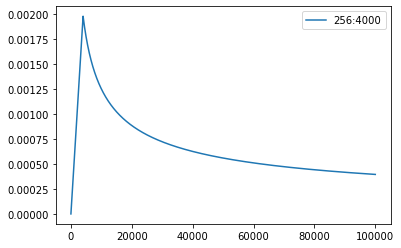

In [75]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim,
    factor=config.lr_factor,
    warmup=config.lr_warmup,
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# warmup展示

# Training

In [76]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples

    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp)

    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i

            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))

                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding

        scaler.step(optimizer)
        scaler.update()

        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })

    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [77]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()),
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()),
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [78]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)

    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)

            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)

    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs

    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)

    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])

    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

In [79]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)

        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")

        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")

        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()

    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [80]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [81]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-11-11 17:09:58 | INFO | hw5.seq2seq | task: TranslationTask
2021-11-11 17:09:58 | INFO | hw5.seq2seq | encoder: RNNEncoder
2021-11-11 17:09:58 | INFO | hw5.seq2seq | decoder: RNNDecoder
2021-11-11 17:09:58 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-11-11 17:09:58 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-11-11 17:09:58 | INFO | hw5.seq2seq | num. model params: 11,251,968 (num. trained: 11,251,968)
2021-11-11 17:09:58 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [82]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-11-11 17:09:59 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-11-11 17:09:59 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/checkpoint_last.pt: step=23370 loss=3.8248257637023926 bleu=18.396943312773637


2021-11-11 17:11:00 | INFO | hw5.seq2seq | training loss: 3.9313
2021-11-11 17:11:00 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:11:15 | INFO | hw5.seq2seq | example source: but the point is , it doesn't feel that way .
2021-11-11 17:11:15 | INFO | hw5.seq2seq | example hypothesis: 但重點是 , 它不會感覺那樣 。
2021-11-11 17:11:15 | INFO | hw5.seq2seq | example reference: 但重點是 , 感覺起來卻不是那麼回事呀
2021-11-11 17:11:15 | INFO | hw5.seq2seq | validation loss:	3.8259
2021-11-11 17:11:15 | INFO | hw5.seq2seq | BLEU = 18.25 49.2/25.3/14.0/8.2 (BP = 0.937 ratio = 0.939 hyp_len = 104975 ref_len = 111811)
2021-11-11 17:11:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint1.pt
2021-11-11 17:11:16 | INFO | hw5.seq2seq | end of epoch 1


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3e297d9790>
Traceback (most recent call last):
  File "/home/wy/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/wy/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/wy/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3e297d9790>
Traceback (most recent call last):
  File "/home/wy/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/wy/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_worke

2021-11-11 17:12:18 | INFO | hw5.seq2seq | training loss: 3.9237
2021-11-11 17:12:18 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:12:33 | INFO | hw5.seq2seq | example source: we can push through that .
2021-11-11 17:12:33 | INFO | hw5.seq2seq | example hypothesis: 我們可以推動這一點 。
2021-11-11 17:12:33 | INFO | hw5.seq2seq | example reference: 我們可以衝破這些限制 。
2021-11-11 17:12:33 | INFO | hw5.seq2seq | validation loss:	3.8228
2021-11-11 17:12:33 | INFO | hw5.seq2seq | BLEU = 18.33 48.2/24.9/13.7/7.9 (BP = 0.964 ratio = 0.964 hyp_len = 107804 ref_len = 111811)
2021-11-11 17:12:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint2.pt
2021-11-11 17:12:34 | INFO | hw5.seq2seq | end of epoch 2


2021-11-11 17:13:35 | INFO | hw5.seq2seq | training loss: 3.9188
2021-11-11 17:13:35 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:13:51 | INFO | hw5.seq2seq | example source: thank you .
2021-11-11 17:13:51 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2021-11-11 17:13:51 | INFO | hw5.seq2seq | example reference: 謝謝 。
2021-11-11 17:13:51 | INFO | hw5.seq2seq | validation loss:	3.8143
2021-11-11 17:13:51 | INFO | hw5.seq2seq | BLEU = 18.61 47.8/24.6/13.7/8.0 (BP = 0.983 ratio = 0.984 hyp_len = 109967 ref_len = 111811)
2021-11-11 17:13:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint3.pt
2021-11-11 17:13:51 | INFO | hw5.seq2seq | end of epoch 3


2021-11-11 17:14:53 | INFO | hw5.seq2seq | training loss: 3.9117
2021-11-11 17:14:53 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:15:09 | INFO | hw5.seq2seq | example source: those men would eventually be convicted of placing a van filled with 1 , 500 pounds of explosives into the sublevel parking lot of the world trade center's north tower , causing an explosion that killed six people and injured over 1 , 000 others .
2021-11-11 17:15:09 | INFO | hw5.seq2seq | example hypothesis: 那些男人最終會被邀請 , 將一萬五百磅的炸彈爆炸 , 殺害六人 , 並受傷超過1000磅的爆炸 。
2021-11-11 17:15:09 | INFO | hw5.seq2seq | example reference: 這群男人最終被指控將滿載1500磅重的炸彈的廂式貨車停在世界貿易中心北塔的地下停車場 , 爆炸造成6人死亡 , 同時致使超過1000人受傷 。
2021-11-11 17:15:09 | INFO | hw5.seq2seq | validation loss:	3.8116
2021-11-11 17:15:09 | INFO | hw5.seq2seq | BLEU = 18.48 48.3/24.9/13.8/8.0 (BP = 0.970 ratio = 0.970 hyp_len = 108477 ref_len = 111811)
2021-11-11 17:15:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint4.pt
2021-11-11 17:15:10 | INFO | hw5.seq2seq | end of epoch 4


2021-11-11 17:16:11 | INFO | hw5.seq2seq | training loss: 3.9016
2021-11-11 17:16:11 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:16:27 | INFO | hw5.seq2seq | example source: but this is really how i go about creating these photographs .
2021-11-11 17:16:27 | INFO | hw5.seq2seq | example hypothesis: 但這真的是我要如何創造這些照片 。
2021-11-11 17:16:27 | INFO | hw5.seq2seq | example reference: 但是我真的是這樣做出這些相片的 。
2021-11-11 17:16:27 | INFO | hw5.seq2seq | validation loss:	3.8078
2021-11-11 17:16:27 | INFO | hw5.seq2seq | BLEU = 18.30 46.5/23.8/13.2/7.7 (BP = 1.000 ratio = 1.018 hyp_len = 113823 ref_len = 111811)
2021-11-11 17:16:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint5.pt
2021-11-11 17:16:27 | INFO | hw5.seq2seq | end of epoch 5


2021-11-11 17:17:30 | INFO | hw5.seq2seq | training loss: 3.8950
2021-11-11 17:17:30 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:17:46 | INFO | hw5.seq2seq | example source: so that is a fact .
2021-11-11 17:17:46 | INFO | hw5.seq2seq | example hypothesis: 這是事實 。
2021-11-11 17:17:46 | INFO | hw5.seq2seq | example reference: 這就是事實
2021-11-11 17:17:46 | INFO | hw5.seq2seq | validation loss:	3.8043
2021-11-11 17:17:46 | INFO | hw5.seq2seq | BLEU = 18.83 48.1/24.8/13.8/8.0 (BP = 0.988 ratio = 0.988 hyp_len = 110511 ref_len = 111811)
2021-11-11 17:17:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint6.pt
2021-11-11 17:17:47 | INFO | hw5.seq2seq | end of epoch 6


2021-11-11 17:18:48 | INFO | hw5.seq2seq | training loss: 3.8906
2021-11-11 17:18:48 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:19:03 | INFO | hw5.seq2seq | example source: thank you so much everyone .
2021-11-11 17:19:03 | INFO | hw5.seq2seq | example hypothesis: 非常謝謝大家 。
2021-11-11 17:19:03 | INFO | hw5.seq2seq | example reference: 謝謝大家 !
2021-11-11 17:19:03 | INFO | hw5.seq2seq | validation loss:	3.8091
2021-11-11 17:19:03 | INFO | hw5.seq2seq | BLEU = 18.23 50.2/26.1/14.5/8.5 (BP = 0.910 ratio = 0.914 hyp_len = 102172 ref_len = 111811)
2021-11-11 17:19:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint7.pt
2021-11-11 17:19:03 | INFO | hw5.seq2seq | end of epoch 7


2021-11-11 17:20:05 | INFO | hw5.seq2seq | training loss: 3.8845
2021-11-11 17:20:06 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:20:21 | INFO | hw5.seq2seq | example source: these differences became a source of inspired artistic celebration .
2021-11-11 17:20:21 | INFO | hw5.seq2seq | example hypothesis: 這些差異變成了激發藝術慶祝的源源 。
2021-11-11 17:20:21 | INFO | hw5.seq2seq | example reference: 這些差異變成了一個源頭 , 富有靈感之藝術讚頌的源頭 。
2021-11-11 17:20:21 | INFO | hw5.seq2seq | validation loss:	3.7978
2021-11-11 17:20:21 | INFO | hw5.seq2seq | BLEU = 18.59 48.6/25.1/13.9/8.1 (BP = 0.966 ratio = 0.966 hyp_len = 108038 ref_len = 111811)
2021-11-11 17:20:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint8.pt
2021-11-11 17:20:22 | INFO | hw5.seq2seq | end of epoch 8


2021-11-11 17:21:22 | INFO | hw5.seq2seq | training loss: 3.8793
2021-11-11 17:21:22 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:21:37 | INFO | hw5.seq2seq | example source: it's not .
2021-11-11 17:21:37 | INFO | hw5.seq2seq | example hypothesis: 不是 。
2021-11-11 17:21:37 | INFO | hw5.seq2seq | example reference: 不是
2021-11-11 17:21:37 | INFO | hw5.seq2seq | validation loss:	3.7980
2021-11-11 17:21:37 | INFO | hw5.seq2seq | BLEU = 18.51 46.8/24.1/13.4/7.8 (BP = 1.000 ratio = 1.022 hyp_len = 114238 ref_len = 111811)
2021-11-11 17:21:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint9.pt
2021-11-11 17:21:38 | INFO | hw5.seq2seq | end of epoch 9


2021-11-11 17:22:35 | INFO | hw5.seq2seq | training loss: 3.8732
2021-11-11 17:22:35 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:22:51 | INFO | hw5.seq2seq | example source: so think about when you have friends , families and coworkers in california , on the west coast or in other parts of the world .
2021-11-11 17:22:51 | INFO | hw5.seq2seq | example hypothesis: 想想看 , 當你有朋友、家庭和同事在加州 , 在西岸或其他世界各地 。
2021-11-11 17:22:51 | INFO | hw5.seq2seq | example reference: 所以 , 想像當你嘗試聯繫在加州 , 在西海岸或者在世界的另一面
2021-11-11 17:22:51 | INFO | hw5.seq2seq | validation loss:	3.7970
2021-11-11 17:22:51 | INFO | hw5.seq2seq | BLEU = 18.53 48.9/25.2/14.0/8.1 (BP = 0.957 ratio = 0.958 hyp_len = 107132 ref_len = 111811)
2021-11-11 17:22:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint10.pt
2021-11-11 17:22:52 | INFO | hw5.seq2seq | end of epoch 10


2021-11-11 17:23:54 | INFO | hw5.seq2seq | training loss: 3.8691
2021-11-11 17:23:54 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:24:10 | INFO | hw5.seq2seq | example source: and i was asked to move out because one of my roommates had shared my status with her parents .
2021-11-11 17:24:10 | INFO | hw5.seq2seq | example hypothesis: 我被要求搬出去 , 因為我的室友和她的父母分享了我的室友 。
2021-11-11 17:24:10 | INFO | hw5.seq2seq | example reference: 我會被要求搬出去 , 是因為其中一名室友和她的父母談了我的狀況 。
2021-11-11 17:24:10 | INFO | hw5.seq2seq | validation loss:	3.7987
2021-11-11 17:24:10 | INFO | hw5.seq2seq | BLEU = 18.84 48.3/25.0/13.9/8.1 (BP = 0.981 ratio = 0.981 hyp_len = 109652 ref_len = 111811)
2021-11-11 17:24:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint11.pt
2021-11-11 17:24:11 | INFO | hw5.seq2seq | end of epoch 11


2021-11-11 17:25:12 | INFO | hw5.seq2seq | training loss: 3.8660
2021-11-11 17:25:12 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:25:27 | INFO | hw5.seq2seq | example source: and i want to share with you a quick video from our facility that gives you a sense of how this looks at scale .
2021-11-11 17:25:27 | INFO | hw5.seq2seq | example hypothesis: 我想和各位分享一個短短的影片 , 給予你對規模的看法 。
2021-11-11 17:25:27 | INFO | hw5.seq2seq | example reference: 我想與你們快速分享一段關於我們設備的影片可以瞭解一下它的規模
2021-11-11 17:25:27 | INFO | hw5.seq2seq | validation loss:	3.7913
2021-11-11 17:25:27 | INFO | hw5.seq2seq | BLEU = 18.59 49.1/25.4/14.1/8.3 (BP = 0.953 ratio = 0.954 hyp_len = 106648 ref_len = 111811)
2021-11-11 17:25:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint12.pt
2021-11-11 17:25:27 | INFO | hw5.seq2seq | end of epoch 12


2021-11-11 17:26:28 | INFO | hw5.seq2seq | training loss: 3.8619
2021-11-11 17:26:28 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:26:45 | INFO | hw5.seq2seq | example source: it's a distinction perhaps we might make between two nobel laureates , richard feynman and john nash .
2021-11-11 17:26:45 | INFO | hw5.seq2seq | example hypothesis: 我們可能在兩個諾貝爾獎得主 , 理查·費曼和約翰納許 。
2021-11-11 17:26:45 | INFO | hw5.seq2seq | example reference: 我們或許可以從兩位諾貝爾獎得主 , 理查費曼和約翰奈許之間看出這樣的差異 。
2021-11-11 17:26:45 | INFO | hw5.seq2seq | validation loss:	3.7984
2021-11-11 17:26:45 | INFO | hw5.seq2seq | BLEU = 18.68 48.7/25.3/14.0/8.2 (BP = 0.965 ratio = 0.966 hyp_len = 107975 ref_len = 111811)
2021-11-11 17:26:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint13.pt
2021-11-11 17:26:45 | INFO | hw5.seq2seq | end of epoch 13


2021-11-11 17:27:46 | INFO | hw5.seq2seq | training loss: 3.8579
2021-11-11 17:27:46 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:28:02 | INFO | hw5.seq2seq | example source: and therein lie the words of wisdom of a young girl whose brief life forever impacted mine .
2021-11-11 17:28:02 | INFO | hw5.seq2seq | example hypothesis: 藉由一個年輕女孩的智慧 , 為我帶來一個年輕女孩的意見 , 她們的生命永遠影響了我 。
2021-11-11 17:28:02 | INFO | hw5.seq2seq | example reference: 她說的話對我有很大啟發 。 這一個年幼女孩短暫的一生永遠影響著我 。
2021-11-11 17:28:02 | INFO | hw5.seq2seq | validation loss:	3.7925
2021-11-11 17:28:02 | INFO | hw5.seq2seq | BLEU = 18.38 51.0/26.6/14.7/8.6 (BP = 0.902 ratio = 0.907 hyp_len = 101396 ref_len = 111811)
2021-11-11 17:28:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint14.pt
2021-11-11 17:28:02 | INFO | hw5.seq2seq | end of epoch 14


2021-11-11 17:29:03 | INFO | hw5.seq2seq | training loss: 3.8572
2021-11-11 17:29:03 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:29:18 | INFO | hw5.seq2seq | example source: and we've started making curtains , and not only is it beautiful , but people can see status that you care about your children .
2021-11-11 17:29:18 | INFO | hw5.seq2seq | example hypothesis: 我們開始製作曲線 , 不僅是美麗的 , 還能看見你在乎你的小孩的地位 。
2021-11-11 17:29:18 | INFO | hw5.seq2seq | example reference: 我們也開始生産窗簾不止因爲窗簾看起來漂亮 , 人們也可以看到你的地位看得出你很關心小孩
2021-11-11 17:29:18 | INFO | hw5.seq2seq | validation loss:	3.7905
2021-11-11 17:29:18 | INFO | hw5.seq2seq | BLEU = 18.62 49.9/25.8/14.3/8.3 (BP = 0.941 ratio = 0.943 hyp_len = 105445 ref_len = 111811)
2021-11-11 17:29:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint15.pt
2021-11-11 17:29:19 | INFO | hw5.seq2seq | end of epoch 15


2021-11-11 17:30:21 | INFO | hw5.seq2seq | training loss: 3.8487
2021-11-11 17:30:21 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:30:37 | INFO | hw5.seq2seq | example source: now , i'm not suggesting we want to raise our babies in our stomach , but i am suggesting it's possible we might want to manage gastric secretion in the gut .
2021-11-11 17:30:37 | INFO | hw5.seq2seq | example hypothesis: 我並不是建議我們想要養育我們的嬰兒 , 但是我建議我們想把嬰兒放在我們的胃中 , 但我建議我們要把嬰兒放在腸道中 。
2021-11-11 17:30:37 | INFO | hw5.seq2seq | example reference: 我並不是說要把嬰兒養在胃裡而是我們可能可以了解胃在內臟裡的分泌物
2021-11-11 17:30:37 | INFO | hw5.seq2seq | validation loss:	3.7880
2021-11-11 17:30:37 | INFO | hw5.seq2seq | BLEU = 18.91 48.1/24.8/13.7/8.0 (BP = 0.996 ratio = 0.996 hyp_len = 111356 ref_len = 111811)
2021-11-11 17:30:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint16.pt
2021-11-11 17:30:38 | INFO | hw5.seq2seq | end of epoch 16


2021-11-11 17:31:39 | INFO | hw5.seq2seq | training loss: 3.8478
2021-11-11 17:31:39 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:31:55 | INFO | hw5.seq2seq | example source: so we're hoping that's what they'll do .
2021-11-11 17:31:55 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我們希望他們會這樣做 。
2021-11-11 17:31:55 | INFO | hw5.seq2seq | example reference: 所以 , 我們希望它們能夠幫忙 。
2021-11-11 17:31:55 | INFO | hw5.seq2seq | validation loss:	3.7832
2021-11-11 17:31:55 | INFO | hw5.seq2seq | BLEU = 19.06 48.2/24.9/13.8/8.0 (BP = 0.999 ratio = 0.999 hyp_len = 111659 ref_len = 111811)
2021-11-11 17:31:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint17.pt
2021-11-11 17:31:56 | INFO | hw5.seq2seq | end of epoch 17


2021-11-11 17:32:57 | INFO | hw5.seq2seq | training loss: 3.8425
2021-11-11 17:32:57 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:33:13 | INFO | hw5.seq2seq | example source: i remember so vividly that day .
2021-11-11 17:33:13 | INFO | hw5.seq2seq | example hypothesis: 我記得很明天 。
2021-11-11 17:33:13 | INFO | hw5.seq2seq | example reference: 我對那一天還記憶猶新 。
2021-11-11 17:33:13 | INFO | hw5.seq2seq | validation loss:	3.7840
2021-11-11 17:33:13 | INFO | hw5.seq2seq | BLEU = 18.81 48.9/25.3/14.1/8.3 (BP = 0.964 ratio = 0.965 hyp_len = 107852 ref_len = 111811)
2021-11-11 17:33:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint18.pt
2021-11-11 17:33:13 | INFO | hw5.seq2seq | end of epoch 18


2021-11-11 17:34:14 | INFO | hw5.seq2seq | training loss: 3.8395
2021-11-11 17:34:14 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:34:31 | INFO | hw5.seq2seq | example source: the next step is to make compliant toes , and try to add spines and claws and set it for dry adhesives .
2021-11-11 17:34:31 | INFO | hw5.seq2seq | example hypothesis: 下一個步驟是要做出複雜的腳趾 , 試圖加上螺旋槳 , 並試圖加上螺旋槳和爪子 。
2021-11-11 17:34:31 | INFO | hw5.seq2seq | example reference: 下一步是要製造順從聽話的腳趾頭 。 然後加上刺和爪子 , 再加上乾膠 。
2021-11-11 17:34:31 | INFO | hw5.seq2seq | validation loss:	3.7868
2021-11-11 17:34:31 | INFO | hw5.seq2seq | BLEU = 19.01 48.9/25.3/14.1/8.3 (BP = 0.976 ratio = 0.976 hyp_len = 109158 ref_len = 111811)
2021-11-11 17:34:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint19.pt
2021-11-11 17:34:32 | INFO | hw5.seq2seq | end of epoch 19


2021-11-11 17:35:32 | INFO | hw5.seq2seq | training loss: 3.8353
2021-11-11 17:35:32 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:35:48 | INFO | hw5.seq2seq | example source: and got the cord off of the baby's neck , and a healthy screaming , kicking baby arrived , just as the dad ran in from the parking lot , " hi , you have a son , i'm dr . darria .
2021-11-11 17:35:48 | INFO | hw5.seq2seq | example hypothesis: 把寶寶的寶寶帶走了 , 爸爸從停車場開始 , 說: 「 嗨 , 你有兒子 , 我是darria 。 」
2021-11-11 17:35:48 | INFO | hw5.seq2seq | example reference: 我把臍帶從嬰兒的脖子繞開 , 接著 , 一個健康哭鬧的嬰兒誕生了 。 同時 , 他的父親剛從停車場趕來 。 「 你好 , 是一個男孩 。 我是達里亞醫生 。
2021-11-11 17:35:48 | INFO | hw5.seq2seq | validation loss:	3.7791
2021-11-11 17:35:48 | INFO | hw5.seq2seq | BLEU = 18.97 48.7/25.3/14.1/8.2 (BP = 0.978 ratio = 0.979 hyp_len = 109418 ref_len = 111811)
2021-11-11 17:35:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint20.pt
2021-11-11 17:35:48 | INFO | hw5.seq2seq | end of epoch 20


2021-11-11 17:36:49 | INFO | hw5.seq2seq | training loss: 3.8358
2021-11-11 17:36:49 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:37:05 | INFO | hw5.seq2seq | example source: no , but the issue of city building in democracy is interesting because it creates chaos , right ?
2021-11-11 17:37:05 | INFO | hw5.seq2seq | example hypothesis: 不是 , 但城市建築的建築在民主中是很有趣的 , 因為它會產生混亂 , 對吧 ?
2021-11-11 17:37:05 | INFO | hw5.seq2seq | example reference: 不 , 但民主的城市建設很有趣 , 因為會造成混亂 , 是嗎 ?
2021-11-11 17:37:05 | INFO | hw5.seq2seq | validation loss:	3.7829
2021-11-11 17:37:05 | INFO | hw5.seq2seq | BLEU = 18.96 49.6/25.7/14.3/8.4 (BP = 0.959 ratio = 0.960 hyp_len = 107342 ref_len = 111811)
2021-11-11 17:37:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint21.pt
2021-11-11 17:37:05 | INFO | hw5.seq2seq | end of epoch 21


2021-11-11 17:38:07 | INFO | hw5.seq2seq | training loss: 3.8279
2021-11-11 17:38:07 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:38:24 | INFO | hw5.seq2seq | example source: so i'm going to show you a demo of this .
2021-11-11 17:38:24 | INFO | hw5.seq2seq | example hypothesis: 我現在要展示給大家看的 。
2021-11-11 17:38:24 | INFO | hw5.seq2seq | example reference: 現在請各位看示範
2021-11-11 17:38:24 | INFO | hw5.seq2seq | validation loss:	3.7838
2021-11-11 17:38:24 | INFO | hw5.seq2seq | BLEU = 19.01 49.5/25.7/14.4/8.4 (BP = 0.960 ratio = 0.960 hyp_len = 107381 ref_len = 111811)
2021-11-11 17:38:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint22.pt
2021-11-11 17:38:24 | INFO | hw5.seq2seq | end of epoch 22


2021-11-11 17:39:24 | INFO | hw5.seq2seq | training loss: 3.8265
2021-11-11 17:39:24 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:39:40 | INFO | hw5.seq2seq | example source: you see , in every country where you hear about armed jihadis targeting civilians , there are also unarmed people defying those militants that you don't hear about , and those people need our support to succeed .
2021-11-11 17:39:40 | INFO | hw5.seq2seq | example hypothesis: 在每一個國家 , 你聽到的軍隊是軍隊 , 那些軍隊 , 你不聽到軍隊 , 那些軍隊也無法聽見 , 而那些我們支持成功的人 。
2021-11-11 17:39:40 | INFO | hw5.seq2seq | example reference: 你看 , 不管在哪個國家你都會聽到武裝聖戰者針對平民百姓 , 也有很多手無寸鐵的人民公然反抗那些激進分子 , 只是你沒聽過 , 那些人需要我們的支持才能成功 。
2021-11-11 17:39:40 | INFO | hw5.seq2seq | validation loss:	3.7862
2021-11-11 17:39:40 | INFO | hw5.seq2seq | BLEU = 18.86 50.2/26.2/14.6/8.5 (BP = 0.937 ratio = 0.939 hyp_len = 104984 ref_len = 111811)
2021-11-11 17:39:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint23.pt
2021-11-11 17:39:40 | INFO | hw5.seq2seq | end of epoch 23


2021-11-11 17:40:41 | INFO | hw5.seq2seq | training loss: 3.8216
2021-11-11 17:40:41 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:40:56 | INFO | hw5.seq2seq | example source: from gezi to tahrir to elsewhere , i've seen people put their lives and livelihoods on the line .
2021-11-11 17:40:56 | INFO | hw5.seq2seq | example hypothesis: 從gezi到其他地方 , 我見過人們把他們的生活和生存放在線上 。
2021-11-11 17:40:56 | INFO | hw5.seq2seq | example reference: 從格濟公園 , 到解放廣場 , 再到其它地方 , 我見過許多人用他們的生命和生計做賭注 。
2021-11-11 17:40:56 | INFO | hw5.seq2seq | validation loss:	3.7820
2021-11-11 17:40:56 | INFO | hw5.seq2seq | BLEU = 19.09 49.4/25.6/14.3/8.4 (BP = 0.968 ratio = 0.968 hyp_len = 108245 ref_len = 111811)
2021-11-11 17:40:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint24.pt
2021-11-11 17:40:57 | INFO | hw5.seq2seq | end of epoch 24


2021-11-11 17:41:59 | INFO | hw5.seq2seq | training loss: 3.8208
2021-11-11 17:41:59 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:42:15 | INFO | hw5.seq2seq | example source: and every project before that had been completely personal and it was a revelation when people just started commenting , started giving feedback on your code .
2021-11-11 17:42:15 | INFO | hw5.seq2seq | example hypothesis: 每個專案計畫都已經完全個人化了 , 開始給回饋在你的程式碼上 。
2021-11-11 17:42:15 | INFO | hw5.seq2seq | example reference: 在那之前每一件計劃都是我個人的東西 , 所以當大家開始評論 , 開始對你的程式給意見時 , 真的是一種啟示 。
2021-11-11 17:42:15 | INFO | hw5.seq2seq | validation loss:	3.7747
2021-11-11 17:42:15 | INFO | hw5.seq2seq | BLEU = 19.02 48.2/24.9/13.8/8.0 (BP = 0.997 ratio = 0.997 hyp_len = 111526 ref_len = 111811)
2021-11-11 17:42:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint25.pt
2021-11-11 17:42:15 | INFO | hw5.seq2seq | end of epoch 25


2021-11-11 17:43:15 | INFO | hw5.seq2seq | training loss: 3.8188
2021-11-11 17:43:15 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:43:31 | INFO | hw5.seq2seq | example source: thank you so much .
2021-11-11 17:43:31 | INFO | hw5.seq2seq | example hypothesis: 謝謝
2021-11-11 17:43:31 | INFO | hw5.seq2seq | example reference: 感謝各位.
2021-11-11 17:43:31 | INFO | hw5.seq2seq | validation loss:	3.7827
2021-11-11 17:43:31 | INFO | hw5.seq2seq | BLEU = 18.82 51.3/26.9/15.0/8.9 (BP = 0.909 ratio = 0.913 hyp_len = 102076 ref_len = 111811)
2021-11-11 17:43:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint26.pt
2021-11-11 17:43:32 | INFO | hw5.seq2seq | end of epoch 26


2021-11-11 17:44:33 | INFO | hw5.seq2seq | training loss: 3.8176
2021-11-11 17:44:33 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:44:48 | INFO | hw5.seq2seq | example source: at the age of six months , virtually every one of us is able to differentiate between animate and inanimate objects .
2021-11-11 17:44:48 | INFO | hw5.seq2seq | example hypothesis: 在六個月之內 , 幾乎每個人都能分辨出動作和不佳的物體 。
2021-11-11 17:44:48 | INFO | hw5.seq2seq | example reference: 在六個月大時 , 幾乎每個人都能辨別東西是否有生命 。
2021-11-11 17:44:48 | INFO | hw5.seq2seq | validation loss:	3.7769
2021-11-11 17:44:48 | INFO | hw5.seq2seq | BLEU = 18.97 50.3/26.2/14.6/8.6 (BP = 0.942 ratio = 0.943 hyp_len = 105482 ref_len = 111811)
2021-11-11 17:44:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint27.pt
2021-11-11 17:44:49 | INFO | hw5.seq2seq | end of epoch 27


2021-11-11 17:45:50 | INFO | hw5.seq2seq | training loss: 3.8123
2021-11-11 17:45:50 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:46:08 | INFO | hw5.seq2seq | example source: the problem is there is no such thing as a viable democracy made up of experts , zealots , politicians and spectators .
2021-11-11 17:46:08 | INFO | hw5.seq2seq | example hypothesis: 問題在於 , 政治人物和觀測者都沒有這麼多 。
2021-11-11 17:46:08 | INFO | hw5.seq2seq | example reference: 事實上 , 根本沒有一種民主制度是由專家 , 狂熱分子 , 政治家和旁觀者組成的
2021-11-11 17:46:08 | INFO | hw5.seq2seq | validation loss:	3.7724
2021-11-11 17:46:08 | INFO | hw5.seq2seq | BLEU = 19.12 48.9/25.3/14.1/8.3 (BP = 0.981 ratio = 0.981 hyp_len = 109678 ref_len = 111811)
2021-11-11 17:46:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint28.pt
2021-11-11 17:46:09 | INFO | hw5.seq2seq | end of epoch 28


2021-11-11 17:47:10 | INFO | hw5.seq2seq | training loss: 3.8106
2021-11-11 17:47:10 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:47:25 | INFO | hw5.seq2seq | example source: they're learning our culture , our language , our heritage and realizing we're just as different and just the same as each other .
2021-11-11 17:47:25 | INFO | hw5.seq2seq | example hypothesis: 他們學習我們的文化、我們的語言、我們的文化、我們的語言、我們的文化、我們的語言、我們的文化 , 我們的語言、我們的文化 , 我們的語言、我們的文化 , 我們的語言、我們的文化 , 我們的語言、我們的文化、我們的語言、我們的文化、我們的語言、我們的文化
2021-11-11 17:47:25 | INFO | hw5.seq2seq | example reference: 他們正在習知我們的文化、語言、傳統 , 並意識到彼此不同及相同之處 。
2021-11-11 17:47:25 | INFO | hw5.seq2seq | validation loss:	3.7727
2021-11-11 17:47:25 | INFO | hw5.seq2seq | BLEU = 19.11 49.9/25.9/14.4/8.5 (BP = 0.959 ratio = 0.960 hyp_len = 107309 ref_len = 111811)
2021-11-11 17:47:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint29.pt
2021-11-11 17:47:26 | INFO | hw5.seq2seq | end of epoch 29


2021-11-11 17:48:26 | INFO | hw5.seq2seq | training loss: 3.8074
2021-11-11 17:48:26 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:48:42 | INFO | hw5.seq2seq | example source: but did you know that only two percent of that funding went to rebuild haitian public institutions , including its health sector ?
2021-11-11 17:48:42 | INFO | hw5.seq2seq | example hypothesis: 但你知道 , 只有2%的資金來重建海地公體機構 , 包括它的健康部門嗎 ?
2021-11-11 17:48:42 | INFO | hw5.seq2seq | example reference: 但你知不知道國際社會捐款中只有2%用去重建海地的公共體制 , 包括衞生部門 ?
2021-11-11 17:48:42 | INFO | hw5.seq2seq | validation loss:	3.7696
2021-11-11 17:48:42 | INFO | hw5.seq2seq | BLEU = 19.14 50.0/26.0/14.5/8.5 (BP = 0.957 ratio = 0.957 hyp_len = 107055 ref_len = 111811)
2021-11-11 17:48:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint30.pt
2021-11-11 17:48:43 | INFO | hw5.seq2seq | end of epoch 30


2021-11-11 17:49:43 | INFO | hw5.seq2seq | training loss: 3.8109
2021-11-11 17:49:43 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:50:01 | INFO | hw5.seq2seq | example source: thank you .
2021-11-11 17:50:01 | INFO | hw5.seq2seq | example hypothesis: 謝謝
2021-11-11 17:50:01 | INFO | hw5.seq2seq | example reference: 謝謝 。
2021-11-11 17:50:01 | INFO | hw5.seq2seq | validation loss:	3.7714
2021-11-11 17:50:01 | INFO | hw5.seq2seq | BLEU = 19.26 48.6/25.3/14.1/8.2 (BP = 0.992 ratio = 0.992 hyp_len = 110910 ref_len = 111811)
2021-11-11 17:50:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint31.pt
2021-11-11 17:50:02 | INFO | hw5.seq2seq | end of epoch 31


2021-11-11 17:51:02 | INFO | hw5.seq2seq | training loss: 3.8104
2021-11-11 17:51:02 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:51:18 | INFO | hw5.seq2seq | example source: and i think the answer is a lot of different people are going to have to do a lot of different things .
2021-11-11 17:51:18 | INFO | hw5.seq2seq | example hypothesis: 我認為答案是很多不同的人 , 必須要做很多不同的事 。
2021-11-11 17:51:18 | INFO | hw5.seq2seq | example reference: 我的回答是 , 我們所有人各盡其責 。
2021-11-11 17:51:18 | INFO | hw5.seq2seq | validation loss:	3.7730
2021-11-11 17:51:18 | INFO | hw5.seq2seq | BLEU = 19.19 48.1/25.0/13.9/8.1 (BP = 1.000 ratio = 1.004 hyp_len = 112301 ref_len = 111811)
2021-11-11 17:51:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint32.pt
2021-11-11 17:51:18 | INFO | hw5.seq2seq | end of epoch 32


2021-11-11 17:52:19 | INFO | hw5.seq2seq | training loss: 3.8077
2021-11-11 17:52:19 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:52:35 | INFO | hw5.seq2seq | example source: that ambition that had allowed him to laboriously educate himself by himself , to go through that string of political failures and the darkest days of the war .
2021-11-11 17:52:35 | INFO | hw5.seq2seq | example hypothesis: 這個野心讓他成為了政治失敗和最黑暗的戰爭的一部分 。
2021-11-11 17:52:35 | INFO | hw5.seq2seq | example reference: 這樣的企圖心策勵他辛辛苦苦不懈的自我教育 , 鼓舞著他面對一連串的政壇失意及堅強走過戰爭時最黑暗的歲月.
2021-11-11 17:52:35 | INFO | hw5.seq2seq | validation loss:	3.7724
2021-11-11 17:52:35 | INFO | hw5.seq2seq | BLEU = 19.04 50.5/26.3/14.7/8.6 (BP = 0.941 ratio = 0.943 hyp_len = 105439 ref_len = 111811)
2021-11-11 17:52:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint33.pt
2021-11-11 17:52:35 | INFO | hw5.seq2seq | end of epoch 33


2021-11-11 17:53:36 | INFO | hw5.seq2seq | training loss: 3.8046
2021-11-11 17:53:36 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:53:51 | INFO | hw5.seq2seq | example source: this response has evolved from the physiological mechanism designed to make sure we can survive in a crisis .
2021-11-11 17:53:51 | INFO | hw5.seq2seq | example hypothesis: 這種反應來自生理機制 , 來確保我們能在危機中生存 。
2021-11-11 17:53:51 | INFO | hw5.seq2seq | example reference: 這是心理機制進化的反應 , 目的是使我們能夠應付危機 , 生存下來 。
2021-11-11 17:53:51 | INFO | hw5.seq2seq | validation loss:	3.7665
2021-11-11 17:53:51 | INFO | hw5.seq2seq | BLEU = 18.80 47.4/24.4/13.6/7.9 (BP = 1.000 ratio = 1.029 hyp_len = 115015 ref_len = 111811)
2021-11-11 17:53:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint34.pt
2021-11-11 17:53:52 | INFO | hw5.seq2seq | end of epoch 34


2021-11-11 17:54:54 | INFO | hw5.seq2seq | training loss: 3.8034
2021-11-11 17:54:54 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:55:10 | INFO | hw5.seq2seq | example source: see that chair there ? the orange one ? that's the organic chair . 1940 .
2021-11-11 17:55:10 | INFO | hw5.seq2seq | example hypothesis: 看到那個椅子嗎 ? 橘色的 ? 橘色 ? 那是1940年的機椅 。
2021-11-11 17:55:10 | INFO | hw5.seq2seq | example reference: 看見那張椅子嗎 ? 橘黃色那個 ? 這是有機椅子 。 一九四零年 。
2021-11-11 17:55:10 | INFO | hw5.seq2seq | validation loss:	3.7650
2021-11-11 17:55:10 | INFO | hw5.seq2seq | BLEU = 18.68 47.0/24.3/13.5/7.9 (BP = 1.000 ratio = 1.043 hyp_len = 116628 ref_len = 111811)
2021-11-11 17:55:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint35.pt
2021-11-11 17:55:11 | INFO | hw5.seq2seq | end of epoch 35


2021-11-11 17:56:10 | INFO | hw5.seq2seq | training loss: 3.8020
2021-11-11 17:56:10 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:56:26 | INFO | hw5.seq2seq | example source: do they go from one side of the pacific to the other ?
2021-11-11 17:56:26 | INFO | hw5.seq2seq | example hypothesis: 牠們是否從太平洋到另一端 ?
2021-11-11 17:56:26 | INFO | hw5.seq2seq | example reference: 牠們會從太平洋的一端游到另一端嗎 ?
2021-11-11 17:56:26 | INFO | hw5.seq2seq | validation loss:	3.7642
2021-11-11 17:56:26 | INFO | hw5.seq2seq | BLEU = 19.26 48.5/25.0/13.9/8.1 (BP = 1.000 ratio = 1.001 hyp_len = 111911 ref_len = 111811)
2021-11-11 17:56:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint36.pt
2021-11-11 17:56:27 | INFO | hw5.seq2seq | end of epoch 36


2021-11-11 17:57:27 | INFO | hw5.seq2seq | training loss: 3.7975
2021-11-11 17:57:27 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:57:43 | INFO | hw5.seq2seq | example source: i do , in any case .
2021-11-11 17:57:43 | INFO | hw5.seq2seq | example hypothesis: 在任何情況下 , 我都可以做 。
2021-11-11 17:57:43 | INFO | hw5.seq2seq | example reference: 無論如何我也認同 。
2021-11-11 17:57:43 | INFO | hw5.seq2seq | validation loss:	3.7659
2021-11-11 17:57:43 | INFO | hw5.seq2seq | BLEU = 19.16 50.0/25.9/14.4/8.5 (BP = 0.961 ratio = 0.962 hyp_len = 107519 ref_len = 111811)
2021-11-11 17:57:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint37.pt
2021-11-11 17:57:44 | INFO | hw5.seq2seq | end of epoch 37


2021-11-11 17:58:44 | INFO | hw5.seq2seq | training loss: 3.7934
2021-11-11 17:58:44 | INFO | hw5.seq2seq | begin validation


2021-11-11 17:59:00 | INFO | hw5.seq2seq | example source: and as you think about that experience , i want you to ask yourself: how might that experience of being a privileged player in a rigged game change the way you think about yourself and regard that other player ?
2021-11-11 17:59:00 | INFO | hw5.seq2seq | example hypothesis: 當你想到這個經驗時 , 我想問你自己 , 想想那個經驗 , 我希望你問自己: 「 身為有特權運動員的身份 , 會如何改變你對自己的想法 , 以及你認為自己和其他玩家的體驗 ? 」
2021-11-11 17:59:00 | INFO | hw5.seq2seq | example reference: 當你這麼想像時也請自問在這被動手腳的遊戲中作為佔上風的玩家會如何改變對自己和其他玩家的看法呢 ?
2021-11-11 17:59:00 | INFO | hw5.seq2seq | validation loss:	3.7665
2021-11-11 17:59:00 | INFO | hw5.seq2seq | BLEU = 19.21 49.1/25.4/14.2/8.3 (BP = 0.982 ratio = 0.982 hyp_len = 109803 ref_len = 111811)
2021-11-11 17:59:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint38.pt
2021-11-11 17:59:00 | INFO | hw5.seq2seq | end of epoch 38


2021-11-11 18:00:03 | INFO | hw5.seq2seq | training loss: 3.7940
2021-11-11 18:00:03 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:00:20 | INFO | hw5.seq2seq | example source: this is a photograph i took at the northern tip of baffin island when i went narwhal hunting with some inuit people , and this man , olayuk , told me a marvelous story of his grandfather .
2021-11-11 18:00:20 | INFO | hw5.seq2seq | example hypothesis: 這是我在巴菲爾島拍攝的照片 , 當時我在巴菲爾島的一家小島上拍攝 , 當時我拍攝了一幅拍攝的照片 , 告訴我 , 關於他的祖父 , 這是一個很棒的故事 。
2021-11-11 18:00:20 | INFO | hw5.seq2seq | example reference: 這張照片是我在巴芬島的北邊山頂上拍攝的那時我和一些因紐特人去捕獨角鯨這個叫奧拉雅的人述說了他祖父的傳奇故事
2021-11-11 18:00:20 | INFO | hw5.seq2seq | validation loss:	3.7664
2021-11-11 18:00:20 | INFO | hw5.seq2seq | BLEU = 19.20 49.8/26.0/14.5/8.5 (BP = 0.960 ratio = 0.961 hyp_len = 107414 ref_len = 111811)
2021-11-11 18:00:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint39.pt
2021-11-11 18:00:20 | INFO | hw5.seq2seq | end of epoch 39


2021-11-11 18:01:21 | INFO | hw5.seq2seq | training loss: 3.7920
2021-11-11 18:01:21 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:01:37 | INFO | hw5.seq2seq | example source: congratulations .
2021-11-11 18:01:37 | INFO | hw5.seq2seq | example hypothesis: 恭喜 。
2021-11-11 18:01:37 | INFO | hw5.seq2seq | example reference: 恭喜各位 。
2021-11-11 18:01:37 | INFO | hw5.seq2seq | validation loss:	3.7649
2021-11-11 18:01:37 | INFO | hw5.seq2seq | BLEU = 19.32 50.3/26.3/14.8/8.7 (BP = 0.952 ratio = 0.953 hyp_len = 106606 ref_len = 111811)
2021-11-11 18:01:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint40.pt
2021-11-11 18:01:37 | INFO | hw5.seq2seq | end of epoch 40


2021-11-11 18:02:37 | INFO | hw5.seq2seq | training loss: 3.7893
2021-11-11 18:02:37 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:02:53 | INFO | hw5.seq2seq | example source: so cmu allows 32 possible symbols , but as you can see , there's only a small number that most people are using , so we're not actually getting very much strength from the symbols in our passwords .
2021-11-11 18:02:53 | INFO | hw5.seq2seq | example hypothesis: 所以cmu允許32種可能的符號 , 但你可以看到 , 只有少數人在密碼中取得非常強大的符號 。
2021-11-11 18:02:53 | INFO | hw5.seq2seq | example reference: cmu允許使用的符號有32個但正如你所見只有少數符號常常被使用所以實際上我們密碼也沒有變得更強因為密碼裡有了符號
2021-11-11 18:02:53 | INFO | hw5.seq2seq | validation loss:	3.7628
2021-11-11 18:02:53 | INFO | hw5.seq2seq | BLEU = 19.24 49.0/25.5/14.2/8.3 (BP = 0.982 ratio = 0.983 hyp_len = 109858 ref_len = 111811)
2021-11-11 18:02:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint41.pt
2021-11-11 18:02:53 | INFO | hw5.seq2seq | end of epoch 41


2021-11-11 18:03:53 | INFO | hw5.seq2seq | training loss: 3.7881
2021-11-11 18:03:53 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:04:09 | INFO | hw5.seq2seq | example source: and finally , my most recent image , which has such a special meaning for me personally: this is the serengeti national park in tanzania .
2021-11-11 18:04:09 | INFO | hw5.seq2seq | example hypothesis: 最後 , 我最近期的圖像 , 對我個人來說 , 這是坦尚尼亞的一個特殊意義 。
2021-11-11 18:04:09 | INFO | hw5.seq2seq | example reference: 最後 , 我最新的影像 , 對我個人有特別的意義:這是位於坦尚尼亞的塞倫蓋提國家公園 。
2021-11-11 18:04:09 | INFO | hw5.seq2seq | validation loss:	3.7617
2021-11-11 18:04:09 | INFO | hw5.seq2seq | BLEU = 19.16 49.5/25.8/14.3/8.3 (BP = 0.971 ratio = 0.971 hyp_len = 108599 ref_len = 111811)
2021-11-11 18:04:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint42.pt
2021-11-11 18:04:09 | INFO | hw5.seq2seq | end of epoch 42


2021-11-11 18:05:11 | INFO | hw5.seq2seq | training loss: 3.7865
2021-11-11 18:05:11 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:05:28 | INFO | hw5.seq2seq | example source: that freedom getting back into the hands of the consumer , that would be the most exciting thing .
2021-11-11 18:05:28 | INFO | hw5.seq2seq | example hypothesis: 那個自由可以回到消費者的消費者身上 , 這是最令人興奮的事情 。
2021-11-11 18:05:28 | INFO | hw5.seq2seq | example reference: 那自由重回消費者的手中 , 將會是最使人興奮的事情 。
2021-11-11 18:05:28 | INFO | hw5.seq2seq | validation loss:	3.7626
2021-11-11 18:05:28 | INFO | hw5.seq2seq | BLEU = 19.43 48.8/25.4/14.1/8.2 (BP = 0.998 ratio = 0.998 hyp_len = 111593 ref_len = 111811)
2021-11-11 18:05:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint43.pt
2021-11-11 18:05:29 | INFO | hw5.seq2seq | end of epoch 43


2021-11-11 18:06:30 | INFO | hw5.seq2seq | training loss: 3.7821
2021-11-11 18:06:30 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:06:46 | INFO | hw5.seq2seq | example source: and when people draw diagrams of git workflow , they use drawings that look like this .
2021-11-11 18:06:46 | INFO | hw5.seq2seq | example hypothesis: 當人們畫圖像這樣 , 他們用畫像這樣 。
2021-11-11 18:06:46 | INFO | hw5.seq2seq | example reference: 而要製作git的工作流程示意圖時它們都會長得像這樣
2021-11-11 18:06:46 | INFO | hw5.seq2seq | validation loss:	3.7583
2021-11-11 18:06:46 | INFO | hw5.seq2seq | BLEU = 19.15 48.3/24.9/13.9/8.1 (BP = 1.000 ratio = 1.011 hyp_len = 113064 ref_len = 111811)
2021-11-11 18:06:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint44.pt
2021-11-11 18:06:46 | INFO | hw5.seq2seq | end of epoch 44


2021-11-11 18:07:47 | INFO | hw5.seq2seq | training loss: 3.7823
2021-11-11 18:07:47 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:08:02 | INFO | hw5.seq2seq | example source: so here what we're trying to do is we bring the picture and project it into the 3d model space .
2021-11-11 18:08:02 | INFO | hw5.seq2seq | example hypothesis: 我們要做的是把圖片放到3d模型空間中 。
2021-11-11 18:08:02 | INFO | hw5.seq2seq | example reference: 這裏 , 我們正嘗試將圖片映射到三維模型空間中.
2021-11-11 18:08:02 | INFO | hw5.seq2seq | validation loss:	3.7661
2021-11-11 18:08:02 | INFO | hw5.seq2seq | BLEU = 19.16 51.3/26.7/15.0/8.8 (BP = 0.930 ratio = 0.933 hyp_len = 104264 ref_len = 111811)
2021-11-11 18:08:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint45.pt
2021-11-11 18:08:02 | INFO | hw5.seq2seq | end of epoch 45


2021-11-11 18:09:03 | INFO | hw5.seq2seq | training loss: 3.7800
2021-11-11 18:09:03 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:09:20 | INFO | hw5.seq2seq | example source: how do we do that ?
2021-11-11 18:09:20 | INFO | hw5.seq2seq | example hypothesis: 我們要怎麼做呢 ?
2021-11-11 18:09:20 | INFO | hw5.seq2seq | example reference: 那我們應該如何做呢 ?
2021-11-11 18:09:20 | INFO | hw5.seq2seq | validation loss:	3.7567
2021-11-11 18:09:20 | INFO | hw5.seq2seq | BLEU = 18.90 47.6/24.6/13.7/8.0 (BP = 1.000 ratio = 1.033 hyp_len = 115480 ref_len = 111811)
2021-11-11 18:09:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint46.pt
2021-11-11 18:09:20 | INFO | hw5.seq2seq | end of epoch 46


2021-11-11 18:10:22 | INFO | hw5.seq2seq | training loss: 3.7776
2021-11-11 18:10:22 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:10:38 | INFO | hw5.seq2seq | example source: second , we need to save our oldgrowth forests .
2021-11-11 18:10:38 | INFO | hw5.seq2seq | example hypothesis: 第二 , 我們需要拯救老森林 。
2021-11-11 18:10:38 | INFO | hw5.seq2seq | example reference: 第二 , 我們需要拯救我們的老齡林 。
2021-11-11 18:10:38 | INFO | hw5.seq2seq | validation loss:	3.7588
2021-11-11 18:10:38 | INFO | hw5.seq2seq | BLEU = 19.42 50.1/26.1/14.6/8.5 (BP = 0.968 ratio = 0.969 hyp_len = 108306 ref_len = 111811)
2021-11-11 18:10:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint47.pt
2021-11-11 18:10:39 | INFO | hw5.seq2seq | end of epoch 47


2021-11-11 18:11:39 | INFO | hw5.seq2seq | training loss: 3.7759
2021-11-11 18:11:39 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:11:55 | INFO | hw5.seq2seq | example source: my aim is to take a simple portrait of anyone who's anything other than 100 percent straight or feels like they fall in the lgbtq spectrum in any way .
2021-11-11 18:11:55 | INFO | hw5.seq2seq | example hypothesis: 我的目標是要用任何一個簡單的肖像 , 例如在lgbtq的光譜上 。
2021-11-11 18:11:55 | INFO | hw5.seq2seq | example reference: 我的目標是為在任何方面覺得自己不是百分之百 " 直 " 的人拍攝一幅簡單的肖像 。
2021-11-11 18:11:55 | INFO | hw5.seq2seq | validation loss:	3.7598
2021-11-11 18:11:55 | INFO | hw5.seq2seq | BLEU = 19.47 50.1/26.1/14.7/8.6 (BP = 0.966 ratio = 0.967 hyp_len = 108099 ref_len = 111811)
2021-11-11 18:11:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint48.pt
2021-11-11 18:11:56 | INFO | hw5.seq2seq | end of epoch 48


2021-11-11 18:12:58 | INFO | hw5.seq2seq | training loss: 3.7761
2021-11-11 18:12:58 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:13:15 | INFO | hw5.seq2seq | example source: i thought that i couldn't come here without giving you something special .
2021-11-11 18:13:15 | INFO | hw5.seq2seq | example hypothesis: 我覺得我不能在這裡 , 不要給你特別的東西 。
2021-11-11 18:13:15 | INFO | hw5.seq2seq | example reference: 我想既然來到了這裡 , 就一定要給你們一些特別的東西 。
2021-11-11 18:13:15 | INFO | hw5.seq2seq | validation loss:	3.7603
2021-11-11 18:13:15 | INFO | hw5.seq2seq | BLEU = 19.30 50.2/26.1/14.7/8.6 (BP = 0.957 ratio = 0.958 hyp_len = 107136 ref_len = 111811)
2021-11-11 18:13:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint49.pt
2021-11-11 18:13:15 | INFO | hw5.seq2seq | end of epoch 49


2021-11-11 18:14:20 | INFO | hw5.seq2seq | training loss: 3.7746
2021-11-11 18:14:20 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:14:36 | INFO | hw5.seq2seq | example source: a chinese scholar would understand 20 , 000 characters .
2021-11-11 18:14:36 | INFO | hw5.seq2seq | example hypothesis: 中國的學者會了解20 , 000個角色 。
2021-11-11 18:14:36 | INFO | hw5.seq2seq | example reference: 中國讀書人能識得二萬個中文字
2021-11-11 18:14:36 | INFO | hw5.seq2seq | validation loss:	3.7602
2021-11-11 18:14:36 | INFO | hw5.seq2seq | BLEU = 19.43 49.8/25.9/14.5/8.5 (BP = 0.974 ratio = 0.974 hyp_len = 108903 ref_len = 111811)
2021-11-11 18:14:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint50.pt
2021-11-11 18:14:37 | INFO | hw5.seq2seq | end of epoch 50


2021-11-11 18:15:42 | INFO | hw5.seq2seq | training loss: 3.7704
2021-11-11 18:15:42 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:16:00 | INFO | hw5.seq2seq | example source: all cacilda and i have done is extend this sharing behavior to sexuality .
2021-11-11 18:16:00 | INFO | hw5.seq2seq | example hypothesis: 所有cacilda和我一起做過這種共享行為 。
2021-11-11 18:16:00 | INFO | hw5.seq2seq | example reference: 卡欣達和我一直以來所探討的是 , 將這種共享行為延伸到性行為 ,
2021-11-11 18:16:00 | INFO | hw5.seq2seq | validation loss:	3.7607
2021-11-11 18:16:00 | INFO | hw5.seq2seq | BLEU = 19.33 49.7/25.9/14.5/8.4 (BP = 0.972 ratio = 0.972 hyp_len = 108672 ref_len = 111811)
2021-11-11 18:16:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint51.pt
2021-11-11 18:16:00 | INFO | hw5.seq2seq | end of epoch 51


2021-11-11 18:17:04 | INFO | hw5.seq2seq | training loss: 3.7698
2021-11-11 18:17:04 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:17:21 | INFO | hw5.seq2seq | example source: however , by comparing data that ties together both density and diversity from what we hear , i'm able to arrive at much more precise fitness outcomes .
2021-11-11 18:17:21 | INFO | hw5.seq2seq | example hypothesis: 然而 , 透過相同資料 , 與多樣性和多樣性有關 , 我就能得到更精確的符合資料 。
2021-11-11 18:17:21 | INFO | hw5.seq2seq | example reference: 不過我能以比較我們所聽到結合了密度及多樣性的數據得到更精確的棲地健康報告
2021-11-11 18:17:21 | INFO | hw5.seq2seq | validation loss:	3.7539
2021-11-11 18:17:21 | INFO | hw5.seq2seq | BLEU = 19.57 49.1/25.6/14.3/8.4 (BP = 0.993 ratio = 0.993 hyp_len = 111018 ref_len = 111811)
2021-11-11 18:17:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint52.pt
2021-11-11 18:17:22 | INFO | hw5.seq2seq | end of epoch 52


2021-11-11 18:18:27 | INFO | hw5.seq2seq | training loss: 3.7677
2021-11-11 18:18:27 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:18:43 | INFO | hw5.seq2seq | example source: in many cases , you can also see how a building looks from a nearby street .
2021-11-11 18:18:43 | INFO | hw5.seq2seq | example hypothesis: 在許多案例中 , 你也可以看見建築從附近的街道看出來 。
2021-11-11 18:18:43 | INFO | hw5.seq2seq | example reference: 很多時候你也可以從旁邊的街上看到某棟建築物的的長相
2021-11-11 18:18:43 | INFO | hw5.seq2seq | validation loss:	3.7523
2021-11-11 18:18:43 | INFO | hw5.seq2seq | BLEU = 19.52 49.4/25.7/14.4/8.4 (BP = 0.986 ratio = 0.986 hyp_len = 110203 ref_len = 111811)
2021-11-11 18:18:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint53.pt
2021-11-11 18:18:44 | INFO | hw5.seq2seq | end of epoch 53


2021-11-11 18:19:48 | INFO | hw5.seq2seq | training loss: 3.7673
2021-11-11 18:19:48 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:20:05 | INFO | hw5.seq2seq | example source: so it's a consumerdriven coop .
2021-11-11 18:20:05 | INFO | hw5.seq2seq | example hypothesis: 所以這是一個消費商店 。
2021-11-11 18:20:05 | INFO | hw5.seq2seq | example reference: 形成一個由消費者主導的合作模式 。
2021-11-11 18:20:05 | INFO | hw5.seq2seq | validation loss:	3.7547
2021-11-11 18:20:05 | INFO | hw5.seq2seq | BLEU = 19.37 49.0/25.4/14.1/8.2 (BP = 0.994 ratio = 0.994 hyp_len = 111162 ref_len = 111811)
2021-11-11 18:20:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint54.pt
2021-11-11 18:20:06 | INFO | hw5.seq2seq | end of epoch 54


2021-11-11 18:21:11 | INFO | hw5.seq2seq | training loss: 3.7663
2021-11-11 18:21:11 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:21:28 | INFO | hw5.seq2seq | example source: many tell us that they're one of only a few homes on their block that are occupied , and that they can see several abandoned homes from where they sit on their porches .
2021-11-11 18:21:28 | INFO | hw5.seq2seq | example hypothesis: 很多人告訴我們 , 他們只是其中幾個家庭 , 他們在他們的街區上有幾個家庭 , 他們可以看見一些被丟棄的家園 。
2021-11-11 18:21:28 | INFO | hw5.seq2seq | example reference: 很多人告訴我們 , 他們的房子是街區裡為數不多還住著人的 , 他們坐在自家的門廊就可以看到好幾座廢棄的房子 。
2021-11-11 18:21:28 | INFO | hw5.seq2seq | validation loss:	3.7520
2021-11-11 18:21:28 | INFO | hw5.seq2seq | BLEU = 19.49 50.5/26.3/14.7/8.7 (BP = 0.960 ratio = 0.961 hyp_len = 107472 ref_len = 111811)
2021-11-11 18:21:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint55.pt
2021-11-11 18:21:28 | INFO | hw5.seq2seq | end of epoch 55


2021-11-11 18:22:35 | INFO | hw5.seq2seq | training loss: 3.7647
2021-11-11 18:22:35 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:22:53 | INFO | hw5.seq2seq | example source: this one comes from a note that a student sent me after i gave a lecture about arousal nonconcordance .
2021-11-11 18:22:53 | INFO | hw5.seq2seq | example hypothesis: 這句話是一位學生在我發表演講後 , 我給了一場演說 , 一篇文章 。
2021-11-11 18:22:53 | INFO | hw5.seq2seq | example reference: 這個故事來自一名學生寫給我的字條 , 這是在我教完關於性興奮不一致的課之後 。
2021-11-11 18:22:53 | INFO | hw5.seq2seq | validation loss:	3.7524
2021-11-11 18:22:53 | INFO | hw5.seq2seq | BLEU = 19.38 51.1/26.7/15.0/8.8 (BP = 0.940 ratio = 0.942 hyp_len = 105293 ref_len = 111811)
2021-11-11 18:22:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint56.pt
2021-11-11 18:22:54 | INFO | hw5.seq2seq | end of epoch 56


2021-11-11 18:23:59 | INFO | hw5.seq2seq | training loss: 3.7605
2021-11-11 18:23:59 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:24:16 | INFO | hw5.seq2seq | example source: now , something else happened .
2021-11-11 18:24:16 | INFO | hw5.seq2seq | example hypothesis: 現在 , 其他事情發生了 。
2021-11-11 18:24:16 | INFO | hw5.seq2seq | example reference: 現在情況發生了變化 。
2021-11-11 18:24:16 | INFO | hw5.seq2seq | validation loss:	3.7521
2021-11-11 18:24:16 | INFO | hw5.seq2seq | BLEU = 19.27 48.5/25.1/14.0/8.1 (BP = 1.000 ratio = 1.012 hyp_len = 113119 ref_len = 111811)
2021-11-11 18:24:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint57.pt
2021-11-11 18:24:16 | INFO | hw5.seq2seq | end of epoch 57


2021-11-11 18:25:21 | INFO | hw5.seq2seq | training loss: 3.7600
2021-11-11 18:25:21 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:25:38 | INFO | hw5.seq2seq | example source: and i always thought that was a very annie hall kind of outfit .
2021-11-11 18:25:38 | INFO | hw5.seq2seq | example hypothesis: 我一直以為這是一個很棒的廳類 。
2021-11-11 18:25:38 | INFO | hw5.seq2seq | example reference: 我一直覺得那很像安妮霍爾那部電影裡的戲服 ,
2021-11-11 18:25:38 | INFO | hw5.seq2seq | validation loss:	3.7571
2021-11-11 18:25:38 | INFO | hw5.seq2seq | BLEU = 19.36 50.7/26.5/14.9/8.7 (BP = 0.948 ratio = 0.949 hyp_len = 106149 ref_len = 111811)
2021-11-11 18:25:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint58.pt
2021-11-11 18:25:38 | INFO | hw5.seq2seq | end of epoch 58


2021-11-11 18:26:44 | INFO | hw5.seq2seq | training loss: 3.7597
2021-11-11 18:26:44 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:27:01 | INFO | hw5.seq2seq | example source: damn . but you know , watson is growing up fast .
2021-11-11 18:27:01 | INFO | hw5.seq2seq | example hypothesis: 丹 , 但你知道 , 華生在快速成長 。
2021-11-11 18:27:01 | INFO | hw5.seq2seq | example reference: 該死 ! 但你們知道嗎 ? 沃森長得很快
2021-11-11 18:27:01 | INFO | hw5.seq2seq | validation loss:	3.7597
2021-11-11 18:27:01 | INFO | hw5.seq2seq | BLEU = 19.15 51.2/26.8/15.0/8.9 (BP = 0.926 ratio = 0.929 hyp_len = 103819 ref_len = 111811)
2021-11-11 18:27:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint59.pt
2021-11-11 18:27:01 | INFO | hw5.seq2seq | end of epoch 59


2021-11-11 18:28:05 | INFO | hw5.seq2seq | training loss: 3.7573
2021-11-11 18:28:05 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:28:22 | INFO | hw5.seq2seq | example source: why is it that we treat culture erasure and economic displacement as inevitable ?
2021-11-11 18:28:22 | INFO | hw5.seq2seq | example hypothesis: 為什麼我們將文化和經濟的距離轉換為無可避免的 ?
2021-11-11 18:28:22 | INFO | hw5.seq2seq | example reference: 為什麼我們會把文化抹除和經濟位移視為不可避免 ?
2021-11-11 18:28:22 | INFO | hw5.seq2seq | validation loss:	3.7501
2021-11-11 18:28:22 | INFO | hw5.seq2seq | BLEU = 19.49 48.7/25.4/14.1/8.3 (BP = 1.000 ratio = 1.002 hyp_len = 112058 ref_len = 111811)
2021-11-11 18:28:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint60.pt
2021-11-11 18:28:23 | INFO | hw5.seq2seq | end of epoch 60


2021-11-11 18:29:31 | INFO | hw5.seq2seq | training loss: 3.7566
2021-11-11 18:29:31 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:29:50 | INFO | hw5.seq2seq | example source: now , these are trivial marketing examples , i accept .
2021-11-11 18:29:50 | INFO | hw5.seq2seq | example hypothesis: 現在 , 這是我接受的例子 。
2021-11-11 18:29:50 | INFO | hw5.seq2seq | example reference: 這些都是很細微的市場行銷案例 。
2021-11-11 18:29:50 | INFO | hw5.seq2seq | validation loss:	3.7498
2021-11-11 18:29:50 | INFO | hw5.seq2seq | BLEU = 19.36 50.1/26.0/14.6/8.6 (BP = 0.964 ratio = 0.964 hyp_len = 107827 ref_len = 111811)
2021-11-11 18:29:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint61.pt
2021-11-11 18:29:50 | INFO | hw5.seq2seq | end of epoch 61


2021-11-11 18:30:55 | INFO | hw5.seq2seq | training loss: 3.7545
2021-11-11 18:30:55 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:31:11 | INFO | hw5.seq2seq | example source: but to give it to ourselves right now means a level of arrogance or cockiness that we're not comfortable with .
2021-11-11 18:31:11 | INFO | hw5.seq2seq | example hypothesis: 但現在 , 給我們自己現在的感覺 , 是我們不舒服的一部分 。
2021-11-11 18:31:11 | INFO | hw5.seq2seq | example reference: 如果想成是當下我們就能承當的頭銜意涵某種程度讓人不舒服的驕傲自大
2021-11-11 18:31:11 | INFO | hw5.seq2seq | validation loss:	3.7516
2021-11-11 18:31:11 | INFO | hw5.seq2seq | BLEU = 19.29 48.9/25.3/14.0/8.2 (BP = 0.993 ratio = 0.993 hyp_len = 111073 ref_len = 111811)
2021-11-11 18:31:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint62.pt
2021-11-11 18:31:12 | INFO | hw5.seq2seq | end of epoch 62


2021-11-11 18:32:16 | INFO | hw5.seq2seq | training loss: 3.7548
2021-11-11 18:32:16 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:32:33 | INFO | hw5.seq2seq | example source: so where are they ?
2021-11-11 18:32:33 | INFO | hw5.seq2seq | example hypothesis: 所以 , 他們在哪裡 ?
2021-11-11 18:32:33 | INFO | hw5.seq2seq | example reference: 但他們在哪 ?
2021-11-11 18:32:33 | INFO | hw5.seq2seq | validation loss:	3.7540
2021-11-11 18:32:33 | INFO | hw5.seq2seq | BLEU = 19.47 49.1/25.6/14.3/8.4 (BP = 0.989 ratio = 0.989 hyp_len = 110592 ref_len = 111811)
2021-11-11 18:32:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint63.pt
2021-11-11 18:32:33 | INFO | hw5.seq2seq | end of epoch 63


2021-11-11 18:33:37 | INFO | hw5.seq2seq | training loss: 3.7522
2021-11-11 18:33:37 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:33:54 | INFO | hw5.seq2seq | example source: so with the us leading the era of discovery and china leading the era of implementation , we are now in an amazing age where the dual engine of the two superpowers are working together to drive the fastest revolution in technology that we have ever seen as humans .
2021-11-11 18:33:54 | INFO | hw5.seq2seq | example hypothesis: 所以 , 隨著美國領領時代的時代 , 我們現在在一個很棒的時代 , 兩位超能力的領導者正在努力 , 一起努力 , 成為我們所見過最快的革命科技 。
2021-11-11 18:33:54 | INFO | hw5.seq2seq | example reference: 美國領導的是發現的時代 , 而中國領導的是導入的時代 , 我們現在身處一個很了不起的時代 , 這兩種超能力的雙重引擎在同心協力 , 在科技領域中 , 推動我們人類所見過最快速的革命 。
2021-11-11 18:33:54 | INFO | hw5.seq2seq | validation loss:	3.7564
2021-11-11 18:33:54 | INFO | hw5.seq2seq | BLEU = 19.50 50.3/26.4/14.9/8.8 (BP = 0.956 ratio = 0.957 hyp_len = 106992 ref_len = 111811)
2021-11-11 18:33:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint64.pt
2021-11-11 18:33:54 | INFO | hw5.seq2seq | end of epoc

2021-11-11 18:34:58 | INFO | hw5.seq2seq | training loss: 3.7517
2021-11-11 18:34:58 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:35:14 | INFO | hw5.seq2seq | example source: how would people describe your judgment , your knowledge , your behaviors , in different situations ?
2021-11-11 18:35:14 | INFO | hw5.seq2seq | example hypothesis: 人們會如何描述你的判斷、你的知識、你的行為 , 在不同的情況下 ?
2021-11-11 18:35:14 | INFO | hw5.seq2seq | example reference: 他們會怎樣看你在不同處境下的判斷、知識、和行為 ?
2021-11-11 18:35:14 | INFO | hw5.seq2seq | validation loss:	3.7556
2021-11-11 18:35:14 | INFO | hw5.seq2seq | BLEU = 19.28 51.8/27.1/15.2/8.9 (BP = 0.923 ratio = 0.926 hyp_len = 103507 ref_len = 111811)
2021-11-11 18:35:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint65.pt
2021-11-11 18:35:15 | INFO | hw5.seq2seq | end of epoch 65


2021-11-11 18:36:22 | INFO | hw5.seq2seq | training loss: 3.7490
2021-11-11 18:36:22 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:36:41 | INFO | hw5.seq2seq | example source: i'm not holding these out as being the biggest issues .
2021-11-11 18:36:41 | INFO | hw5.seq2seq | example hypothesis: 我不把這些當作是最大的問題 。
2021-11-11 18:36:41 | INFO | hw5.seq2seq | example reference: 我不認為這些是最大的問題 ,
2021-11-11 18:36:41 | INFO | hw5.seq2seq | validation loss:	3.7508
2021-11-11 18:36:41 | INFO | hw5.seq2seq | BLEU = 19.37 51.2/26.8/15.0/8.7 (BP = 0.941 ratio = 0.942 hyp_len = 105368 ref_len = 111811)
2021-11-11 18:36:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint66.pt
2021-11-11 18:36:41 | INFO | hw5.seq2seq | end of epoch 66


2021-11-11 18:37:46 | INFO | hw5.seq2seq | training loss: 3.7470
2021-11-11 18:37:46 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:38:02 | INFO | hw5.seq2seq | example source: in a lot of food items that we have i have only two items here on the slide pink cookies or surimi sticks or , if you like , campari a lot of our food products that are of a red color are dyed with a natural dye .
2021-11-11 18:38:02 | INFO | hw5.seq2seq | example hypothesis: 在許多食物產品中 , 我只有兩種東西 , 像是紅色的食物 , 是由天然的食品所製成的 。
2021-11-11 18:38:02 | INFO | hw5.seq2seq | example reference: 我們也會故意加蟲進去 。 我這裡有兩樣在投影片上粉紅色餅乾和蟹肉棒或是 , campari烈酒很多我們吃的紅色的東西是用天然紅色染料染的 。
2021-11-11 18:38:02 | INFO | hw5.seq2seq | validation loss:	3.7579
2021-11-11 18:38:02 | INFO | hw5.seq2seq | BLEU = 19.22 50.8/26.4/14.7/8.6 (BP = 0.946 ratio = 0.948 hyp_len = 105970 ref_len = 111811)
2021-11-11 18:38:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint67.pt
2021-11-11 18:38:03 | INFO | hw5.seq2seq | end of epoch 67


2021-11-11 18:39:08 | INFO | hw5.seq2seq | training loss: 3.7474
2021-11-11 18:39:08 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:39:24 | INFO | hw5.seq2seq | example source: in our tradition , there is a ceremony that girls have to undergo to become women , and it's a rite of passage to womanhood .
2021-11-11 18:39:24 | INFO | hw5.seq2seq | example hypothesis: 在我們的傳統中 , 有一個女孩必須要成為女性 , 且它是女性的傳遞 。
2021-11-11 18:39:24 | INFO | hw5.seq2seq | example reference: 根據我們的傳統 , 有一個儀式女孩必須經過才可以變成女人 , 那是一個女性的成人禮
2021-11-11 18:39:24 | INFO | hw5.seq2seq | validation loss:	3.7484
2021-11-11 18:39:24 | INFO | hw5.seq2seq | BLEU = 19.61 50.5/26.4/14.7/8.7 (BP = 0.964 ratio = 0.965 hyp_len = 107863 ref_len = 111811)
2021-11-11 18:39:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint68.pt
2021-11-11 18:39:25 | INFO | hw5.seq2seq | end of epoch 68


2021-11-11 18:40:30 | INFO | hw5.seq2seq | training loss: 3.7455
2021-11-11 18:40:30 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:40:47 | INFO | hw5.seq2seq | example source: rl: i think terrorism is still number one .
2021-11-11 18:40:47 | INFO | hw5.seq2seq | example hypothesis: 理查德:我認為恐怖主義仍然是第一 。
2021-11-11 18:40:47 | INFO | hw5.seq2seq | example reference: 理查德:我認為恐怖主義仍然是第一 。
2021-11-11 18:40:47 | INFO | hw5.seq2seq | validation loss:	3.7531
2021-11-11 18:40:47 | INFO | hw5.seq2seq | BLEU = 19.35 50.7/26.4/14.8/8.6 (BP = 0.951 ratio = 0.952 hyp_len = 106499 ref_len = 111811)
2021-11-11 18:40:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint69.pt
2021-11-11 18:40:47 | INFO | hw5.seq2seq | end of epoch 69


2021-11-11 18:41:52 | INFO | hw5.seq2seq | training loss: 3.7448
2021-11-11 18:41:52 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:42:08 | INFO | hw5.seq2seq | example source: and of course , " the vagina monologues " we know about .
2021-11-11 18:42:08 | INFO | hw5.seq2seq | example hypothesis: 當然 , 『陰道獨白』我們知道 。
2021-11-11 18:42:08 | INFO | hw5.seq2seq | example reference: 當然 , 還有我們都知道的 「 陰道獨白 」 。
2021-11-11 18:42:08 | INFO | hw5.seq2seq | validation loss:	3.7476
2021-11-11 18:42:08 | INFO | hw5.seq2seq | BLEU = 19.60 50.9/26.6/14.9/8.8 (BP = 0.955 ratio = 0.956 hyp_len = 106842 ref_len = 111811)
2021-11-11 18:42:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint70.pt
2021-11-11 18:42:09 | INFO | hw5.seq2seq | end of epoch 70


2021-11-11 18:43:17 | INFO | hw5.seq2seq | training loss: 3.7431
2021-11-11 18:43:17 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:43:36 | INFO | hw5.seq2seq | example source: tmm: it's 6:30 a . m .
2021-11-11 18:43:36 | INFO | hw5.seq2seq | example hypothesis: tmm:它是6:3 , m 。
2021-11-11 18:43:36 | INFO | hw5.seq2seq | example reference: tmm:現在早上6:30 。
2021-11-11 18:43:36 | INFO | hw5.seq2seq | validation loss:	3.7469
2021-11-11 18:43:36 | INFO | hw5.seq2seq | BLEU = 19.30 50.1/26.1/14.5/8.4 (BP = 0.966 ratio = 0.967 hyp_len = 108099 ref_len = 111811)
2021-11-11 18:43:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint71.pt
2021-11-11 18:43:36 | INFO | hw5.seq2seq | end of epoch 71


2021-11-11 18:44:41 | INFO | hw5.seq2seq | training loss: 3.7414
2021-11-11 18:44:41 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:44:58 | INFO | hw5.seq2seq | example source: and there are hundreds of initiatives every year to try and improve education .
2021-11-11 18:44:58 | INFO | hw5.seq2seq | example hypothesis: 每年有數以百計的計畫 , 試圖改善教育 。
2021-11-11 18:44:58 | INFO | hw5.seq2seq | example reference: 每年有幾百件方案嘗試改善教育
2021-11-11 18:44:58 | INFO | hw5.seq2seq | validation loss:	3.7596
2021-11-11 18:44:58 | INFO | hw5.seq2seq | BLEU = 19.14 51.7/27.1/15.2/9.0 (BP = 0.915 ratio = 0.919 hyp_len = 102734 ref_len = 111811)
2021-11-11 18:44:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint72.pt
2021-11-11 18:44:58 | INFO | hw5.seq2seq | end of epoch 72


2021-11-11 18:46:04 | INFO | hw5.seq2seq | training loss: 3.7404
2021-11-11 18:46:04 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:46:21 | INFO | hw5.seq2seq | example source: then there's about 20 different hormones , so we are on a very different level than our genitals , for example .
2021-11-11 18:46:21 | INFO | hw5.seq2seq | example hypothesis: 大約有20個不同的荷爾蒙 , 我們與我們的生殖器的比例是非常不同的 。
2021-11-11 18:46:21 | INFO | hw5.seq2seq | example reference: 還有大約二十種不同的賀爾蒙 , 所以 , 例如和生殖器相比 , 它又是很不一樣的層級 。
2021-11-11 18:46:21 | INFO | hw5.seq2seq | validation loss:	3.7585
2021-11-11 18:46:21 | INFO | hw5.seq2seq | BLEU = 19.10 52.3/27.4/15.4/9.0 (BP = 0.906 ratio = 0.910 hyp_len = 101758 ref_len = 111811)
2021-11-11 18:46:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint73.pt
2021-11-11 18:46:21 | INFO | hw5.seq2seq | end of epoch 73


2021-11-11 18:47:26 | INFO | hw5.seq2seq | training loss: 3.7404
2021-11-11 18:47:26 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:47:43 | INFO | hw5.seq2seq | example source: now , let me tell you a little bit about the research about how the human mind works to explain .
2021-11-11 18:47:43 | INFO | hw5.seq2seq | example hypothesis: 現在 , 讓我來說明一下人類的心智如何運作 。
2021-11-11 18:47:43 | INFO | hw5.seq2seq | example reference: 讓我跟各位稍微說明一下這個研究 , 人腦如何運作的研究 , 來解釋這個現象 。
2021-11-11 18:47:43 | INFO | hw5.seq2seq | validation loss:	3.7514
2021-11-11 18:47:43 | INFO | hw5.seq2seq | BLEU = 19.40 50.9/26.6/14.9/8.7 (BP = 0.949 ratio = 0.950 hyp_len = 106230 ref_len = 111811)
2021-11-11 18:47:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint74.pt
2021-11-11 18:47:43 | INFO | hw5.seq2seq | end of epoch 74


2021-11-11 18:48:48 | INFO | hw5.seq2seq | training loss: 3.7396
2021-11-11 18:48:48 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:49:04 | INFO | hw5.seq2seq | example source: but , of course , they don't look like rocks and sludge now .
2021-11-11 18:49:04 | INFO | hw5.seq2seq | example hypothesis: 但 , 當然 , 他們不像岩石和口氣 。
2021-11-11 18:49:04 | INFO | hw5.seq2seq | example reference: 當然現在看起來並不像石頭或爛泥
2021-11-11 18:49:04 | INFO | hw5.seq2seq | validation loss:	3.7532
2021-11-11 18:49:04 | INFO | hw5.seq2seq | BLEU = 19.32 51.2/26.8/15.0/8.7 (BP = 0.939 ratio = 0.941 hyp_len = 105170 ref_len = 111811)
2021-11-11 18:49:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint75.pt
2021-11-11 18:49:05 | INFO | hw5.seq2seq | end of epoch 75


2021-11-11 18:50:10 | INFO | hw5.seq2seq | training loss: 3.7383
2021-11-11 18:50:10 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:50:27 | INFO | hw5.seq2seq | example source: this is not about new technology , it's just rearranging our metal furniture .
2021-11-11 18:50:27 | INFO | hw5.seq2seq | example hypothesis: 這不是新科技 , 而是重新排放我們的金屬家具 。
2021-11-11 18:50:27 | INFO | hw5.seq2seq | example reference: 這與新科技無關只是重新安排金屬設備
2021-11-11 18:50:27 | INFO | hw5.seq2seq | validation loss:	3.7516
2021-11-11 18:50:27 | INFO | hw5.seq2seq | BLEU = 19.43 50.5/26.4/14.7/8.6 (BP = 0.960 ratio = 0.960 hyp_len = 107390 ref_len = 111811)
2021-11-11 18:50:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint76.pt
2021-11-11 18:50:27 | INFO | hw5.seq2seq | end of epoch 76


2021-11-11 18:51:30 | INFO | hw5.seq2seq | training loss: 3.7361
2021-11-11 18:51:30 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:51:51 | INFO | hw5.seq2seq | example source: the baby remains sleeping , showing no interest at all .
2021-11-11 18:51:51 | INFO | hw5.seq2seq | example hypothesis: 嬰兒保持睡覺 , 沒有興趣 。
2021-11-11 18:51:51 | INFO | hw5.seq2seq | example reference: 嬰兒會繼續沉睡 , 對滴管沒有顯示任何興趣 ;
2021-11-11 18:51:51 | INFO | hw5.seq2seq | validation loss:	3.7525
2021-11-11 18:51:51 | INFO | hw5.seq2seq | BLEU = 19.24 52.6/27.6/15.5/9.1 (BP = 0.904 ratio = 0.908 hyp_len = 101565 ref_len = 111811)
2021-11-11 18:51:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint77.pt
2021-11-11 18:51:52 | INFO | hw5.seq2seq | end of epoch 77


2021-11-11 18:53:03 | INFO | hw5.seq2seq | training loss: 3.7375
2021-11-11 18:53:03 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:53:21 | INFO | hw5.seq2seq | example source: and this is doug engelbart .
2021-11-11 18:53:21 | INFO | hw5.seq2seq | example hypothesis: 這是dougolbart 。
2021-11-11 18:53:21 | INFO | hw5.seq2seq | example reference: 這就是dougengelbart 。
2021-11-11 18:53:21 | INFO | hw5.seq2seq | validation loss:	3.7448
2021-11-11 18:53:21 | INFO | hw5.seq2seq | BLEU = 19.34 50.6/26.4/14.8/8.6 (BP = 0.952 ratio = 0.953 hyp_len = 106588 ref_len = 111811)
2021-11-11 18:53:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint78.pt
2021-11-11 18:53:21 | INFO | hw5.seq2seq | end of epoch 78


2021-11-11 18:54:28 | INFO | hw5.seq2seq | training loss: 3.7337
2021-11-11 18:54:28 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:54:46 | INFO | hw5.seq2seq | example source: this tribe , the cofan , has 17 varieties of ayahuasca , all of which they distinguish a great distance in the forest , all of which are referable to our eye as one species .
2021-11-11 18:54:46 | INFO | hw5.seq2seq | example hypothesis: 這個部落 , 三角洲 , 全部都有17種不同的特質 , 牠們在森林中 , 都能對我們的眼睛感到很大的距離 。
2021-11-11 18:54:46 | INFO | hw5.seq2seq | example reference: 科凡部落的人發現了17種死藤全部是他們在叢林深處發現的在我們看來它們是不同的物種
2021-11-11 18:54:46 | INFO | hw5.seq2seq | validation loss:	3.7436
2021-11-11 18:54:46 | INFO | hw5.seq2seq | BLEU = 19.37 50.0/26.0/14.5/8.5 (BP = 0.967 ratio = 0.967 hyp_len = 108145 ref_len = 111811)
2021-11-11 18:54:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint79.pt
2021-11-11 18:54:47 | INFO | hw5.seq2seq | end of epoch 79


2021-11-11 18:55:55 | INFO | hw5.seq2seq | training loss: 3.7351
2021-11-11 18:55:55 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:56:12 | INFO | hw5.seq2seq | example source: and if he doesn't show me that it works here , i don't believe anything he said .
2021-11-11 18:56:12 | INFO | hw5.seq2seq | example hypothesis: 如果他不相信他說的話 , 我不相信他會說什麼 。
2021-11-11 18:56:12 | INFO | hw5.seq2seq | example reference: 我是不會相信他所說的我知道你們想著躲避球隊 。
2021-11-11 18:56:12 | INFO | hw5.seq2seq | validation loss:	3.7506
2021-11-11 18:56:12 | INFO | hw5.seq2seq | BLEU = 19.32 50.6/26.4/14.7/8.5 (BP = 0.956 ratio = 0.957 hyp_len = 107020 ref_len = 111811)
2021-11-11 18:56:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint80.pt
2021-11-11 18:56:12 | INFO | hw5.seq2seq | end of epoch 80


2021-11-11 18:57:19 | INFO | hw5.seq2seq | training loss: 3.7320
2021-11-11 18:57:19 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:57:37 | INFO | hw5.seq2seq | example source: we teach them that education doesn't really matter , because it's not relevant to what's happening all around them .
2021-11-11 18:57:37 | INFO | hw5.seq2seq | example hypothesis: 我們教導他們 , 教育並不重要 , 因為這不重要 , 因為這不重要 , 因為它與周遭的事物有關 。
2021-11-11 18:57:37 | INFO | hw5.seq2seq | example reference: 我們等於是在教他們:教育不重要 , 因為教育跟他們周圍發生的事無關 。
2021-11-11 18:57:37 | INFO | hw5.seq2seq | validation loss:	3.7504
2021-11-11 18:57:37 | INFO | hw5.seq2seq | BLEU = 19.53 50.5/26.3/14.8/8.7 (BP = 0.960 ratio = 0.961 hyp_len = 107469 ref_len = 111811)
2021-11-11 18:57:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint81.pt
2021-11-11 18:57:38 | INFO | hw5.seq2seq | end of epoch 81


2021-11-11 18:58:48 | INFO | hw5.seq2seq | training loss: 3.7318
2021-11-11 18:58:48 | INFO | hw5.seq2seq | begin validation


2021-11-11 18:59:05 | INFO | hw5.seq2seq | example source: so we're not thinking about this , but all of the people we imagine are thinking about it they're not taking care of it either .
2021-11-11 18:59:05 | INFO | hw5.seq2seq | example hypothesis: 我們不在想這件事 , 但是我們想像的所有人 , 都想著他們在想這件事 , 卻不在乎它 。
2021-11-11 18:59:05 | INFO | hw5.seq2seq | example reference: 所以 , 我們現在沒有在想這些事 , 而且在我們想像中 , 在想這些事情的人-基本上 , 他們也不會在乎的 。
2021-11-11 18:59:05 | INFO | hw5.seq2seq | validation loss:	3.7518
2021-11-11 18:59:05 | INFO | hw5.seq2seq | BLEU = 19.29 52.0/27.2/15.2/8.9 (BP = 0.922 ratio = 0.925 hyp_len = 103415 ref_len = 111811)
2021-11-11 18:59:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint82.pt
2021-11-11 18:59:06 | INFO | hw5.seq2seq | end of epoch 82


2021-11-11 19:00:16 | INFO | hw5.seq2seq | training loss: 3.7306
2021-11-11 19:00:16 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:00:37 | INFO | hw5.seq2seq | example source: and so i can now focus on taking this information , figuring out how do we work towards a cure , how do we work towards prevention , and so my life has gotten a lot easier .
2021-11-11 19:00:37 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我現在可以專注於處理這些資訊 , 找出我們如何向前邁進的方案 , 我們如何向前邁進 , 所以 , 我現在可以專注在處理這些資訊 , 找出我們如何向前進的方向前進 。
2021-11-11 19:00:37 | INFO | hw5.seq2seq | example reference: 所以我現在能專注於獲取信息 , 弄清楚我們如何治療 , 以及預防的方向 , 所以我的生活變得輕鬆多了 。
2021-11-11 19:00:37 | INFO | hw5.seq2seq | validation loss:	3.7489
2021-11-11 19:00:37 | INFO | hw5.seq2seq | BLEU = 19.26 50.7/26.4/14.7/8.5 (BP = 0.952 ratio = 0.953 hyp_len = 106587 ref_len = 111811)
2021-11-11 19:00:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint83.pt
2021-11-11 19:00:37 | INFO | hw5.seq2seq | end of epoch 83


2021-11-11 19:01:43 | INFO | hw5.seq2seq | training loss: 3.7290
2021-11-11 19:01:43 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:02:00 | INFO | hw5.seq2seq | example source: now , these are trivial marketing examples , i accept .
2021-11-11 19:02:00 | INFO | hw5.seq2seq | example hypothesis: 現在 , 這是我接受的例子 。
2021-11-11 19:02:00 | INFO | hw5.seq2seq | example reference: 這些都是很細微的市場行銷案例 。
2021-11-11 19:02:00 | INFO | hw5.seq2seq | validation loss:	3.7465
2021-11-11 19:02:00 | INFO | hw5.seq2seq | BLEU = 19.53 51.1/26.8/15.1/8.8 (BP = 0.945 ratio = 0.947 hyp_len = 105845 ref_len = 111811)
2021-11-11 19:02:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint84.pt
2021-11-11 19:02:01 | INFO | hw5.seq2seq | end of epoch 84


2021-11-11 19:03:07 | INFO | hw5.seq2seq | training loss: 3.7294
2021-11-11 19:03:07 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:03:24 | INFO | hw5.seq2seq | example source: but did you know that at your age judy garland was pulling down 150 , 000 dollars a picture , joan of arc was leading the french army to victory and blaise pascal had cleaned up his room no wait , i mean he had invented the calculator ?
2021-11-11 19:03:24 | INFO | hw5.seq2seq | example hypothesis: 你知道嗎 ? 在你的年紀 , 約翰·加爾蘭把一萬五千美金的金錢放到一萬五千美金的照片中 , 喬安·蓋爾斯把一萬五千萬美金的照片放到他的房間裡 , 除了他的房間 , 不等 , 我指他發明了計算機 。
2021-11-11 19:03:24 | INFO | hw5.seq2seq | example reference: 但你知道跟你同年的時候朱蒂嘉蘭拍個電影就可以賺150 , 000塊貞德就在帶領法軍打勝仗然後布萊茲帕斯卡把自己的房間整理乾淨了--喔不 , 我是說他發明了計算機
2021-11-11 19:03:24 | INFO | hw5.seq2seq | validation loss:	3.7473
2021-11-11 19:03:24 | INFO | hw5.seq2seq | BLEU = 19.31 50.2/26.1/14.6/8.5 (BP = 0.961 ratio = 0.962 hyp_len = 107528 ref_len = 111811)
2021-11-11 19:03:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint85.pt
2021-11-11 19:03:25 | INFO | hw5.seq2seq | end of epoch 85


2021-11-11 19:04:30 | INFO | hw5.seq2seq | training loss: 3.7265
2021-11-11 19:04:30 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:04:47 | INFO | hw5.seq2seq | example source: this is an image i took of a woman in bhongir village in andhra pradesh in india .
2021-11-11 19:04:47 | INFO | hw5.seq2seq | example hypothesis: 這張照片是我在印度的一位女子所拍攝的照片 。
2021-11-11 19:04:47 | INFO | hw5.seq2seq | example reference: 這是我拍的照片 , 照片上的女子在印度安得拉邦的邦格伊爾村 。
2021-11-11 19:04:47 | INFO | hw5.seq2seq | validation loss:	3.7460
2021-11-11 19:04:47 | INFO | hw5.seq2seq | BLEU = 19.43 49.9/25.9/14.4/8.5 (BP = 0.975 ratio = 0.976 hyp_len = 109074 ref_len = 111811)
2021-11-11 19:04:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint86.pt
2021-11-11 19:04:47 | INFO | hw5.seq2seq | end of epoch 86


2021-11-11 19:05:54 | INFO | hw5.seq2seq | training loss: 3.7276
2021-11-11 19:05:54 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:06:11 | INFO | hw5.seq2seq | example source: davinia's impact started a few years ago when she reached out to all of her friends on facebook , and asked them to donate their pennies so she could fund girls' education .
2021-11-11 19:06:11 | INFO | hw5.seq2seq | example hypothesis: 達維尼亞的幾年前 , 她在facebook上見到她的朋友 , 並要求他們捐款給她的朋友 , 這樣她就能募資女孩教育 。
2021-11-11 19:06:11 | INFO | hw5.seq2seq | example reference: 達維妮雅的影響力從幾年前開始 , 當時她在臉書上尋求朋友幫助 , 她邀請他們捐點零錢 , 這樣她就可以資助女孩的教育 。
2021-11-11 19:06:11 | INFO | hw5.seq2seq | validation loss:	3.7495
2021-11-11 19:06:11 | INFO | hw5.seq2seq | BLEU = 19.36 51.2/26.8/15.0/8.7 (BP = 0.941 ratio = 0.943 hyp_len = 105449 ref_len = 111811)
2021-11-11 19:06:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint87.pt
2021-11-11 19:06:12 | INFO | hw5.seq2seq | end of epoch 87


2021-11-11 19:07:17 | INFO | hw5.seq2seq | training loss: 3.7263
2021-11-11 19:07:17 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:07:33 | INFO | hw5.seq2seq | example source: in " the descent of man , " charles darwin wrote a great deal about the evolution of morality where did it come from , why do we have it .
2021-11-11 19:07:33 | INFO | hw5.seq2seq | example hypothesis: 在 「 人類 」 達爾文寫了一件偉大的演說 , 關於道德的進化 , 由何而來 , 我們該怎麼辦 ?
2021-11-11 19:07:33 | INFO | hw5.seq2seq | example reference: 在《人類的起源》裡達爾文寫了許多關於道德進化論這件事道德是從哪來的 ? 我們怎麼會擁有它 ?
2021-11-11 19:07:33 | INFO | hw5.seq2seq | validation loss:	3.7425
2021-11-11 19:07:33 | INFO | hw5.seq2seq | BLEU = 19.59 50.2/26.2/14.7/8.6 (BP = 0.971 ratio = 0.971 hyp_len = 108579 ref_len = 111811)
2021-11-11 19:07:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint88.pt
2021-11-11 19:07:34 | INFO | hw5.seq2seq | end of epoch 88


2021-11-11 19:08:43 | INFO | hw5.seq2seq | training loss: 3.7241
2021-11-11 19:08:43 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:09:01 | INFO | hw5.seq2seq | example source: we presented our plan at the white house two weeks after president trump moved in .
2021-11-11 19:09:01 | INFO | hw5.seq2seq | example hypothesis: 我們在白宮兩週後舉辦了白宮 , 總統川普推動了 。
2021-11-11 19:09:01 | INFO | hw5.seq2seq | example reference: 我們在川普總統上任兩週後在白宮呈獻此計劃 。
2021-11-11 19:09:01 | INFO | hw5.seq2seq | validation loss:	3.7493
2021-11-11 19:09:01 | INFO | hw5.seq2seq | BLEU = 19.44 51.2/26.8/15.0/8.8 (BP = 0.942 ratio = 0.944 hyp_len = 105550 ref_len = 111811)
2021-11-11 19:09:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint89.pt
2021-11-11 19:09:02 | INFO | hw5.seq2seq | end of epoch 89


2021-11-11 19:10:06 | INFO | hw5.seq2seq | training loss: 3.7232
2021-11-11 19:10:06 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:10:23 | INFO | hw5.seq2seq | example source: and so that's the basic thing doctors are trained to do , and it's miraculous in the case of infectious disease how well it works .
2021-11-11 19:10:23 | INFO | hw5.seq2seq | example hypothesis: 基本上就是醫生被訓練做的事 , 在感染性疾病的情況下 , 它很奇蹟 。
2021-11-11 19:10:23 | INFO | hw5.seq2seq | example reference: 這基本上是醫生被訓練來做的事 。 這在感染性疾病上有的效果--是幾近神奇的 。
2021-11-11 19:10:23 | INFO | hw5.seq2seq | validation loss:	3.7550
2021-11-11 19:10:23 | INFO | hw5.seq2seq | BLEU = 19.17 51.3/26.9/15.0/8.8 (BP = 0.928 ratio = 0.930 hyp_len = 104032 ref_len = 111811)
2021-11-11 19:10:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint90.pt
2021-11-11 19:10:23 | INFO | hw5.seq2seq | end of epoch 90


2021-11-11 19:11:27 | INFO | hw5.seq2seq | training loss: 3.7240
2021-11-11 19:11:27 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:11:44 | INFO | hw5.seq2seq | example source: by the early 20th century , the perfect balance of science and art had finally been struck with the emergence of medical illustrators .
2021-11-11 19:11:44 | INFO | hw5.seq2seq | example hypothesis: 在20世紀初期 , 科學和藝術的完美平衡 , 終於有了醫學插畫師的完美的平衡 。
2021-11-11 19:11:44 | INFO | hw5.seq2seq | example reference: 直到20世紀早期 , 科學與藝術間的完美平衡終於達成了 , 因為醫學插圖畫家的出現 。
2021-11-11 19:11:44 | INFO | hw5.seq2seq | validation loss:	3.7457
2021-11-11 19:11:44 | INFO | hw5.seq2seq | BLEU = 19.43 51.0/26.6/14.9/8.7 (BP = 0.950 ratio = 0.951 hyp_len = 106368 ref_len = 111811)
2021-11-11 19:11:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint91.pt
2021-11-11 19:11:44 | INFO | hw5.seq2seq | end of epoch 91


2021-11-11 19:12:48 | INFO | hw5.seq2seq | training loss: 3.7224
2021-11-11 19:12:48 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:13:05 | INFO | hw5.seq2seq | example source: try this quick thought experiment: imagine a restaurant that serves michelinstarred food , but where the restaurant smells of sewage and there's human feces on the floor .
2021-11-11 19:13:05 | INFO | hw5.seq2seq | example hypothesis: 試試這個快速的思考實驗:想像一間餐廳 , 餐廳的味道是餐廳的味道 , 但餐廳裡的餐廳有著肉體的餐廳 。
2021-11-11 19:13:05 | INFO | hw5.seq2seq | example reference: 讓我們來做個快速的思維實驗想像一家餐廳提供米其林星級水準的食物但餐廳裡惡臭彌漫地板上屎尿橫流
2021-11-11 19:13:05 | INFO | hw5.seq2seq | validation loss:	3.7465
2021-11-11 19:13:05 | INFO | hw5.seq2seq | BLEU = 19.66 51.0/26.8/15.1/8.8 (BP = 0.952 ratio = 0.953 hyp_len = 106593 ref_len = 111811)
2021-11-11 19:13:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint92.pt
2021-11-11 19:13:06 | INFO | hw5.seq2seq | end of epoch 92


2021-11-11 19:14:10 | INFO | hw5.seq2seq | training loss: 3.7200
2021-11-11 19:14:10 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:14:27 | INFO | hw5.seq2seq | example source: so having looked at the numbers , my estimate is that a score of 75 would not only be a giant leap forward in human wellbeing , it would also count as hitting the global goals target .
2021-11-11 19:14:27 | INFO | hw5.seq2seq | example hypothesis: 看著數字 , 我估計 , 705不僅僅是一個巨大的進步 , 它也會撞擊全球目標 。
2021-11-11 19:14:27 | INFO | hw5.seq2seq | example reference: 所以仔細地考慮一下分數我的估計是75分這在人類幸福上不僅是一個巨大的飛躍 。 也意味著可達成的全球目標 。
2021-11-11 19:14:27 | INFO | hw5.seq2seq | validation loss:	3.7496
2021-11-11 19:14:27 | INFO | hw5.seq2seq | BLEU = 19.43 49.2/25.6/14.3/8.4 (BP = 0.986 ratio = 0.986 hyp_len = 110243 ref_len = 111811)
2021-11-11 19:14:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint93.pt
2021-11-11 19:14:28 | INFO | hw5.seq2seq | end of epoch 93


2021-11-11 19:15:32 | INFO | hw5.seq2seq | training loss: 3.7198
2021-11-11 19:15:32 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:15:49 | INFO | hw5.seq2seq | example source: and there are hundreds of initiatives every year to try and improve education .
2021-11-11 19:15:49 | INFO | hw5.seq2seq | example hypothesis: 每年有數百個計畫 , 試圖改善教育 。
2021-11-11 19:15:49 | INFO | hw5.seq2seq | example reference: 每年有幾百件方案嘗試改善教育
2021-11-11 19:15:49 | INFO | hw5.seq2seq | validation loss:	3.7496
2021-11-11 19:15:49 | INFO | hw5.seq2seq | BLEU = 19.48 50.7/26.5/14.9/8.7 (BP = 0.953 ratio = 0.954 hyp_len = 106709 ref_len = 111811)
2021-11-11 19:15:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint94.pt
2021-11-11 19:15:50 | INFO | hw5.seq2seq | end of epoch 94


2021-11-11 19:16:55 | INFO | hw5.seq2seq | training loss: 3.7175
2021-11-11 19:16:55 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:17:12 | INFO | hw5.seq2seq | example source: so one random day , i wandered to the nearest building to my dorm room .
2021-11-11 19:17:12 | INFO | hw5.seq2seq | example hypothesis: 有一次隨機的一天 , 我走向我最接近的房間 。
2021-11-11 19:17:12 | INFO | hw5.seq2seq | example reference: 某一天 , 我晃到了離我宿舍最近的大樓 。
2021-11-11 19:17:12 | INFO | hw5.seq2seq | validation loss:	3.7447
2021-11-11 19:17:12 | INFO | hw5.seq2seq | BLEU = 19.49 50.4/26.3/14.7/8.6 (BP = 0.962 ratio = 0.963 hyp_len = 107672 ref_len = 111811)
2021-11-11 19:17:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint95.pt
2021-11-11 19:17:12 | INFO | hw5.seq2seq | end of epoch 95


2021-11-11 19:18:23 | INFO | hw5.seq2seq | training loss: 3.7168
2021-11-11 19:18:23 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:18:42 | INFO | hw5.seq2seq | example source: anybody who has an internet connection and the will to learn can access these great courses from excellent universities and get a credential at the end of it .
2021-11-11 19:18:42 | INFO | hw5.seq2seq | example hypothesis: 任何有網際網路連結的人 , 都能取得這些偉大的課程 , 來自最棒的課程 , 才能取得這些偉大的課程 , 才能取得這些偉大的課程 。
2021-11-11 19:18:42 | INFO | hw5.seq2seq | example reference: 任何人只要有網路連線 , 和學習意願 , 就能利用頂尖大學提供的絕佳課程 , 修畢後還能取得證書 。
2021-11-11 19:18:42 | INFO | hw5.seq2seq | validation loss:	3.7462
2021-11-11 19:18:42 | INFO | hw5.seq2seq | BLEU = 19.67 49.1/25.6/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 111827 ref_len = 111811)
2021-11-11 19:18:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint96.pt
2021-11-11 19:18:43 | INFO | hw5.seq2seq | end of epoch 96


2021-11-11 19:19:48 | INFO | hw5.seq2seq | training loss: 3.7162
2021-11-11 19:19:48 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:20:05 | INFO | hw5.seq2seq | example source: they talked to me about depression , and anxiety and insomnia and suicidal thoughts .
2021-11-11 19:20:05 | INFO | hw5.seq2seq | example hypothesis: 他們跟我談談憂鬱症、焦慮、失望 , 以及自殺念頭 。
2021-11-11 19:20:05 | INFO | hw5.seq2seq | example reference: 他們跟我談了關於抑鬱、焦慮、失眠以及自殺的念頭 。
2021-11-11 19:20:05 | INFO | hw5.seq2seq | validation loss:	3.7521
2021-11-11 19:20:05 | INFO | hw5.seq2seq | BLEU = 19.52 51.8/27.3/15.4/9.0 (BP = 0.927 ratio = 0.930 hyp_len = 103967 ref_len = 111811)
2021-11-11 19:20:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint97.pt
2021-11-11 19:20:06 | INFO | hw5.seq2seq | end of epoch 97


2021-11-11 19:21:12 | INFO | hw5.seq2seq | training loss: 3.7182
2021-11-11 19:21:12 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:21:29 | INFO | hw5.seq2seq | example source: the more i've seen and learned about our respective generations , the more i realize that we often don't trust each other enough to actually share our respective wisdom .
2021-11-11 19:21:29 | INFO | hw5.seq2seq | example hypothesis: 我越了解到我們常常不信任彼此 , 才能真正分享我們的尊重的智慧 。
2021-11-11 19:21:29 | INFO | hw5.seq2seq | example reference: 關於我們各自的世代 , 當我看得越多且學得越多 , 我就越發現我們通常沒有給彼此足夠的信任 , 無法真正分享我們各自的智慧 。
2021-11-11 19:21:29 | INFO | hw5.seq2seq | validation loss:	3.7422
2021-11-11 19:21:29 | INFO | hw5.seq2seq | BLEU = 19.57 49.8/25.8/14.5/8.5 (BP = 0.982 ratio = 0.982 hyp_len = 109791 ref_len = 111811)
2021-11-11 19:21:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint98.pt
2021-11-11 19:21:29 | INFO | hw5.seq2seq | end of epoch 98


2021-11-11 19:22:35 | INFO | hw5.seq2seq | training loss: 3.7153
2021-11-11 19:22:35 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:22:53 | INFO | hw5.seq2seq | example source: and we continue to build .
2021-11-11 19:22:53 | INFO | hw5.seq2seq | example hypothesis: 我們繼續建造 。
2021-11-11 19:22:53 | INFO | hw5.seq2seq | example reference: 而我們持續在發展 。
2021-11-11 19:22:53 | INFO | hw5.seq2seq | validation loss:	3.7505
2021-11-11 19:22:53 | INFO | hw5.seq2seq | BLEU = 19.31 51.4/26.9/15.0/8.8 (BP = 0.933 ratio = 0.935 hyp_len = 104574 ref_len = 111811)
2021-11-11 19:22:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint99.pt
2021-11-11 19:22:54 | INFO | hw5.seq2seq | end of epoch 99


2021-11-11 19:23:58 | INFO | hw5.seq2seq | training loss: 3.7148
2021-11-11 19:23:58 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:24:15 | INFO | hw5.seq2seq | example source: however , there is ample cause for hope .
2021-11-11 19:24:15 | INFO | hw5.seq2seq | example hypothesis: 然而 , 對希望有很大的希望 。
2021-11-11 19:24:15 | INFO | hw5.seq2seq | example reference: 然而還是有足夠的理由可以盼望
2021-11-11 19:24:15 | INFO | hw5.seq2seq | validation loss:	3.7565
2021-11-11 19:24:15 | INFO | hw5.seq2seq | BLEU = 19.25 51.8/27.1/15.2/8.9 (BP = 0.924 ratio = 0.926 hyp_len = 103573 ref_len = 111811)
2021-11-11 19:24:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint100.pt
2021-11-11 19:24:15 | INFO | hw5.seq2seq | end of epoch 100


2021-11-11 19:25:20 | INFO | hw5.seq2seq | training loss: 3.7128
2021-11-11 19:25:20 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:25:37 | INFO | hw5.seq2seq | example source: and in fact , i think we're even wrong when we talk about cancer as a thing .
2021-11-11 19:25:37 | INFO | hw5.seq2seq | example hypothesis: 事實上 , 我認為我們甚至錯了當我們談論癌症時 ,
2021-11-11 19:25:37 | INFO | hw5.seq2seq | example reference: 事實上 , 我認為我們把癌症當作 " 一個東西 " 這個看法本身就有問題 。
2021-11-11 19:25:37 | INFO | hw5.seq2seq | validation loss:	3.7511
2021-11-11 19:25:37 | INFO | hw5.seq2seq | BLEU = 19.49 51.5/27.0/15.2/8.9 (BP = 0.934 ratio = 0.936 hyp_len = 104686 ref_len = 111811)
2021-11-11 19:25:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint101.pt
2021-11-11 19:25:38 | INFO | hw5.seq2seq | end of epoch 101


2021-11-11 19:26:46 | INFO | hw5.seq2seq | training loss: 3.7134
2021-11-11 19:26:46 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:27:05 | INFO | hw5.seq2seq | example source: there was no way they could win .
2021-11-11 19:27:05 | INFO | hw5.seq2seq | example hypothesis: 他們沒有辦法贏得 。
2021-11-11 19:27:05 | INFO | hw5.seq2seq | example reference: 他們是不可能贏的
2021-11-11 19:27:05 | INFO | hw5.seq2seq | validation loss:	3.7463
2021-11-11 19:27:05 | INFO | hw5.seq2seq | BLEU = 19.49 50.8/26.5/14.9/8.7 (BP = 0.953 ratio = 0.954 hyp_len = 106656 ref_len = 111811)
2021-11-11 19:27:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint102.pt
2021-11-11 19:27:06 | INFO | hw5.seq2seq | end of epoch 102


2021-11-11 19:28:11 | INFO | hw5.seq2seq | training loss: 3.7117
2021-11-11 19:28:11 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:28:28 | INFO | hw5.seq2seq | example source: it's what we call , " invest , connect and celebrate . "
2021-11-11 19:28:28 | INFO | hw5.seq2seq | example hypothesis: 我們稱之為 「 投資、連結和慶祝 」 。
2021-11-11 19:28:28 | INFO | hw5.seq2seq | example reference: 也就是我們稱之為『投資 , 連結 , 發揚光大』
2021-11-11 19:28:28 | INFO | hw5.seq2seq | validation loss:	3.7498
2021-11-11 19:28:28 | INFO | hw5.seq2seq | BLEU = 19.55 51.5/27.0/15.1/8.9 (BP = 0.940 ratio = 0.942 hyp_len = 105348 ref_len = 111811)
2021-11-11 19:28:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint103.pt
2021-11-11 19:28:29 | INFO | hw5.seq2seq | end of epoch 103


2021-11-11 19:29:34 | INFO | hw5.seq2seq | training loss: 3.7114
2021-11-11 19:29:34 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:29:51 | INFO | hw5.seq2seq | example source: news sources plastered photos of me all over to sell newspapers , banner ads online , and to keep people tuned to the tv .
2021-11-11 19:29:51 | INFO | hw5.seq2seq | example hypothesis: 新聞來源 , 把我所有的報紙、銀行廣告貼在網路上 , 讓人們在網路上搜尋電視 。
2021-11-11 19:29:51 | INFO | hw5.seq2seq | example reference: 新聞消息來源到處張貼我的照片 , 賣給報紙、網路上的小廣告 , 讓大家繼續看電視 。
2021-11-11 19:29:51 | INFO | hw5.seq2seq | validation loss:	3.7420
2021-11-11 19:29:51 | INFO | hw5.seq2seq | BLEU = 19.70 50.0/26.1/14.6/8.6 (BP = 0.978 ratio = 0.978 hyp_len = 109403 ref_len = 111811)
2021-11-11 19:29:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint104.pt
2021-11-11 19:29:51 | INFO | hw5.seq2seq | end of epoch 104


2021-11-11 19:30:54 | INFO | hw5.seq2seq | training loss: 3.7097
2021-11-11 19:30:54 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:31:11 | INFO | hw5.seq2seq | example source: so , that's just a rock in the hillside .
2021-11-11 19:31:11 | INFO | hw5.seq2seq | example hypothesis: 這只是一塊石頭
2021-11-11 19:31:11 | INFO | hw5.seq2seq | example reference: 像是山丘上的岩石
2021-11-11 19:31:11 | INFO | hw5.seq2seq | validation loss:	3.7481
2021-11-11 19:31:11 | INFO | hw5.seq2seq | BLEU = 19.42 51.0/26.6/14.9/8.7 (BP = 0.949 ratio = 0.950 hyp_len = 106234 ref_len = 111811)
2021-11-11 19:31:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint105.pt
2021-11-11 19:31:11 | INFO | hw5.seq2seq | end of epoch 105


2021-11-11 19:32:16 | INFO | hw5.seq2seq | training loss: 3.7101
2021-11-11 19:32:16 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:32:32 | INFO | hw5.seq2seq | example source: until we live in a society where every human is assured dignity in their labor so that they can work to live well , not only work to survive , there will always be an element of those who seek the open road as a means of escape , of liberation and , of course , of rebellion .
2021-11-11 19:32:32 | INFO | hw5.seq2seq | example hypothesis: 直到我們生活在一個社會 , 每個人都被尊嚴在勞工中工作 , 不僅能努力工作 , 生活在一個社會中 , 每個人都會被尊嚴在勞工中 , 這樣他們才能工作 , 不僅是為了生存 , 還會有一大堆人被尊嚴的勞動 , 讓他們能夠工作 , 生活不僅是為了生存 , 也一定會是一群人被尊嚴的勞工 。
2021-11-11 19:32:32 | INFO | hw5.seq2seq | example reference: 直到我們居住在一種人人的勞動都保有尊嚴的社會 , 他們能靠工作讓生活過得更好 , 不只是為了存活而工作 , 屆時 , 永遠都會有一群人將追尋開闊的道路做為一種逃離、解放 , 當然 , 還有反抗的方式 。
2021-11-11 19:32:32 | INFO | hw5.seq2seq | validation loss:	3.7543
2021-11-11 19:32:32 | INFO | hw5.seq2seq | BLEU = 18.97 52.4/27.4/15.2/8.9 (BP = 0.904 ratio = 0.909 hyp_len = 101601 ref_len = 111811)
2021-11-11 19:32:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter

2021-11-11 19:33:37 | INFO | hw5.seq2seq | training loss: 3.7103
2021-11-11 19:33:37 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:33:53 | INFO | hw5.seq2seq | example source: so as i was saying , 72 percent of our country is under forest cover , and all that forest is pristine .
2021-11-11 19:33:53 | INFO | hw5.seq2seq | example hypothesis: 如我所說的 , 我們國家的百分之七十二是來自於森林 , 所有的森林都是原始 。
2021-11-11 19:33:53 | INFO | hw5.seq2seq | example reference: 所以 , 就如我所說的 , 我們國家的森林覆蓋率為72% , 所有的森林都是原始森林 。
2021-11-11 19:33:53 | INFO | hw5.seq2seq | validation loss:	3.7503
2021-11-11 19:33:53 | INFO | hw5.seq2seq | BLEU = 19.45 51.4/27.0/15.1/8.9 (BP = 0.937 ratio = 0.939 hyp_len = 105007 ref_len = 111811)
2021-11-11 19:33:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint107.pt
2021-11-11 19:33:54 | INFO | hw5.seq2seq | end of epoch 107


2021-11-11 19:34:57 | INFO | hw5.seq2seq | training loss: 3.7077
2021-11-11 19:34:57 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:35:14 | INFO | hw5.seq2seq | example source: luckily , we were already moving in the opposite direction .
2021-11-11 19:35:14 | INFO | hw5.seq2seq | example hypothesis: 幸運的是 , 我們已經朝相反方向移動 。
2021-11-11 19:35:14 | INFO | hw5.seq2seq | example reference: 很幸運地 , 我們正朝反方向移動 。
2021-11-11 19:35:14 | INFO | hw5.seq2seq | validation loss:	3.7497
2021-11-11 19:35:14 | INFO | hw5.seq2seq | BLEU = 19.50 51.5/27.0/15.1/8.8 (BP = 0.942 ratio = 0.943 hyp_len = 105478 ref_len = 111811)
2021-11-11 19:35:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint108.pt
2021-11-11 19:35:14 | INFO | hw5.seq2seq | end of epoch 108


2021-11-11 19:36:24 | INFO | hw5.seq2seq | training loss: 3.7086
2021-11-11 19:36:24 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:36:43 | INFO | hw5.seq2seq | example source: and turned up the other way , the people who are retirement age goes up very , very fast , as the baby boomers get to retirement age .
2021-11-11 19:36:43 | INFO | hw5.seq2seq | example hypothesis: 另一方面 , 退休年齡增長的人 , 退休年齡的男孩 , 很快就會變成退休年齡 。
2021-11-11 19:36:43 | INFO | hw5.seq2seq | example reference: 另一方面 , 隨著嬰兒潮一代逐步步入退休年齡 , 處於退休年齡的人將越來越多 。
2021-11-11 19:36:43 | INFO | hw5.seq2seq | validation loss:	3.7467
2021-11-11 19:36:43 | INFO | hw5.seq2seq | BLEU = 19.74 50.2/26.3/14.8/8.6 (BP = 0.974 ratio = 0.975 hyp_len = 108965 ref_len = 111811)
2021-11-11 19:36:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint109.pt
2021-11-11 19:36:44 | INFO | hw5.seq2seq | end of epoch 109


2021-11-11 19:37:48 | INFO | hw5.seq2seq | training loss: 3.7068
2021-11-11 19:37:48 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:38:05 | INFO | hw5.seq2seq | example source: unlike the balancing pole , i did not include the mathematical model of the glass in the system .
2021-11-11 19:38:05 | INFO | hw5.seq2seq | example hypothesis: 不像平衡的玻璃 , 我並沒有包含在系統裡的數學模型 。
2021-11-11 19:38:05 | INFO | hw5.seq2seq | example reference: 不像平衡桿 , 我並未把玻璃杯的數學模型加到系統裡
2021-11-11 19:38:05 | INFO | hw5.seq2seq | validation loss:	3.7447
2021-11-11 19:38:05 | INFO | hw5.seq2seq | BLEU = 19.48 50.3/26.2/14.7/8.6 (BP = 0.966 ratio = 0.966 hyp_len = 108055 ref_len = 111811)
2021-11-11 19:38:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint110.pt
2021-11-11 19:38:05 | INFO | hw5.seq2seq | end of epoch 110


2021-11-11 19:39:09 | INFO | hw5.seq2seq | training loss: 3.7068
2021-11-11 19:39:09 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:39:25 | INFO | hw5.seq2seq | example source: the report was titled , " india: the story you never wanted to hear . "
2021-11-11 19:39:25 | INFO | hw5.seq2seq | example hypothesis: 報告被稱為: 「 印度:你從未想聽過的 。 」
2021-11-11 19:39:25 | INFO | hw5.seq2seq | example reference: 新聞的標題是 「 印度:你絕不會想聽的故事 」 。
2021-11-11 19:39:25 | INFO | hw5.seq2seq | validation loss:	3.7484
2021-11-11 19:39:25 | INFO | hw5.seq2seq | BLEU = 19.34 51.6/27.0/15.1/8.9 (BP = 0.931 ratio = 0.933 hyp_len = 104330 ref_len = 111811)
2021-11-11 19:39:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint111.pt
2021-11-11 19:39:26 | INFO | hw5.seq2seq | end of epoch 111


2021-11-11 19:40:30 | INFO | hw5.seq2seq | training loss: 3.7051
2021-11-11 19:40:30 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:40:48 | INFO | hw5.seq2seq | example source: and they've thought , " oh , what a horrible religion that is , which ordains something like that . "
2021-11-11 19:40:48 | INFO | hw5.seq2seq | example hypothesis: 他們想: 「 喔 , 真是可怕的宗教 , 可怕的宗教 , 像這樣 。 」
2021-11-11 19:40:48 | INFO | hw5.seq2seq | example reference: 西方人會想 , " 天啊 , 伊斯蘭教太恐怖了 , 居然教教徒們做這種事情
2021-11-11 19:40:48 | INFO | hw5.seq2seq | validation loss:	3.7475
2021-11-11 19:40:48 | INFO | hw5.seq2seq | BLEU = 19.72 50.1/26.2/14.7/8.6 (BP = 0.976 ratio = 0.976 hyp_len = 109160 ref_len = 111811)
2021-11-11 19:40:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint112.pt
2021-11-11 19:40:49 | INFO | hw5.seq2seq | end of epoch 112


2021-11-11 19:41:52 | INFO | hw5.seq2seq | training loss: 3.7035
2021-11-11 19:41:52 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:42:09 | INFO | hw5.seq2seq | example source: to face those challenges , we need new tools of measurement , new ways of valuing progress .
2021-11-11 19:42:09 | INFO | hw5.seq2seq | example hypothesis: 為了面對這些挑戰 , 我們需要新的工具來衡量新方法 , 來衡量新價值的新方法 。
2021-11-11 19:42:09 | INFO | hw5.seq2seq | example reference: 要面對這些挑戰 , 我們需要新的尺度工具 , 新的評價機制 。
2021-11-11 19:42:09 | INFO | hw5.seq2seq | validation loss:	3.7496
2021-11-11 19:42:09 | INFO | hw5.seq2seq | BLEU = 19.48 50.8/26.5/14.8/8.7 (BP = 0.956 ratio = 0.957 hyp_len = 107014 ref_len = 111811)
2021-11-11 19:42:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint113.pt
2021-11-11 19:42:10 | INFO | hw5.seq2seq | end of epoch 113


2021-11-11 19:43:14 | INFO | hw5.seq2seq | training loss: 3.7033
2021-11-11 19:43:14 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:43:30 | INFO | hw5.seq2seq | example source: try and build a political settlement first .
2021-11-11 19:43:30 | INFO | hw5.seq2seq | example hypothesis: 試著建立一個政策制度 。
2021-11-11 19:43:30 | INFO | hw5.seq2seq | example reference: 即應該先試著從政治角度解決 。
2021-11-11 19:43:30 | INFO | hw5.seq2seq | validation loss:	3.7488
2021-11-11 19:43:30 | INFO | hw5.seq2seq | BLEU = 19.53 49.4/25.6/14.2/8.3 (BP = 0.994 ratio = 0.994 hyp_len = 111095 ref_len = 111811)
2021-11-11 19:43:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint114.pt
2021-11-11 19:43:31 | INFO | hw5.seq2seq | end of epoch 114


2021-11-11 19:44:35 | INFO | hw5.seq2seq | training loss: 3.7008
2021-11-11 19:44:35 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:44:52 | INFO | hw5.seq2seq | example source: those endocannabinoids travel backward to influence the sending neuron— essentially giving it feedback from the receiving neuron .
2021-11-11 19:44:52 | INFO | hw5.seq2seq | example hypothesis: 這些突破性會導致神經元產生回饋 , 透過接收神經元的回饋 。
2021-11-11 19:44:52 | INFO | hw5.seq2seq | example reference: 那些內源性大麻素會反向移動 , 去影響到發送訊息的神經元基本上 , 是給它來自接收神經元的回饋資訊 。
2021-11-11 19:44:52 | INFO | hw5.seq2seq | validation loss:	3.7487
2021-11-11 19:44:52 | INFO | hw5.seq2seq | BLEU = 19.42 51.6/27.0/15.1/8.8 (BP = 0.936 ratio = 0.938 hyp_len = 104872 ref_len = 111811)
2021-11-11 19:44:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint115.pt
2021-11-11 19:44:52 | INFO | hw5.seq2seq | end of epoch 115


2021-11-11 19:45:57 | INFO | hw5.seq2seq | training loss: 3.7016
2021-11-11 19:45:57 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:46:13 | INFO | hw5.seq2seq | example source: this one disguises itself as floating algae .
2021-11-11 19:46:13 | INFO | hw5.seq2seq | example hypothesis: 牠會自己漂浮著藻類 。
2021-11-11 19:46:13 | INFO | hw5.seq2seq | example reference: 這一只將自己偽裝成浮動的海藻 。
2021-11-11 19:46:13 | INFO | hw5.seq2seq | validation loss:	3.7490
2021-11-11 19:46:13 | INFO | hw5.seq2seq | BLEU = 19.71 50.3/26.3/14.8/8.7 (BP = 0.972 ratio = 0.973 hyp_len = 108752 ref_len = 111811)
2021-11-11 19:46:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint116.pt
2021-11-11 19:46:14 | INFO | hw5.seq2seq | end of epoch 116


2021-11-11 19:47:23 | INFO | hw5.seq2seq | training loss: 3.7024
2021-11-11 19:47:23 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:47:43 | INFO | hw5.seq2seq | example source: these are all things that ended up not making it into the final machine .
2021-11-11 19:47:43 | INFO | hw5.seq2seq | example hypothesis: 這些都是最終的成果 , 而不是最終的機器 。
2021-11-11 19:47:43 | INFO | hw5.seq2seq | example reference: 要順利完成這台裝置必須要取捨一些東西
2021-11-11 19:47:43 | INFO | hw5.seq2seq | validation loss:	3.7463
2021-11-11 19:47:43 | INFO | hw5.seq2seq | BLEU = 19.82 50.2/26.2/14.6/8.5 (BP = 0.986 ratio = 0.986 hyp_len = 110237 ref_len = 111811)
2021-11-11 19:47:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint117.pt
2021-11-11 19:47:44 | INFO | hw5.seq2seq | end of epoch 117


2021-11-11 19:48:47 | INFO | hw5.seq2seq | training loss: 3.6997
2021-11-11 19:48:47 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:49:05 | INFO | hw5.seq2seq | example source: well , what did i do when i was a kid ?
2021-11-11 19:49:05 | INFO | hw5.seq2seq | example hypothesis: 小時候 , 我做什麼呢 ?
2021-11-11 19:49:05 | INFO | hw5.seq2seq | example reference: 那麼我小時候都在做什麼呢 ?
2021-11-11 19:49:05 | INFO | hw5.seq2seq | validation loss:	3.7451
2021-11-11 19:49:05 | INFO | hw5.seq2seq | BLEU = 19.56 50.7/26.5/14.8/8.7 (BP = 0.959 ratio = 0.960 hyp_len = 107346 ref_len = 111811)
2021-11-11 19:49:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint118.pt
2021-11-11 19:49:05 | INFO | hw5.seq2seq | end of epoch 118


2021-11-11 19:50:09 | INFO | hw5.seq2seq | training loss: 3.6994
2021-11-11 19:50:09 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:50:26 | INFO | hw5.seq2seq | example source: stereotypes have been broken .
2021-11-11 19:50:26 | INFO | hw5.seq2seq | example hypothesis: 刻板印象已經被破壞了 。
2021-11-11 19:50:26 | INFO | hw5.seq2seq | example reference: 已向外蔓延 。 刻板印象已破除 ,
2021-11-11 19:50:26 | INFO | hw5.seq2seq | validation loss:	3.7491
2021-11-11 19:50:26 | INFO | hw5.seq2seq | BLEU = 19.64 51.1/26.7/15.0/8.8 (BP = 0.952 ratio = 0.953 hyp_len = 106606 ref_len = 111811)
2021-11-11 19:50:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint119.pt
2021-11-11 19:50:27 | INFO | hw5.seq2seq | end of epoch 119


2021-11-11 19:51:30 | INFO | hw5.seq2seq | training loss: 3.6972
2021-11-11 19:51:30 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:51:47 | INFO | hw5.seq2seq | example source: it's really just for the sort of joy of its own triviality .
2021-11-11 19:51:47 | INFO | hw5.seq2seq | example hypothesis: 它其實只是為了喜悅自己的喜悅 。
2021-11-11 19:51:47 | INFO | hw5.seq2seq | example reference: 真的只是爲了它本身細小而繁瑣的樂趣
2021-11-11 19:51:47 | INFO | hw5.seq2seq | validation loss:	3.7461
2021-11-11 19:51:47 | INFO | hw5.seq2seq | BLEU = 19.41 51.6/27.0/15.1/8.8 (BP = 0.936 ratio = 0.938 hyp_len = 104839 ref_len = 111811)
2021-11-11 19:51:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint120.pt
2021-11-11 19:51:47 | INFO | hw5.seq2seq | end of epoch 120


2021-11-11 19:52:51 | INFO | hw5.seq2seq | training loss: 3.7000
2021-11-11 19:52:51 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:53:08 | INFO | hw5.seq2seq | example source: normally it's sort of cordoned off when it's in a museum .
2021-11-11 19:53:08 | INFO | hw5.seq2seq | example hypothesis: 一般來說 , 在博物館裡 , 它是一塊博物館 。
2021-11-11 19:53:08 | INFO | hw5.seq2seq | example reference: 一般情況下 , 在博物館裏都是放在封閉的展櫃中 。
2021-11-11 19:53:08 | INFO | hw5.seq2seq | validation loss:	3.7439
2021-11-11 19:53:08 | INFO | hw5.seq2seq | BLEU = 19.64 50.5/26.4/14.8/8.7 (BP = 0.965 ratio = 0.965 hyp_len = 107943 ref_len = 111811)
2021-11-11 19:53:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint121.pt
2021-11-11 19:53:08 | INFO | hw5.seq2seq | end of epoch 121


2021-11-11 19:54:12 | INFO | hw5.seq2seq | training loss: 3.6983
2021-11-11 19:54:12 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:54:29 | INFO | hw5.seq2seq | example source: but humans weren't always like this .
2021-11-11 19:54:29 | INFO | hw5.seq2seq | example hypothesis: 但人類並不總是如此 。
2021-11-11 19:54:29 | INFO | hw5.seq2seq | example reference: 但人類並不一直是這樣的
2021-11-11 19:54:29 | INFO | hw5.seq2seq | validation loss:	3.7449
2021-11-11 19:54:29 | INFO | hw5.seq2seq | BLEU = 19.72 50.3/26.3/14.8/8.7 (BP = 0.970 ratio = 0.971 hyp_len = 108525 ref_len = 111811)
2021-11-11 19:54:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint122.pt
2021-11-11 19:54:30 | INFO | hw5.seq2seq | end of epoch 122


2021-11-11 19:55:35 | INFO | hw5.seq2seq | training loss: 3.6969
2021-11-11 19:55:35 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:55:51 | INFO | hw5.seq2seq | example source: the story , of course , is the rise of china .
2021-11-11 19:55:51 | INFO | hw5.seq2seq | example hypothesis: 當然 , 這是中國的崛起 。
2021-11-11 19:55:51 | INFO | hw5.seq2seq | example reference: 當然 , 這個故事就是中國的崛起 。
2021-11-11 19:55:51 | INFO | hw5.seq2seq | validation loss:	3.7551
2021-11-11 19:55:51 | INFO | hw5.seq2seq | BLEU = 19.48 52.2/27.5/15.5/9.2 (BP = 0.915 ratio = 0.918 hyp_len = 102658 ref_len = 111811)
2021-11-11 19:55:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint123.pt
2021-11-11 19:55:52 | INFO | hw5.seq2seq | end of epoch 123


2021-11-11 19:56:56 | INFO | hw5.seq2seq | training loss: 3.6964
2021-11-11 19:56:56 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:57:14 | INFO | hw5.seq2seq | example source: they wouldn't have to come as asylum seekers to the borders of the united states of america .
2021-11-11 19:57:14 | INFO | hw5.seq2seq | example hypothesis: 他們不需要成為美國的庇護者 。
2021-11-11 19:57:14 | INFO | hw5.seq2seq | example reference: 他們就不用像尋求政治避難者一樣來到美國的邊境了 。
2021-11-11 19:57:14 | INFO | hw5.seq2seq | validation loss:	3.7415
2021-11-11 19:57:14 | INFO | hw5.seq2seq | BLEU = 19.46 50.7/26.5/14.8/8.6 (BP = 0.956 ratio = 0.957 hyp_len = 106960 ref_len = 111811)
2021-11-11 19:57:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint124.pt
2021-11-11 19:57:15 | INFO | hw5.seq2seq | end of epoch 124


2021-11-11 19:58:25 | INFO | hw5.seq2seq | training loss: 3.6953
2021-11-11 19:58:25 | INFO | hw5.seq2seq | begin validation


2021-11-11 19:58:44 | INFO | hw5.seq2seq | example source: and this means we've just cracked the conundrum of safety and weight .
2021-11-11 19:58:44 | INFO | hw5.seq2seq | example hypothesis: 這意味著我們已經破壞了安全和重量 。
2021-11-11 19:58:44 | INFO | hw5.seq2seq | example reference: 這意味著我們剛剛破獲了安全和重量的難題 。
2021-11-11 19:58:44 | INFO | hw5.seq2seq | validation loss:	3.7462
2021-11-11 19:58:44 | INFO | hw5.seq2seq | BLEU = 19.59 51.9/27.3/15.3/9.0 (BP = 0.932 ratio = 0.934 hyp_len = 104408 ref_len = 111811)
2021-11-11 19:58:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint125.pt
2021-11-11 19:58:44 | INFO | hw5.seq2seq | end of epoch 125


2021-11-11 19:59:48 | INFO | hw5.seq2seq | training loss: 3.6947
2021-11-11 19:59:48 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:00:05 | INFO | hw5.seq2seq | example source: and with the help of modern science , cotton might soon be softer , stronger , and more resilient than ever as researchers investigate how to optimize its growth based on nutrients , weather conditions , and genetics .
2021-11-11 20:00:05 | INFO | hw5.seq2seq | example hypothesis: 在現代科學的研究中 , 棉花很快就會變得更強 , 更強韌 , 且比任何研究人員調查要如何優化它成長的基礎 , 包括養分、天氣 , 以及基因 。
2021-11-11 20:00:05 | INFO | hw5.seq2seq | example reference: 在現代科學的協助下 , 棉可能很快就會變得比過去更軟、更堅固 , 且更有彈性 , 因為研究者正在根據營養物、氣候條件 , 以及遺傳學 , 探究如何將棉的生成做到最佳化 。
2021-11-11 20:00:05 | INFO | hw5.seq2seq | validation loss:	3.7438
2021-11-11 20:00:05 | INFO | hw5.seq2seq | BLEU = 19.43 51.0/26.7/14.9/8.7 (BP = 0.949 ratio = 0.951 hyp_len = 106286 ref_len = 111811)
2021-11-11 20:00:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint126.pt
2021-11-11 20:00:05 | INFO | hw5.seq2seq | end of epoch 126


2021-11-11 20:01:08 | INFO | hw5.seq2seq | training loss: 3.6951
2021-11-11 20:01:08 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:01:25 | INFO | hw5.seq2seq | example source: well , the problem is that we've got very complicated forces in the climate system .
2021-11-11 20:01:25 | INFO | hw5.seq2seq | example hypothesis: 問題是 , 我們在氣候系統中有非常複雜的力量 。
2021-11-11 20:01:25 | INFO | hw5.seq2seq | example reference: 嗯 , 問題在於氣候系統裡有很複雜的力量存在 。
2021-11-11 20:01:25 | INFO | hw5.seq2seq | validation loss:	3.7485
2021-11-11 20:01:25 | INFO | hw5.seq2seq | BLEU = 19.57 50.2/26.0/14.5/8.5 (BP = 0.978 ratio = 0.978 hyp_len = 109331 ref_len = 111811)
2021-11-11 20:01:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint127.pt
2021-11-11 20:01:26 | INFO | hw5.seq2seq | end of epoch 127


2021-11-11 20:02:30 | INFO | hw5.seq2seq | training loss: 3.6948
2021-11-11 20:02:30 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:02:47 | INFO | hw5.seq2seq | example source: and through the children is usually the way to go .
2021-11-11 20:02:47 | INFO | hw5.seq2seq | example hypothesis: 孩子們通常是這樣走的 。
2021-11-11 20:02:47 | INFO | hw5.seq2seq | example reference: 最常見的辦法是通過小孩子 。
2021-11-11 20:02:47 | INFO | hw5.seq2seq | validation loss:	3.7438
2021-11-11 20:02:47 | INFO | hw5.seq2seq | BLEU = 19.53 50.0/25.9/14.4/8.4 (BP = 0.981 ratio = 0.982 hyp_len = 109747 ref_len = 111811)
2021-11-11 20:02:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint128.pt
2021-11-11 20:02:47 | INFO | hw5.seq2seq | end of epoch 128


2021-11-11 20:03:51 | INFO | hw5.seq2seq | training loss: 3.6940
2021-11-11 20:03:51 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:04:08 | INFO | hw5.seq2seq | example source: but what i want you to remember is if you want to improve your executive function in some aspect of your life , don't look for quick fixes .
2021-11-11 20:04:08 | INFO | hw5.seq2seq | example hypothesis: 但是我想請各位記住 , 如果你想要改善你的執行功能 , 在人生的某個方面 , 不要尋找快速的補充 。
2021-11-11 20:04:08 | INFO | hw5.seq2seq | example reference: 但我希望各位記住 , 如果你想要在生活中的某個面向上改善你的執行功能 , 不要走捷徑 。
2021-11-11 20:04:08 | INFO | hw5.seq2seq | validation loss:	3.7441
2021-11-11 20:04:08 | INFO | hw5.seq2seq | BLEU = 19.31 52.0/27.2/15.1/8.9 (BP = 0.925 ratio = 0.927 hyp_len = 103687 ref_len = 111811)
2021-11-11 20:04:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint129.pt
2021-11-11 20:04:09 | INFO | hw5.seq2seq | end of epoch 129


2021-11-11 20:05:12 | INFO | hw5.seq2seq | training loss: 3.6922
2021-11-11 20:05:12 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:05:28 | INFO | hw5.seq2seq | example source: that would be a waste of energy for a bird that doesn't know when it will get its next meal .
2021-11-11 20:05:28 | INFO | hw5.seq2seq | example hypothesis: 那會是一堆免費的廢物給一個鳥類 , 不知道它會在哪裡吃飯 。
2021-11-11 20:05:28 | INFO | hw5.seq2seq | example reference: 那會浪費能量 , 對於一隻不知道什麼時候能吃下一頓飯的鳥而言 。
2021-11-11 20:05:28 | INFO | hw5.seq2seq | validation loss:	3.7428
2021-11-11 20:05:28 | INFO | hw5.seq2seq | BLEU = 19.63 50.6/26.3/14.7/8.6 (BP = 0.969 ratio = 0.969 hyp_len = 108396 ref_len = 111811)
2021-11-11 20:05:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint130.pt
2021-11-11 20:05:29 | INFO | hw5.seq2seq | end of epoch 130


2021-11-11 20:06:32 | INFO | hw5.seq2seq | training loss: 3.6904
2021-11-11 20:06:32 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:06:48 | INFO | hw5.seq2seq | example source: a key notion in those equations is fitness .
2021-11-11 20:06:48 | INFO | hw5.seq2seq | example hypothesis: 那些方程式的關鍵概念是適合 。
2021-11-11 20:06:48 | INFO | hw5.seq2seq | example reference: 這裏面各個等式中最關鍵的元素是體良 。
2021-11-11 20:06:48 | INFO | hw5.seq2seq | validation loss:	3.7406
2021-11-11 20:06:48 | INFO | hw5.seq2seq | BLEU = 19.50 51.0/26.5/14.7/8.6 (BP = 0.958 ratio = 0.959 hyp_len = 107257 ref_len = 111811)
2021-11-11 20:06:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint131.pt
2021-11-11 20:06:49 | INFO | hw5.seq2seq | end of epoch 131


2021-11-11 20:07:52 | INFO | hw5.seq2seq | training loss: 3.6912
2021-11-11 20:07:52 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:08:09 | INFO | hw5.seq2seq | example source: so it was about what i was supposed to be doing .
2021-11-11 20:08:09 | INFO | hw5.seq2seq | example hypothesis: 所以這就是我應該要做的事 。
2021-11-11 20:08:09 | INFO | hw5.seq2seq | example reference: 所以 , 重點在於我應該要做什麼 。
2021-11-11 20:08:09 | INFO | hw5.seq2seq | validation loss:	3.7397
2021-11-11 20:08:09 | INFO | hw5.seq2seq | BLEU = 19.56 50.5/26.2/14.6/8.5 (BP = 0.974 ratio = 0.974 hyp_len = 108915 ref_len = 111811)
2021-11-11 20:08:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint132.pt
2021-11-11 20:08:09 | INFO | hw5.seq2seq | end of epoch 132


2021-11-11 20:09:20 | INFO | hw5.seq2seq | training loss: 3.6909
2021-11-11 20:09:20 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:09:40 | INFO | hw5.seq2seq | example source: if you've been in an mri scanner , it's very much the same , but this one is outfitted in a special way to not just take pictures of your brain , but to also take pictures of active areas of the brain .
2021-11-11 20:09:40 | INFO | hw5.seq2seq | example hypothesis: 如果你使用核磁共振掃描器 , 它非常相同 , 但是這張圖片顯示了大腦的特定區域 , 同時也拍攝了大腦的圖片 。
2021-11-11 20:09:40 | INFO | hw5.seq2seq | example reference: 如果你有在磁共振影像掃描儀中待過 , 基本上是相同的東西 , 但這一個被裝備成一種特別的方式它不僅能為你的腦部拍照 , 還為腦部的活動區域拍照 。
2021-11-11 20:09:40 | INFO | hw5.seq2seq | validation loss:	3.7456
2021-11-11 20:09:40 | INFO | hw5.seq2seq | BLEU = 19.43 51.6/27.0/15.0/8.8 (BP = 0.937 ratio = 0.939 hyp_len = 104963 ref_len = 111811)
2021-11-11 20:09:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint133.pt
2021-11-11 20:09:40 | INFO | hw5.seq2seq | end of epoch 133


2021-11-11 20:10:44 | INFO | hw5.seq2seq | training loss: 3.6908
2021-11-11 20:10:44 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:11:02 | INFO | hw5.seq2seq | example source: second one , without sounding overly zen , and this is a quote from the buddha: " finding yourself in the margins , looking to the edges of things , is often a really interesting place to start . "
2021-11-11 20:11:02 | INFO | hw5.seq2seq | example hypothesis: 第二個 , 沒聽過這句話 , 很有趣的地方開始了 。 「 請你從佛陀的邊緣找到自己 。 」 這句話的引述來自佛陀: 「 找到自己在邊緣 , 看一些東西的邊緣 , 真的有趣的地方 。
2021-11-11 20:11:02 | INFO | hw5.seq2seq | example reference: 其次 , 不必講得太玄 , 這是佛陀的話:「處在邊緣 , 觀看事物周邊 , 往往是有趣的起點 。 」
2021-11-11 20:11:02 | INFO | hw5.seq2seq | validation loss:	3.7452
2021-11-11 20:11:02 | INFO | hw5.seq2seq | BLEU = 19.68 50.2/26.1/14.5/8.5 (BP = 0.981 ratio = 0.982 hyp_len = 109758 ref_len = 111811)
2021-11-11 20:11:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint134.pt
2021-11-11 20:11:02 | INFO | hw5.seq2seq | end of epoch 134


2021-11-11 20:12:07 | INFO | hw5.seq2seq | training loss: 3.6893
2021-11-11 20:12:07 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:12:24 | INFO | hw5.seq2seq | example source: then another thing .
2021-11-11 20:12:24 | INFO | hw5.seq2seq | example hypothesis: 另外一件事 。
2021-11-11 20:12:24 | INFO | hw5.seq2seq | example reference: 另外一件事 。
2021-11-11 20:12:24 | INFO | hw5.seq2seq | validation loss:	3.7394
2021-11-11 20:12:24 | INFO | hw5.seq2seq | BLEU = 19.69 50.3/26.2/14.6/8.5 (BP = 0.979 ratio = 0.980 hyp_len = 109533 ref_len = 111811)
2021-11-11 20:12:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint135.pt
2021-11-11 20:12:24 | INFO | hw5.seq2seq | end of epoch 135


2021-11-11 20:13:29 | INFO | hw5.seq2seq | training loss: 3.6888
2021-11-11 20:13:29 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:13:45 | INFO | hw5.seq2seq | example source: the first one by far the most consumed seafood in america and in much of the west , is shrimp .
2021-11-11 20:13:45 | INFO | hw5.seq2seq | example hypothesis: 在美國最早期的海鮮之一 , 就是蝦子 。
2021-11-11 20:13:45 | INFO | hw5.seq2seq | example reference: 首先在美國和許多西方國家目前消耗最多的海鮮是蝦 。
2021-11-11 20:13:45 | INFO | hw5.seq2seq | validation loss:	3.7483
2021-11-11 20:13:45 | INFO | hw5.seq2seq | BLEU = 19.21 51.7/27.0/15.0/8.7 (BP = 0.929 ratio = 0.931 hyp_len = 104138 ref_len = 111811)
2021-11-11 20:13:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint136.pt
2021-11-11 20:13:46 | INFO | hw5.seq2seq | end of epoch 136


2021-11-11 20:14:45 | INFO | hw5.seq2seq | training loss: 3.6894
2021-11-11 20:14:45 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:15:01 | INFO | hw5.seq2seq | example source: how many of you are augmented cyborgs ?
2021-11-11 20:15:01 | INFO | hw5.seq2seq | example hypothesis: 在座有多少人正在擴增過生化 ?
2021-11-11 20:15:01 | INFO | hw5.seq2seq | example reference: 現場有多少人是 「 強化的半機械人 」 ?
2021-11-11 20:15:01 | INFO | hw5.seq2seq | validation loss:	3.7484
2021-11-11 20:15:01 | INFO | hw5.seq2seq | BLEU = 19.49 51.9/27.2/15.2/8.9 (BP = 0.932 ratio = 0.935 hyp_len = 104498 ref_len = 111811)
2021-11-11 20:15:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint137.pt
2021-11-11 20:15:02 | INFO | hw5.seq2seq | end of epoch 137


2021-11-11 20:16:05 | INFO | hw5.seq2seq | training loss: 3.6882
2021-11-11 20:16:05 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:16:21 | INFO | hw5.seq2seq | example source: because with estrus , the final signaling to get the lining of the uterus ready actually comes from the embryo .
2021-11-11 20:16:21 | INFO | hw5.seq2seq | example hypothesis: 由於胚胎 , 最終的訊號是從胚胎中到胚胎 。
2021-11-11 20:16:21 | INFO | hw5.seq2seq | example reference: 因為 , 就動情期來說 , 要把子宮內膜準備好的最後訊號是來自胚胎 。
2021-11-11 20:16:21 | INFO | hw5.seq2seq | validation loss:	3.7462
2021-11-11 20:16:21 | INFO | hw5.seq2seq | BLEU = 19.28 51.9/27.0/15.1/8.9 (BP = 0.926 ratio = 0.929 hyp_len = 103843 ref_len = 111811)
2021-11-11 20:16:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint138.pt
2021-11-11 20:16:22 | INFO | hw5.seq2seq | end of epoch 138


2021-11-11 20:17:24 | INFO | hw5.seq2seq | training loss: 3.6871
2021-11-11 20:17:24 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:17:40 | INFO | hw5.seq2seq | example source: ca: thank you so much .
2021-11-11 20:17:40 | INFO | hw5.seq2seq | example hypothesis: 克里斯:非常感謝你 。
2021-11-11 20:17:40 | INFO | hw5.seq2seq | example reference: 克裡斯·安德森:非常感謝您 。
2021-11-11 20:17:40 | INFO | hw5.seq2seq | validation loss:	3.7437
2021-11-11 20:17:40 | INFO | hw5.seq2seq | BLEU = 19.57 50.2/26.0/14.4/8.4 (BP = 0.979 ratio = 0.980 hyp_len = 109534 ref_len = 111811)
2021-11-11 20:17:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint139.pt
2021-11-11 20:17:40 | INFO | hw5.seq2seq | end of epoch 139


2021-11-11 20:18:43 | INFO | hw5.seq2seq | training loss: 3.6868
2021-11-11 20:18:43 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:18:59 | INFO | hw5.seq2seq | example source: one of the things that underpins it is this idea of resilience .
2021-11-11 20:18:59 | INFO | hw5.seq2seq | example hypothesis: 其中一件事就是恢復力 。
2021-11-11 20:18:59 | INFO | hw5.seq2seq | example reference: 支持上述的其中一個觀點是所謂的彈性思維
2021-11-11 20:18:59 | INFO | hw5.seq2seq | validation loss:	3.7466
2021-11-11 20:18:59 | INFO | hw5.seq2seq | BLEU = 19.38 51.9/27.2/15.3/9.0 (BP = 0.924 ratio = 0.927 hyp_len = 103628 ref_len = 111811)
2021-11-11 20:19:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint140.pt
2021-11-11 20:19:00 | INFO | hw5.seq2seq | end of epoch 140


2021-11-11 20:20:07 | INFO | hw5.seq2seq | training loss: 3.6852
2021-11-11 20:20:07 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:20:26 | INFO | hw5.seq2seq | example source: fortunately , our queen is well prepared .
2021-11-11 20:20:26 | INFO | hw5.seq2seq | example hypothesis: 幸運的是 , 我們的皇后已經準備好準備了 。
2021-11-11 20:20:26 | INFO | hw5.seq2seq | example reference: 幸好 , 「 黃 」 后有充分準備
2021-11-11 20:20:26 | INFO | hw5.seq2seq | validation loss:	3.7435
2021-11-11 20:20:26 | INFO | hw5.seq2seq | BLEU = 19.67 49.9/25.9/14.4/8.4 (BP = 0.988 ratio = 0.988 hyp_len = 110483 ref_len = 111811)
2021-11-11 20:20:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint141.pt
2021-11-11 20:20:26 | INFO | hw5.seq2seq | end of epoch 141


2021-11-11 20:21:28 | INFO | hw5.seq2seq | training loss: 3.6848
2021-11-11 20:21:28 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:21:44 | INFO | hw5.seq2seq | example source: so two years ago , we went back to the lab , making it more durable , more lightemitting , with the experts .
2021-11-11 20:21:44 | INFO | hw5.seq2seq | example hypothesis: 兩年前 , 我們回到實驗室 , 讓它變得更有耐心 , 更有耐心 , 更有專家 。
2021-11-11 20:21:44 | INFO | hw5.seq2seq | example reference: 所以 , 兩年前 , 我們回到實驗室 , 與專家合作 , 把它變得更耐久、更能發光 。
2021-11-11 20:21:44 | INFO | hw5.seq2seq | validation loss:	3.7507
2021-11-11 20:21:44 | INFO | hw5.seq2seq | BLEU = 19.51 50.7/26.4/14.7/8.6 (BP = 0.960 ratio = 0.961 hyp_len = 107432 ref_len = 111811)
2021-11-11 20:21:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint142.pt
2021-11-11 20:21:44 | INFO | hw5.seq2seq | end of epoch 142


2021-11-11 20:22:47 | INFO | hw5.seq2seq | training loss: 3.6857
2021-11-11 20:22:47 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:23:03 | INFO | hw5.seq2seq | example source: thank you .
2021-11-11 20:23:03 | INFO | hw5.seq2seq | example hypothesis: 謝謝
2021-11-11 20:23:03 | INFO | hw5.seq2seq | example reference: 謝謝 !
2021-11-11 20:23:03 | INFO | hw5.seq2seq | validation loss:	3.7466
2021-11-11 20:23:03 | INFO | hw5.seq2seq | BLEU = 19.51 50.7/26.4/14.7/8.6 (BP = 0.961 ratio = 0.962 hyp_len = 107560 ref_len = 111811)
2021-11-11 20:23:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint143.pt
2021-11-11 20:23:04 | INFO | hw5.seq2seq | end of epoch 143


2021-11-11 20:24:06 | INFO | hw5.seq2seq | training loss: 3.6844
2021-11-11 20:24:06 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:24:22 | INFO | hw5.seq2seq | example source: a definition that cares about the intentions of abusers more than the harms to the abused that definition of racism is racist .
2021-11-11 20:24:22 | INFO | hw5.seq2seq | example hypothesis: 對於種族主義的定義 , 對於種族歧視的定義 , 對於種族主義的定義是種族歧視的定義 。
2021-11-11 20:24:22 | INFO | hw5.seq2seq | example reference: 如果這個定義著眼點在施暴者的意圖 , 多過被受害者所受的傷害 , 那麼這個定義本身就已經帶有歧視了 。
2021-11-11 20:24:22 | INFO | hw5.seq2seq | validation loss:	3.7413
2021-11-11 20:24:22 | INFO | hw5.seq2seq | BLEU = 19.46 50.7/26.3/14.7/8.5 (BP = 0.963 ratio = 0.964 hyp_len = 107739 ref_len = 111811)
2021-11-11 20:24:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint144.pt
2021-11-11 20:24:22 | INFO | hw5.seq2seq | end of epoch 144


2021-11-11 20:25:26 | INFO | hw5.seq2seq | training loss: 3.6849
2021-11-11 20:25:26 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:25:42 | INFO | hw5.seq2seq | example source: now , what's common to all of these things is the idea that we've had these technologies to control nature only for the last 70 , 80 or 100 years and essentially in a blink , we have squandered our ability to control , because we have not recognized that natural selection and evolution was going to find a way to get back , and we need to completely rethink how we're going to use measures to control biological organisms , and rethink how we incentivize the development , introduction , in the case of antibiotics prescription , and use of these valuable resources .
2021-11-11 20:25:42 | INFO | hw5.seq2seq | example hypothesis: 現在 , 所有這些東西都是我們所知的 , 基本上 , 一百年來 , 我們一直在思考我們如何利用這些技術來控制生物生物有機體 , 並重新思考我們如何利用這些技術來控制生物的機制 , 並重新思考我們要如何利用這些技術來控制生物有機體 , 並重新思考我們如何利用這些技術來控制生物有機體 , 並重新思考我們如何利用這些技術來控制生物有機體 , 並重新思考我們如何利用這些技術來控制生物的機制 。
2021-11-11 20:25:42 | INFO | hw5.seq2seq | example reference: 這些事的共同點就是我們有了這些技術讓我們戰勝了自然70、80或者100年 , 轉眼之間 , 我們就失去了

2021-11-11 20:26:45 | INFO | hw5.seq2seq | training loss: 3.6830
2021-11-11 20:26:45 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:27:02 | INFO | hw5.seq2seq | example source: and i've been having them , over 200 dirty jobs , i have them all the time , but that one that one drilled something home in a way that i just wasn't prepared for .
2021-11-11 20:27:02 | INFO | hw5.seq2seq | example hypothesis: 我有一群人 , 超過兩百多髒的工作 , 我一直都有他們 , 但那一刻 , 把我帶回家的路上 , 完全沒有準備好 。
2021-11-11 20:27:02 | INFO | hw5.seq2seq | example reference: 我已經做了 , 大概兩百個苦差事 , 我一天到晚都意識到一些新東西但這一項-這項驚心動魄 , 在我絲毫沒有思考準備的時候
2021-11-11 20:27:02 | INFO | hw5.seq2seq | validation loss:	3.7397
2021-11-11 20:27:02 | INFO | hw5.seq2seq | BLEU = 19.63 51.1/26.7/14.9/8.7 (BP = 0.956 ratio = 0.957 hyp_len = 106959 ref_len = 111811)
2021-11-11 20:27:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint146.pt
2021-11-11 20:27:02 | INFO | hw5.seq2seq | end of epoch 146


2021-11-11 20:28:05 | INFO | hw5.seq2seq | training loss: 3.6822
2021-11-11 20:28:05 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:28:23 | INFO | hw5.seq2seq | example source: i want to talk about the transformed media landscape , and what it means for anybody who has a message that they want to get out to anywhere in the world .
2021-11-11 20:28:23 | INFO | hw5.seq2seq | example hypothesis: 我想談談轉變媒體景觀 , 意思是 , 任何有訊息的人 , 都想要在世界各地找到任何人 。
2021-11-11 20:28:23 | INFO | hw5.seq2seq | example reference: 我想先談論媒體工具轉變的整個架構和這對於任何訊息想要散播到世界各地的人來說意味著什麼
2021-11-11 20:28:23 | INFO | hw5.seq2seq | validation loss:	3.7394
2021-11-11 20:28:23 | INFO | hw5.seq2seq | BLEU = 19.49 49.3/25.4/14.1/8.2 (BP = 1.000 ratio = 1.006 hyp_len = 112454 ref_len = 111811)
2021-11-11 20:28:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint147.pt
2021-11-11 20:28:23 | INFO | hw5.seq2seq | end of epoch 147


2021-11-11 20:29:25 | INFO | hw5.seq2seq | training loss: 3.6813
2021-11-11 20:29:25 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:29:42 | INFO | hw5.seq2seq | example source: on the way there , we flew by earth and we took a few pictures to test our cameras .
2021-11-11 20:29:42 | INFO | hw5.seq2seq | example hypothesis: 到此時 , 我們飛行了 , 拍攝了幾張照片來測試我們的相機 。
2021-11-11 20:29:42 | INFO | hw5.seq2seq | example reference: 在途中 , 我們飛經地球並拍了一些照片以測試我們的相機 。
2021-11-11 20:29:42 | INFO | hw5.seq2seq | validation loss:	3.7400
2021-11-11 20:29:42 | INFO | hw5.seq2seq | BLEU = 19.63 49.8/25.8/14.3/8.3 (BP = 0.993 ratio = 0.993 hyp_len = 110981 ref_len = 111811)
2021-11-11 20:29:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint148.pt
2021-11-11 20:29:42 | INFO | hw5.seq2seq | end of epoch 148


2021-11-11 20:30:47 | INFO | hw5.seq2seq | training loss: 3.6845
2021-11-11 20:30:47 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:31:03 | INFO | hw5.seq2seq | example source: now , adults seem to have a prevalently restrictive attitude towards kids , from every " don't do that , don't do this " in the school handbook , to restrictions on school internet use .
2021-11-11 20:31:03 | INFO | hw5.seq2seq | example hypothesis: 現在 , 成年人似乎對孩子們有很大的態度 , 基本上是對孩子的態度 , 無論是 「 不要做 」 的態度 , 在學校的教學上 , 都沒有做這一點 。
2021-11-11 20:31:03 | INFO | hw5.seq2seq | example reference: 大人好像都喜歡管小孩只要是任何違反校規的事都不能做連學校上網也有限制
2021-11-11 20:31:03 | INFO | hw5.seq2seq | validation loss:	3.7442
2021-11-11 20:31:03 | INFO | hw5.seq2seq | BLEU = 19.54 50.9/26.5/14.8/8.6 (BP = 0.959 ratio = 0.960 hyp_len = 107291 ref_len = 111811)
2021-11-11 20:31:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint149.pt
2021-11-11 20:31:04 | INFO | hw5.seq2seq | end of epoch 149


2021-11-11 20:32:11 | INFO | hw5.seq2seq | training loss: 3.6813
2021-11-11 20:32:11 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:32:31 | INFO | hw5.seq2seq | example source: so how would you divide a 4x4 , 10x10 , or 32x32 canvas ?
2021-11-11 20:32:31 | INFO | hw5.seq2seq | example hypothesis: 所以 , 你要如何分解4x4、10x4、10x4 , 或32x4 ?
2021-11-11 20:32:31 | INFO | hw5.seq2seq | example reference: 所以 , 你要如何分割一張4x4、10x10 , 或32x32的畫布 ?
2021-11-11 20:32:31 | INFO | hw5.seq2seq | validation loss:	3.7437
2021-11-11 20:32:31 | INFO | hw5.seq2seq | BLEU = 19.49 50.9/26.5/14.8/8.6 (BP = 0.958 ratio = 0.959 hyp_len = 107225 ref_len = 111811)
2021-11-11 20:32:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint150.pt
2021-11-11 20:32:32 | INFO | hw5.seq2seq | end of epoch 150


2021-11-11 20:33:35 | INFO | hw5.seq2seq | training loss: 3.6812
2021-11-11 20:33:35 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:33:52 | INFO | hw5.seq2seq | example source: we can push through that .
2021-11-11 20:33:52 | INFO | hw5.seq2seq | example hypothesis: 我們能推動它 。
2021-11-11 20:33:52 | INFO | hw5.seq2seq | example reference: 我們可以衝破這些限制 。
2021-11-11 20:33:52 | INFO | hw5.seq2seq | validation loss:	3.7456
2021-11-11 20:33:52 | INFO | hw5.seq2seq | BLEU = 19.59 51.2/26.8/15.0/8.8 (BP = 0.951 ratio = 0.952 hyp_len = 106472 ref_len = 111811)
2021-11-11 20:33:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint151.pt
2021-11-11 20:33:52 | INFO | hw5.seq2seq | end of epoch 151


2021-11-11 20:34:56 | INFO | hw5.seq2seq | training loss: 3.6808
2021-11-11 20:34:56 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:35:13 | INFO | hw5.seq2seq | example source: jeff han: i'm a research scientist at nyu in new york .
2021-11-11 20:35:13 | INFO | hw5.seq2seq | example hypothesis: jeffhan:我是紐約的一個研究科學家 。
2021-11-11 20:35:13 | INFO | hw5.seq2seq | example reference: 韓傑夫:我是紐約市紐約大學的研究科學家 。
2021-11-11 20:35:13 | INFO | hw5.seq2seq | validation loss:	3.7451
2021-11-11 20:35:13 | INFO | hw5.seq2seq | BLEU = 19.62 50.0/26.0/14.4/8.4 (BP = 0.984 ratio = 0.984 hyp_len = 110041 ref_len = 111811)
2021-11-11 20:35:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint152.pt
2021-11-11 20:35:13 | INFO | hw5.seq2seq | end of epoch 152


2021-11-11 20:36:17 | INFO | hw5.seq2seq | training loss: 3.6795
2021-11-11 20:36:17 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:36:33 | INFO | hw5.seq2seq | example source: how do i integrate this information into the longer course of my life ?
2021-11-11 20:36:33 | INFO | hw5.seq2seq | example hypothesis: 我如何將這些資訊融入我的生命中 ?
2021-11-11 20:36:33 | INFO | hw5.seq2seq | example reference: 我怎樣可以在我以後的生活中利用這些信息呢 ?
2021-11-11 20:36:33 | INFO | hw5.seq2seq | validation loss:	3.7502
2021-11-11 20:36:33 | INFO | hw5.seq2seq | BLEU = 19.25 51.6/26.8/14.9/8.7 (BP = 0.936 ratio = 0.938 hyp_len = 104837 ref_len = 111811)
2021-11-11 20:36:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint153.pt
2021-11-11 20:36:34 | INFO | hw5.seq2seq | end of epoch 153


2021-11-11 20:37:37 | INFO | hw5.seq2seq | training loss: 3.6784
2021-11-11 20:37:37 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:37:54 | INFO | hw5.seq2seq | example source: and we do care about planets like the earth because by now we understood that life as a chemical system really needs a smaller planet with water and with rocks and with a lot of complex chemistry to originate , to emerge , to survive .
2021-11-11 20:37:54 | INFO | hw5.seq2seq | example hypothesis: 我們確實在乎地球的星球 , 因為現在我們了解到生物系統真的需要一個較小的行星 , 用水和岩石 , 用許多複雜的化學系統 , 才能生存下來 。
2021-11-11 20:37:54 | INFO | hw5.seq2seq | example reference: 這件事對我們很重要 , 因為現在我們所明白的是 , 生命有如一個化學體系般它需要比較小的行星有水有土壤岩石以及一些相當複雜的化學然後生命得以起源 , 出現 , 生存
2021-11-11 20:37:54 | INFO | hw5.seq2seq | validation loss:	3.7471
2021-11-11 20:37:54 | INFO | hw5.seq2seq | BLEU = 19.64 50.7/26.4/14.7/8.6 (BP = 0.968 ratio = 0.968 hyp_len = 108251 ref_len = 111811)
2021-11-11 20:37:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint154.pt
2021-11-11 20:37:54 | INFO | hw5.seq2seq | end of epoch 154


2021-11-11 20:38:56 | INFO | hw5.seq2seq | training loss: 3.6787
2021-11-11 20:38:56 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:39:13 | INFO | hw5.seq2seq | example source: it's the bottom line , the dollar line .
2021-11-11 20:39:13 | INFO | hw5.seq2seq | example hypothesis: 這是最底線 , 金額 。
2021-11-11 20:39:13 | INFO | hw5.seq2seq | example reference: 這是底線 , 金錢堆起的線
2021-11-11 20:39:13 | INFO | hw5.seq2seq | validation loss:	3.7501
2021-11-11 20:39:13 | INFO | hw5.seq2seq | BLEU = 19.29 51.8/27.1/15.1/8.9 (BP = 0.927 ratio = 0.930 hyp_len = 103970 ref_len = 111811)
2021-11-11 20:39:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint155.pt
2021-11-11 20:39:13 | INFO | hw5.seq2seq | end of epoch 155


2021-11-11 20:40:16 | INFO | hw5.seq2seq | training loss: 3.6779
2021-11-11 20:40:16 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:40:32 | INFO | hw5.seq2seq | example source: but i sat there for hours , and nothing came to mind .
2021-11-11 20:40:32 | INFO | hw5.seq2seq | example hypothesis: 但我坐在那裡待了幾個小時 , 沒有什麼想法 。
2021-11-11 20:40:32 | INFO | hw5.seq2seq | example reference: 我坐了好幾個小時卻一點想法都沒有
2021-11-11 20:40:32 | INFO | hw5.seq2seq | validation loss:	3.7449
2021-11-11 20:40:32 | INFO | hw5.seq2seq | BLEU = 19.71 50.2/26.2/14.7/8.6 (BP = 0.978 ratio = 0.978 hyp_len = 109334 ref_len = 111811)
2021-11-11 20:40:32 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint156.pt
2021-11-11 20:40:32 | INFO | hw5.seq2seq | end of epoch 156


2021-11-11 20:41:36 | INFO | hw5.seq2seq | training loss: 3.6774
2021-11-11 20:41:36 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:41:52 | INFO | hw5.seq2seq | example source: let me tell you about mahabuba .
2021-11-11 20:41:52 | INFO | hw5.seq2seq | example hypothesis: 讓我告訴各位關於馬哈布巴的故事 。
2021-11-11 20:41:52 | INFO | hw5.seq2seq | example reference: 分享mahabuba的故事
2021-11-11 20:41:52 | INFO | hw5.seq2seq | validation loss:	3.7507
2021-11-11 20:41:52 | INFO | hw5.seq2seq | BLEU = 19.61 51.0/26.6/14.9/8.8 (BP = 0.956 ratio = 0.957 hyp_len = 107028 ref_len = 111811)
2021-11-11 20:41:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint157.pt
2021-11-11 20:41:53 | INFO | hw5.seq2seq | end of epoch 157


2021-11-11 20:42:56 | INFO | hw5.seq2seq | training loss: 3.6765
2021-11-11 20:42:56 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:43:13 | INFO | hw5.seq2seq | example source: a volunteer would write a sentence on the chalkboard , and the other students had to guess whether it was a truth or a lie .
2021-11-11 20:43:13 | INFO | hw5.seq2seq | example hypothesis: 一位志工會在桌上寫一句話 , 而其他學生必須猜測它是真相或謊 。
2021-11-11 20:43:13 | INFO | hw5.seq2seq | example reference: 一個學生在黑板上寫了一句話另一個學生要去猜這是實話還是謊言 。
2021-11-11 20:43:13 | INFO | hw5.seq2seq | validation loss:	3.7449
2021-11-11 20:43:13 | INFO | hw5.seq2seq | BLEU = 19.50 50.6/26.3/14.6/8.5 (BP = 0.966 ratio = 0.967 hyp_len = 108116 ref_len = 111811)
2021-11-11 20:43:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint158.pt
2021-11-11 20:43:13 | INFO | hw5.seq2seq | end of epoch 158


2021-11-11 20:44:16 | INFO | hw5.seq2seq | training loss: 3.6757
2021-11-11 20:44:16 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:44:35 | INFO | hw5.seq2seq | example source: it seems a little bit crazy , but it's not .
2021-11-11 20:44:35 | INFO | hw5.seq2seq | example hypothesis: 這聽起來有點瘋狂 , 但並非如此 。
2021-11-11 20:44:35 | INFO | hw5.seq2seq | example reference: 聽起來有點假但是不是的
2021-11-11 20:44:35 | INFO | hw5.seq2seq | validation loss:	3.7516
2021-11-11 20:44:35 | INFO | hw5.seq2seq | BLEU = 19.36 51.3/26.8/14.9/8.7 (BP = 0.941 ratio = 0.943 hyp_len = 105410 ref_len = 111811)
2021-11-11 20:44:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint159.pt
2021-11-11 20:44:36 | INFO | hw5.seq2seq | end of epoch 159


2021-11-11 20:45:39 | INFO | hw5.seq2seq | training loss: 3.6765
2021-11-11 20:45:39 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:45:56 | INFO | hw5.seq2seq | example source: number five: entrepreneurship .
2021-11-11 20:45:56 | INFO | hw5.seq2seq | example hypothesis: 第五點:企業家精神 。
2021-11-11 20:45:56 | INFO | hw5.seq2seq | example reference: 五:創業 。
2021-11-11 20:45:56 | INFO | hw5.seq2seq | validation loss:	3.7475
2021-11-11 20:45:56 | INFO | hw5.seq2seq | BLEU = 19.57 50.4/26.2/14.6/8.5 (BP = 0.973 ratio = 0.973 hyp_len = 108827 ref_len = 111811)
2021-11-11 20:45:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint160.pt
2021-11-11 20:45:56 | INFO | hw5.seq2seq | end of epoch 160


2021-11-11 20:46:59 | INFO | hw5.seq2seq | training loss: 3.6754
2021-11-11 20:46:59 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:47:17 | INFO | hw5.seq2seq | example source: now this is statistically impossible .
2021-11-11 20:47:17 | INFO | hw5.seq2seq | example hypothesis: 這完全是不可能的 。
2021-11-11 20:47:17 | INFO | hw5.seq2seq | example reference: 這是完全不可能的
2021-11-11 20:47:17 | INFO | hw5.seq2seq | validation loss:	3.7486
2021-11-11 20:47:17 | INFO | hw5.seq2seq | BLEU = 19.54 50.8/26.5/14.8/8.7 (BP = 0.957 ratio = 0.958 hyp_len = 107068 ref_len = 111811)
2021-11-11 20:47:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint161.pt
2021-11-11 20:47:17 | INFO | hw5.seq2seq | end of epoch 161


2021-11-11 20:48:20 | INFO | hw5.seq2seq | training loss: 3.6754
2021-11-11 20:48:20 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:48:36 | INFO | hw5.seq2seq | example source: and the best teachers were the girls , not the boys , and they were terrific .
2021-11-11 20:48:36 | INFO | hw5.seq2seq | example hypothesis: 最好的老師是女孩 , 而不是男孩 , 他們很棒 。
2021-11-11 20:48:36 | INFO | hw5.seq2seq | example reference: 最棒的老師都是女孩子 , 而不是男孩 。 她們都很厲害 。
2021-11-11 20:48:36 | INFO | hw5.seq2seq | validation loss:	3.7495
2021-11-11 20:48:36 | INFO | hw5.seq2seq | BLEU = 19.36 51.6/26.9/15.0/8.7 (BP = 0.938 ratio = 0.940 hyp_len = 105099 ref_len = 111811)
2021-11-11 20:48:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint162.pt
2021-11-11 20:48:36 | INFO | hw5.seq2seq | end of epoch 162


2021-11-11 20:49:39 | INFO | hw5.seq2seq | training loss: 3.6740
2021-11-11 20:49:39 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:49:56 | INFO | hw5.seq2seq | example source: it's what those light and dark surrounds meant for your behavior in the past .
2021-11-11 20:49:56 | INFO | hw5.seq2seq | example hypothesis: 那些光和暗的背景是你在過去的行為 。
2021-11-11 20:49:56 | INFO | hw5.seq2seq | example reference: 而是周圍亮暗這件事對你過去的行為意味著什麼
2021-11-11 20:49:56 | INFO | hw5.seq2seq | validation loss:	3.7523
2021-11-11 20:49:56 | INFO | hw5.seq2seq | BLEU = 19.56 51.0/26.6/14.9/8.7 (BP = 0.954 ratio = 0.955 hyp_len = 106786 ref_len = 111811)
2021-11-11 20:49:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint163.pt
2021-11-11 20:49:56 | INFO | hw5.seq2seq | end of epoch 163


2021-11-11 20:50:59 | INFO | hw5.seq2seq | training loss: 3.6733
2021-11-11 20:50:59 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:51:16 | INFO | hw5.seq2seq | example source: as oil prices go up , energy patents go up .
2021-11-11 20:51:16 | INFO | hw5.seq2seq | example hypothesis: 隨著石油價格升高 , 能源專利就會上升 。
2021-11-11 20:51:16 | INFO | hw5.seq2seq | example reference: 隨著油價上漲 , 能源專利也愈多 。
2021-11-11 20:51:16 | INFO | hw5.seq2seq | validation loss:	3.7484
2021-11-11 20:51:16 | INFO | hw5.seq2seq | BLEU = 19.48 51.1/26.6/14.8/8.6 (BP = 0.954 ratio = 0.955 hyp_len = 106779 ref_len = 111811)
2021-11-11 20:51:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint164.pt
2021-11-11 20:51:16 | INFO | hw5.seq2seq | end of epoch 164


2021-11-11 20:52:19 | INFO | hw5.seq2seq | training loss: 3.6739
2021-11-11 20:52:19 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:52:36 | INFO | hw5.seq2seq | example source: and i remember the first letter .
2021-11-11 20:52:36 | INFO | hw5.seq2seq | example hypothesis: 我記得第一封信 。
2021-11-11 20:52:36 | INFO | hw5.seq2seq | example reference: 我一直記得第一封回信的內容 。
2021-11-11 20:52:36 | INFO | hw5.seq2seq | validation loss:	3.7457
2021-11-11 20:52:36 | INFO | hw5.seq2seq | BLEU = 19.59 50.0/26.0/14.5/8.5 (BP = 0.981 ratio = 0.981 hyp_len = 109657 ref_len = 111811)
2021-11-11 20:52:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint165.pt
2021-11-11 20:52:36 | INFO | hw5.seq2seq | end of epoch 165


2021-11-11 20:53:40 | INFO | hw5.seq2seq | training loss: 3.6733
2021-11-11 20:53:40 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:53:56 | INFO | hw5.seq2seq | example source: and actually , i can relate to the whole like acronym thing and everything .
2021-11-11 20:53:56 | INFO | hw5.seq2seq | example hypothesis: 實際上 , 我幾乎可以和所有東西一樣 。
2021-11-11 20:53:56 | INFO | hw5.seq2seq | example reference: 事實上 , 我也和某些縮寫相關的事很有淵源 。
2021-11-11 20:53:56 | INFO | hw5.seq2seq | validation loss:	3.7487
2021-11-11 20:53:56 | INFO | hw5.seq2seq | BLEU = 19.56 51.0/26.7/14.9/8.7 (BP = 0.954 ratio = 0.955 hyp_len = 106762 ref_len = 111811)
2021-11-11 20:53:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint166.pt
2021-11-11 20:53:56 | INFO | hw5.seq2seq | end of epoch 166


2021-11-11 20:54:59 | INFO | hw5.seq2seq | training loss: 3.6712
2021-11-11 20:54:59 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:55:16 | INFO | hw5.seq2seq | example source: to me , that represents hope .
2021-11-11 20:55:16 | INFO | hw5.seq2seq | example hypothesis: 對我來說 , 這代表了希望 。
2021-11-11 20:55:16 | INFO | hw5.seq2seq | example reference: 對我而言 , 那代表的是希望 。
2021-11-11 20:55:16 | INFO | hw5.seq2seq | validation loss:	3.7429
2021-11-11 20:55:16 | INFO | hw5.seq2seq | BLEU = 19.52 49.3/25.4/14.1/8.2 (BP = 1.000 ratio = 1.001 hyp_len = 111949 ref_len = 111811)
2021-11-11 20:55:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint167.pt
2021-11-11 20:55:16 | INFO | hw5.seq2seq | end of epoch 167


2021-11-11 20:56:18 | INFO | hw5.seq2seq | training loss: 3.6720
2021-11-11 20:56:18 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:56:35 | INFO | hw5.seq2seq | example source: they hang around until the mating flight , but they don't participate in gathering nectar or pollen .
2021-11-11 20:56:35 | INFO | hw5.seq2seq | example hypothesis: 直到飛行飛行 , 直到交配飛行 , 但他們不參與聚集或花粉 。
2021-11-11 20:56:35 | INFO | hw5.seq2seq | example reference: 從來不參與採集花蜜和花粉 。
2021-11-11 20:56:35 | INFO | hw5.seq2seq | validation loss:	3.7535
2021-11-11 20:56:35 | INFO | hw5.seq2seq | BLEU = 19.60 49.8/25.9/14.4/8.4 (BP = 0.986 ratio = 0.986 hyp_len = 110232 ref_len = 111811)
2021-11-11 20:56:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint168.pt
2021-11-11 20:56:35 | INFO | hw5.seq2seq | end of epoch 168


2021-11-11 20:57:38 | INFO | hw5.seq2seq | training loss: 3.6715
2021-11-11 20:57:38 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:57:55 | INFO | hw5.seq2seq | example source: that would be a beautiful thing .
2021-11-11 20:57:55 | INFO | hw5.seq2seq | example hypothesis: 那會是一件美麗的事 。
2021-11-11 20:57:55 | INFO | hw5.seq2seq | example reference: 那將會很美好
2021-11-11 20:57:55 | INFO | hw5.seq2seq | validation loss:	3.7474
2021-11-11 20:57:55 | INFO | hw5.seq2seq | BLEU = 19.58 49.8/25.9/14.4/8.4 (BP = 0.985 ratio = 0.985 hyp_len = 110108 ref_len = 111811)
2021-11-11 20:57:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint169.pt
2021-11-11 20:57:56 | INFO | hw5.seq2seq | end of epoch 169


2021-11-11 20:59:05 | INFO | hw5.seq2seq | training loss: 3.6713
2021-11-11 20:59:05 | INFO | hw5.seq2seq | begin validation


2021-11-11 20:59:25 | INFO | hw5.seq2seq | example source: i want to tell you how 20 , 000 remarkable young people from over 100 countries ended up in cuba and are transforming health in their communities .
2021-11-11 20:59:25 | INFO | hw5.seq2seq | example hypothesis: 我想要告訴各位20 , 000名傑出的年輕人 , 超過100個國家末端 , 住在古巴 , 並在他們的社區中改變健康 。
2021-11-11 20:59:25 | INFO | hw5.seq2seq | example reference: 我要告訴大家 , 為什麼2萬個傑出的年輕人 , 來自100多個國家 , 當初會選擇去古巴 , 而現在正在改善他們的社區衛生 。
2021-11-11 20:59:25 | INFO | hw5.seq2seq | validation loss:	3.7488
2021-11-11 20:59:25 | INFO | hw5.seq2seq | BLEU = 19.45 51.4/26.8/14.9/8.7 (BP = 0.946 ratio = 0.948 hyp_len = 105982 ref_len = 111811)
2021-11-11 20:59:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint170.pt
2021-11-11 20:59:25 | INFO | hw5.seq2seq | end of epoch 170


2021-11-11 21:00:28 | INFO | hw5.seq2seq | training loss: 3.6694
2021-11-11 21:00:28 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:00:44 | INFO | hw5.seq2seq | example source: what is unique about this demographic dividend is that india will be the only country in the world to have this demographic dividend .
2021-11-11 21:00:44 | INFO | hw5.seq2seq | example hypothesis: 關於這個人口統計的國家 , 是因為印度是世界上唯一一個人口分裂的國家 。
2021-11-11 21:00:44 | INFO | hw5.seq2seq | example reference: 印度是世界上唯一能夠因為人口增加 , 而享有好處的國家 。
2021-11-11 21:00:44 | INFO | hw5.seq2seq | validation loss:	3.7511
2021-11-11 21:00:44 | INFO | hw5.seq2seq | BLEU = 19.40 51.5/26.9/15.0/8.8 (BP = 0.940 ratio = 0.941 hyp_len = 105244 ref_len = 111811)
2021-11-11 21:00:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint171.pt
2021-11-11 21:00:44 | INFO | hw5.seq2seq | end of epoch 171


2021-11-11 21:01:47 | INFO | hw5.seq2seq | training loss: 3.6695
2021-11-11 21:01:47 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:02:03 | INFO | hw5.seq2seq | example source: people who don't have neighbors of a different race are about twice as likely to oppose interracial marriage as people who do .
2021-11-11 21:02:03 | INFO | hw5.seq2seq | example hypothesis: 不同種族隔離的人 , 可能是兩倍以上的對象 , 可能是對兩種族群的偏見 , 來對抗不同種族的人 。
2021-11-11 21:02:03 | INFO | hw5.seq2seq | example reference: 來自單一種族社區的民眾對這問題的支持率是另一組的兩倍反對異族通婚
2021-11-11 21:02:03 | INFO | hw5.seq2seq | validation loss:	3.7447
2021-11-11 21:02:03 | INFO | hw5.seq2seq | BLEU = 19.62 51.1/26.6/14.9/8.8 (BP = 0.955 ratio = 0.956 hyp_len = 106893 ref_len = 111811)
2021-11-11 21:02:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint172.pt
2021-11-11 21:02:04 | INFO | hw5.seq2seq | end of epoch 172


2021-11-11 21:03:06 | INFO | hw5.seq2seq | training loss: 3.6699
2021-11-11 21:03:06 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:03:24 | INFO | hw5.seq2seq | example source: so all the evidence is that when women actually have the chance to serve , they make a huge difference and they get the job done .
2021-11-11 21:03:24 | INFO | hw5.seq2seq | example hypothesis: 所有證據顯示 , 當女性有機會去服務時 , 他們會做出很大的改變 , 她們就有機會去服務 。
2021-11-11 21:03:24 | INFO | hw5.seq2seq | example reference: 所有的證據都顯示 , 當女性有機會可以服務時 , 她們造成很大的不同 , 而且她們把事情辦好 。
2021-11-11 21:03:24 | INFO | hw5.seq2seq | validation loss:	3.7502
2021-11-11 21:03:24 | INFO | hw5.seq2seq | BLEU = 19.77 49.7/25.8/14.4/8.4 (BP = 0.995 ratio = 0.995 hyp_len = 111264 ref_len = 111811)
2021-11-11 21:03:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint173.pt
2021-11-11 21:03:24 | INFO | hw5.seq2seq | end of epoch 173


2021-11-11 21:04:24 | INFO | hw5.seq2seq | training loss: 3.6707
2021-11-11 21:04:24 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:04:41 | INFO | hw5.seq2seq | example source: in the next scene , walle comes back to life .
2021-11-11 21:04:41 | INFO | hw5.seq2seq | example hypothesis: 在下一個場景 , 牆壁回來了生命 。
2021-11-11 21:04:41 | INFO | hw5.seq2seq | example reference: 在下一個場景裡 , 瓦力重新活了過來 。
2021-11-11 21:04:41 | INFO | hw5.seq2seq | validation loss:	3.7482
2021-11-11 21:04:41 | INFO | hw5.seq2seq | BLEU = 19.51 50.9/26.6/14.8/8.7 (BP = 0.955 ratio = 0.956 hyp_len = 106869 ref_len = 111811)
2021-11-11 21:04:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint174.pt
2021-11-11 21:04:41 | INFO | hw5.seq2seq | end of epoch 174


2021-11-11 21:05:42 | INFO | hw5.seq2seq | training loss: 3.6666
2021-11-11 21:05:42 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:05:59 | INFO | hw5.seq2seq | example source: i'm kidding .
2021-11-11 21:05:59 | INFO | hw5.seq2seq | example hypothesis: 我正在開玩笑 。
2021-11-11 21:05:59 | INFO | hw5.seq2seq | example reference: 我是在開玩笑 。
2021-11-11 21:05:59 | INFO | hw5.seq2seq | validation loss:	3.7446
2021-11-11 21:05:59 | INFO | hw5.seq2seq | BLEU = 19.60 51.6/27.0/15.1/8.9 (BP = 0.941 ratio = 0.943 hyp_len = 105424 ref_len = 111811)
2021-11-11 21:05:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint175.pt
2021-11-11 21:05:59 | INFO | hw5.seq2seq | end of epoch 175


2021-11-11 21:07:00 | INFO | hw5.seq2seq | training loss: 3.6690
2021-11-11 21:07:00 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:07:17 | INFO | hw5.seq2seq | example source: you're taking a medication , one new medication or two , and you get a funny feeling .
2021-11-11 21:07:17 | INFO | hw5.seq2seq | example hypothesis: 你用一種藥物 , 一種新的藥物 , 一條新藥 , 一條新的藥物 , 一條新的藥 , 一條新藥 , 一條新的藥 。
2021-11-11 21:07:17 | INFO | hw5.seq2seq | example reference: 你服用了一種藥 , 一個或兩個新藥 , 然後你感覺怪怪的 。
2021-11-11 21:07:17 | INFO | hw5.seq2seq | validation loss:	3.7475
2021-11-11 21:07:17 | INFO | hw5.seq2seq | BLEU = 19.54 50.0/25.9/14.5/8.4 (BP = 0.980 ratio = 0.980 hyp_len = 109628 ref_len = 111811)
2021-11-11 21:07:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint176.pt
2021-11-11 21:07:18 | INFO | hw5.seq2seq | end of epoch 176


2021-11-11 21:08:19 | INFO | hw5.seq2seq | training loss: 3.6686
2021-11-11 21:08:19 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:08:34 | INFO | hw5.seq2seq | example source: so netra was stuck with 30 paintings of mine .
2021-11-11 21:08:34 | INFO | hw5.seq2seq | example hypothesis: 所以 , 尼卡有30幅畫畫 。
2021-11-11 21:08:34 | INFO | hw5.seq2seq | example reference: netra就這樣囤積了三十幅我的畫作 。
2021-11-11 21:08:34 | INFO | hw5.seq2seq | validation loss:	3.7499
2021-11-11 21:08:34 | INFO | hw5.seq2seq | BLEU = 19.38 51.5/26.9/15.0/8.8 (BP = 0.938 ratio = 0.939 hyp_len = 105041 ref_len = 111811)
2021-11-11 21:08:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint177.pt
2021-11-11 21:08:35 | INFO | hw5.seq2seq | end of epoch 177


2021-11-11 21:09:36 | INFO | hw5.seq2seq | training loss: 3.6657
2021-11-11 21:09:36 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:09:52 | INFO | hw5.seq2seq | example source: the sargasso sea , for example , is not a sea bounded by coastlines , but it is bounded by oceanic currents that contain and envelope this wealth of sargassum that grows and aggregates there .
2021-11-11 21:09:52 | INFO | hw5.seq2seq | example hypothesis: 舉例來說 , 海底的海域不是海岸線而它是由海岸線所組成而它是由海岸線所組成而它被海洋流動 , 包含著海流 , 包含了海洋流域 , 形成了聚集的海洋 。
2021-11-11 21:09:52 | INFO | hw5.seq2seq | example reference: 例如 , 馬尾藻海域這不是一個被海岸線包圍的海域而是被洋流所環繞這些洋流帶來了海藻所需要的養分這些養分讓這裡的海藻十分旺盛地繁衍和聚集
2021-11-11 21:09:52 | INFO | hw5.seq2seq | validation loss:	3.7501
2021-11-11 21:09:52 | INFO | hw5.seq2seq | BLEU = 19.42 52.0/27.2/15.3/9.0 (BP = 0.925 ratio = 0.927 hyp_len = 103701 ref_len = 111811)
2021-11-11 21:09:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint178.pt
2021-11-11 21:09:52 | INFO | hw5.seq2seq | end of epoch 178


2021-11-11 21:10:54 | INFO | hw5.seq2seq | training loss: 3.6668
2021-11-11 21:10:54 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:11:10 | INFO | hw5.seq2seq | example source: why you and i are alike , why the iraqis and the japanese and the australian aborigines and the people of the amazon river are all alike .
2021-11-11 21:11:10 | INFO | hw5.seq2seq | example hypothesis: 為何我是這樣 , 亞馬遜河流的人和日本人和澳洲人和亞馬遜河流的人都一樣 。
2021-11-11 21:11:10 | INFO | hw5.seq2seq | example reference: 為何你我相像 , 為何伊拉克人、日本人、澳洲原住民和亞馬遜河居民 , 我們全都很相像 ?
2021-11-11 21:11:10 | INFO | hw5.seq2seq | validation loss:	3.7521
2021-11-11 21:11:10 | INFO | hw5.seq2seq | BLEU = 19.51 52.0/27.2/15.3/9.0 (BP = 0.929 ratio = 0.931 hyp_len = 104124 ref_len = 111811)
2021-11-11 21:11:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint179.pt
2021-11-11 21:11:10 | INFO | hw5.seq2seq | end of epoch 179


2021-11-11 21:12:17 | INFO | hw5.seq2seq | training loss: 3.6676
2021-11-11 21:12:17 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:12:34 | INFO | hw5.seq2seq | example source: make it bigger .
2021-11-11 21:12:34 | INFO | hw5.seq2seq | example hypothesis: 讓它更大 。
2021-11-11 21:12:34 | INFO | hw5.seq2seq | example reference: 壯大隊伍 ,
2021-11-11 21:12:34 | INFO | hw5.seq2seq | validation loss:	3.7519
2021-11-11 21:12:34 | INFO | hw5.seq2seq | BLEU = 19.46 51.4/26.8/14.9/8.8 (BP = 0.945 ratio = 0.946 hyp_len = 105782 ref_len = 111811)
2021-11-11 21:12:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint180.pt
2021-11-11 21:12:35 | INFO | hw5.seq2seq | end of epoch 180


2021-11-11 21:13:37 | INFO | hw5.seq2seq | training loss: 3.6670
2021-11-11 21:13:37 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:13:53 | INFO | hw5.seq2seq | example source: so now , we've held x and w fixed to solve for y ; that's everyday , fast perception .
2021-11-11 21:13:53 | INFO | hw5.seq2seq | example hypothesis: 現在 , 我們要用x和w來解決玩具 , 很快的感知 。
2021-11-11 21:13:53 | INFO | hw5.seq2seq | example reference: 所以現在 , 我們的x和w是固定數 , 可以解出y ; 這就是我們人類每天經常性的快速直覺判斷 。
2021-11-11 21:13:53 | INFO | hw5.seq2seq | validation loss:	3.7540
2021-11-11 21:13:53 | INFO | hw5.seq2seq | BLEU = 19.57 51.4/26.9/15.0/8.8 (BP = 0.944 ratio = 0.946 hyp_len = 105759 ref_len = 111811)
2021-11-11 21:13:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint181.pt
2021-11-11 21:13:53 | INFO | hw5.seq2seq | end of epoch 181


2021-11-11 21:14:55 | INFO | hw5.seq2seq | training loss: 3.6664
2021-11-11 21:14:55 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:15:11 | INFO | hw5.seq2seq | example source: rather than thinking , " i'm right , " i started to ask myself , " how do i know i'm right ? "
2021-11-11 21:15:11 | INFO | hw5.seq2seq | example hypothesis: 不要想: 「 我是對的 。 」 我開始問自己: 「 我怎麼知道我是對的 ? 」
2021-11-11 21:15:11 | INFO | hw5.seq2seq | example reference: 我開始問我自己 「 我怎麼確定我是對的 ? 」 而不是認為 「 我是對的 」
2021-11-11 21:15:11 | INFO | hw5.seq2seq | validation loss:	3.7518
2021-11-11 21:15:11 | INFO | hw5.seq2seq | BLEU = 19.41 52.0/27.3/15.2/8.9 (BP = 0.928 ratio = 0.931 hyp_len = 104059 ref_len = 111811)
2021-11-11 21:15:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint182.pt
2021-11-11 21:15:11 | INFO | hw5.seq2seq | end of epoch 182


2021-11-11 21:16:13 | INFO | hw5.seq2seq | training loss: 3.6651
2021-11-11 21:16:13 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:16:29 | INFO | hw5.seq2seq | example source: this brings back a skepticism that has gone away recently , that superweeds and superpests could spread around the world , from biotechnology , that literally could destroy the world's food supply in very short order .
2021-11-11 21:16:29 | INFO | hw5.seq2seq | example hypothesis: 這帶回了最近的懷疑論者 , 超能力和超能力在世界各地傳播 , 從生物科技中 , 真的可以破壞世界各地的食物供應短短 。
2021-11-11 21:16:29 | INFO | hw5.seq2seq | example reference: 而這又喚起了一個近來才淡去的懷疑論 , 即:生物科技將使超級雜草與超級害蟲遍及全世界 , 而那絕對會給全球食物供應帶來滅頂之災以迅雷不及掩耳之勢 。
2021-11-11 21:16:29 | INFO | hw5.seq2seq | validation loss:	3.7499
2021-11-11 21:16:29 | INFO | hw5.seq2seq | BLEU = 19.47 51.4/26.8/14.9/8.7 (BP = 0.946 ratio = 0.947 hyp_len = 105923 ref_len = 111811)
2021-11-11 21:16:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint183.pt
2021-11-11 21:16:29 | INFO | hw5.seq2seq | end of epoch 183


2021-11-11 21:17:31 | INFO | hw5.seq2seq | training loss: 3.6647
2021-11-11 21:17:31 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:17:47 | INFO | hw5.seq2seq | example source: there's no real , true balancing going on , and in a sense , the games they play to hide that actually obscure the topic so much that people don't see things that are actually pretty straightforward challenges .
2021-11-11 21:17:47 | INFO | hw5.seq2seq | example hypothesis: 沒有真正的現實 , 相反的 , 正確的面向上 , 正確的 , 正如他們所在玩的遊戲 , 其實是很直接的挑戰 。
2021-11-11 21:17:47 | INFO | hw5.seq2seq | example reference: 他們根本沒有達成真正的平衡以某方面來說 , 他們在玩的把戲是隱藏赤字實際上更加模糊了問題所在讓別人無法發覺這就是目前非常直接的挑戰
2021-11-11 21:17:47 | INFO | hw5.seq2seq | validation loss:	3.7473
2021-11-11 21:17:47 | INFO | hw5.seq2seq | BLEU = 19.70 50.2/26.2/14.6/8.6 (BP = 0.978 ratio = 0.978 hyp_len = 109351 ref_len = 111811)
2021-11-11 21:17:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint184.pt
2021-11-11 21:17:48 | INFO | hw5.seq2seq | end of epoch 184


2021-11-11 21:18:49 | INFO | hw5.seq2seq | training loss: 3.6637
2021-11-11 21:18:49 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:19:06 | INFO | hw5.seq2seq | example source: and yet in effect , it is happening right now .
2021-11-11 21:19:06 | INFO | hw5.seq2seq | example hypothesis: 但事實上 , 它現在正在發生 。
2021-11-11 21:19:06 | INFO | hw5.seq2seq | example reference: 但 , 實際上 , 這種事正在發生 。
2021-11-11 21:19:06 | INFO | hw5.seq2seq | validation loss:	3.7501
2021-11-11 21:19:06 | INFO | hw5.seq2seq | BLEU = 19.57 50.7/26.4/14.7/8.6 (BP = 0.966 ratio = 0.966 hyp_len = 108032 ref_len = 111811)
2021-11-11 21:19:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint185.pt
2021-11-11 21:19:06 | INFO | hw5.seq2seq | end of epoch 185


2021-11-11 21:20:07 | INFO | hw5.seq2seq | training loss: 3.6650
2021-11-11 21:20:07 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:20:23 | INFO | hw5.seq2seq | example source: but to understand that , we have to step back a little bit .
2021-11-11 21:20:23 | INFO | hw5.seq2seq | example hypothesis: 但要了解這一點 , 我們得要退一步 。
2021-11-11 21:20:23 | INFO | hw5.seq2seq | example reference: 但要了解這點 , 我們必須後退一步 。
2021-11-11 21:20:23 | INFO | hw5.seq2seq | validation loss:	3.7486
2021-11-11 21:20:23 | INFO | hw5.seq2seq | BLEU = 19.70 51.8/27.2/15.3/8.9 (BP = 0.941 ratio = 0.943 hyp_len = 105409 ref_len = 111811)
2021-11-11 21:20:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint186.pt
2021-11-11 21:20:23 | INFO | hw5.seq2seq | end of epoch 186


2021-11-11 21:21:25 | INFO | hw5.seq2seq | training loss: 3.6633
2021-11-11 21:21:25 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:21:42 | INFO | hw5.seq2seq | example source: and i remember sitting in the passenger seat as we drove in silence , crouched as low as i could go in my seat , for the first time in my life , afraid for anyone to know i was a muslim .
2021-11-11 21:21:42 | INFO | hw5.seq2seq | example hypothesis: 我記得坐在乘客座的坐坐 , 坐在乘客座位 , 坐在乘客座上 , 坐在乘客座上 , 害怕任何人都知道我是穆斯林 。
2021-11-11 21:21:42 | INFO | hw5.seq2seq | example reference: 我記得坐在副駕駛座當時我們在車上沉默不語我盡可能縮進我的座位人生第一次 , 我害怕有人知道我是穆斯林
2021-11-11 21:21:42 | INFO | hw5.seq2seq | validation loss:	3.7518
2021-11-11 21:21:42 | INFO | hw5.seq2seq | BLEU = 19.51 52.0/27.2/15.2/8.9 (BP = 0.934 ratio = 0.936 hyp_len = 104658 ref_len = 111811)
2021-11-11 21:21:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint187.pt
2021-11-11 21:21:42 | INFO | hw5.seq2seq | end of epoch 187


2021-11-11 21:22:44 | INFO | hw5.seq2seq | training loss: 3.6636
2021-11-11 21:22:44 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:23:00 | INFO | hw5.seq2seq | example source: other people do all sorts of jobs to get by .
2021-11-11 21:23:00 | INFO | hw5.seq2seq | example hypothesis: 其他人也會做各種工作來做 。
2021-11-11 21:23:00 | INFO | hw5.seq2seq | example reference: 其他人做各種各樣的工作來維持生計 。
2021-11-11 21:23:00 | INFO | hw5.seq2seq | validation loss:	3.7463
2021-11-11 21:23:00 | INFO | hw5.seq2seq | BLEU = 19.50 50.9/26.5/14.8/8.6 (BP = 0.958 ratio = 0.959 hyp_len = 107205 ref_len = 111811)
2021-11-11 21:23:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint188.pt
2021-11-11 21:23:01 | INFO | hw5.seq2seq | end of epoch 188


2021-11-11 21:24:02 | INFO | hw5.seq2seq | training loss: 3.6631
2021-11-11 21:24:02 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:24:18 | INFO | hw5.seq2seq | example source: receipts go down , some spending programs go up , but most of it is not because of that .
2021-11-11 21:24:18 | INFO | hw5.seq2seq | example hypothesis: 收集機關上去 , 有些花費的計畫會上升 , 但大部分的部分都不是因為這樣 。
2021-11-11 21:24:18 | INFO | hw5.seq2seq | example reference: 收入減少某些支出計畫增加但這不是大多數赤字的原因
2021-11-11 21:24:18 | INFO | hw5.seq2seq | validation loss:	3.7498
2021-11-11 21:24:18 | INFO | hw5.seq2seq | BLEU = 19.57 50.9/26.5/14.8/8.6 (BP = 0.962 ratio = 0.962 hyp_len = 107606 ref_len = 111811)
2021-11-11 21:24:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint189.pt
2021-11-11 21:24:18 | INFO | hw5.seq2seq | end of epoch 189


2021-11-11 21:25:20 | INFO | hw5.seq2seq | training loss: 3.6631
2021-11-11 21:25:20 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:25:36 | INFO | hw5.seq2seq | example source: imagine a patch that you wear on the skin that would detect in your sweat when you're infected with malaria and change color .
2021-11-11 21:25:36 | INFO | hw5.seq2seq | example hypothesis: 想像一下 , 當你被感染瘧疾和改變顏色時 , 你的皮膚會偵測到你的汗水 。
2021-11-11 21:25:36 | INFO | hw5.seq2seq | example reference: 想像一下貼在皮膚上的貼片可以偵測你的汗水當你感染了瘧疾貼片的顏色就會改變
2021-11-11 21:25:36 | INFO | hw5.seq2seq | validation loss:	3.7442
2021-11-11 21:25:36 | INFO | hw5.seq2seq | BLEU = 19.45 50.8/26.4/14.7/8.6 (BP = 0.960 ratio = 0.961 hyp_len = 107442 ref_len = 111811)
2021-11-11 21:25:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint190.pt
2021-11-11 21:25:37 | INFO | hw5.seq2seq | end of epoch 190


2021-11-11 21:26:43 | INFO | hw5.seq2seq | training loss: 3.6626
2021-11-11 21:26:43 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:27:02 | INFO | hw5.seq2seq | example source: second , we need to save our oldgrowth forests .
2021-11-11 21:27:02 | INFO | hw5.seq2seq | example hypothesis: 第二 , 我們需要拯救老森林 。
2021-11-11 21:27:02 | INFO | hw5.seq2seq | example reference: 第二 , 我們需要拯救我們的老齡林 。
2021-11-11 21:27:02 | INFO | hw5.seq2seq | validation loss:	3.7471
2021-11-11 21:27:02 | INFO | hw5.seq2seq | BLEU = 19.41 51.1/26.6/14.8/8.7 (BP = 0.949 ratio = 0.951 hyp_len = 106292 ref_len = 111811)
2021-11-11 21:27:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint191.pt
2021-11-11 21:27:02 | INFO | hw5.seq2seq | end of epoch 191


2021-11-11 21:28:03 | INFO | hw5.seq2seq | training loss: 3.6623
2021-11-11 21:28:03 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:28:20 | INFO | hw5.seq2seq | example source: and we can be angry at men with lower status in an expressive hierarchy that supports racism or xenophobia .
2021-11-11 21:28:20 | INFO | hw5.seq2seq | example hypothesis: 我們也能在表達階層的階級支持種族歧視或性騷擾 。
2021-11-11 21:28:20 | INFO | hw5.seq2seq | example reference: 我們能對那些社會階層低支持種族歧視和仇外的男性生氣 。
2021-11-11 21:28:20 | INFO | hw5.seq2seq | validation loss:	3.7503
2021-11-11 21:28:20 | INFO | hw5.seq2seq | BLEU = 19.51 51.3/26.8/15.0/8.8 (BP = 0.947 ratio = 0.948 hyp_len = 106034 ref_len = 111811)
2021-11-11 21:28:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint192.pt
2021-11-11 21:28:20 | INFO | hw5.seq2seq | end of epoch 192


2021-11-11 21:29:22 | INFO | hw5.seq2seq | training loss: 3.6610
2021-11-11 21:29:22 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:29:38 | INFO | hw5.seq2seq | example source: you can walk into a book store – right now ! – and buy at least ten books written by credentialed experts on how the hell you do it .
2021-11-11 21:29:38 | INFO | hw5.seq2seq | example hypothesis: 現在你可以走進一本書店 , 在那兒 , 買至少十本書的專家 , 關於你怎麼辦到的書 。
2021-11-11 21:29:38 | INFO | hw5.seq2seq | example reference: 你可以去一家書店--現在 ! --至少買十本資深專家寫的書 , 他們會告訴你怎麼做 。
2021-11-11 21:29:38 | INFO | hw5.seq2seq | validation loss:	3.7502
2021-11-11 21:29:38 | INFO | hw5.seq2seq | BLEU = 19.44 51.5/26.8/14.9/8.8 (BP = 0.942 ratio = 0.944 hyp_len = 105541 ref_len = 111811)
2021-11-11 21:29:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint193.pt
2021-11-11 21:29:39 | INFO | hw5.seq2seq | end of epoch 193


2021-11-11 21:30:41 | INFO | hw5.seq2seq | training loss: 3.6597
2021-11-11 21:30:41 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:30:57 | INFO | hw5.seq2seq | example source: media business , or any other business , it needs to be capitalized .
2021-11-11 21:30:57 | INFO | hw5.seq2seq | example hypothesis: 媒體商業或其他商業都需要被資本化
2021-11-11 21:30:57 | INFO | hw5.seq2seq | example reference: 媒體商業如其他商業一樣 , 都需要資本 。
2021-11-11 21:30:57 | INFO | hw5.seq2seq | validation loss:	3.7466
2021-11-11 21:30:57 | INFO | hw5.seq2seq | BLEU = 19.56 50.6/26.3/14.6/8.5 (BP = 0.970 ratio = 0.970 hyp_len = 108490 ref_len = 111811)
2021-11-11 21:30:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint194.pt
2021-11-11 21:30:57 | INFO | hw5.seq2seq | end of epoch 194


2021-11-11 21:31:59 | INFO | hw5.seq2seq | training loss: 3.6613
2021-11-11 21:31:59 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:32:15 | INFO | hw5.seq2seq | example source: actually , these are really resilient ecosystems .
2021-11-11 21:32:15 | INFO | hw5.seq2seq | example hypothesis: 事實上 , 這些是生態系統的生態系統 。
2021-11-11 21:32:15 | INFO | hw5.seq2seq | example reference: 事實上 , 這些生態系統極具韌性 。
2021-11-11 21:32:15 | INFO | hw5.seq2seq | validation loss:	3.7470
2021-11-11 21:32:15 | INFO | hw5.seq2seq | BLEU = 19.85 49.5/25.8/14.4/8.5 (BP = 0.998 ratio = 0.998 hyp_len = 111593 ref_len = 111811)
2021-11-11 21:32:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint195.pt
2021-11-11 21:32:16 | INFO | hw5.seq2seq | end of epoch 195


2021-11-11 21:33:17 | INFO | hw5.seq2seq | training loss: 3.6605
2021-11-11 21:33:17 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:33:33 | INFO | hw5.seq2seq | example source: and mister rogers is there to make a kind of classic debate case , a really bold proposal: an increase in federal funding for public broadcasting .
2021-11-11 21:33:33 | INFO | hw5.seq2seq | example hypothesis: 羅傑斯正在進行一個典型的辯論案例 , 一個非常大膽的提議:在公共廣播上 , 公開廣播的增加 。
2021-11-11 21:33:33 | INFO | hw5.seq2seq | example reference: 羅傑斯去那裡是要進行一件經典的辯論案 , 一個非常大膽的提議:增加聯邦對於公共廣播提撥的資金 。
2021-11-11 21:33:33 | INFO | hw5.seq2seq | validation loss:	3.7494
2021-11-11 21:33:33 | INFO | hw5.seq2seq | BLEU = 19.70 51.0/26.6/14.9/8.7 (BP = 0.962 ratio = 0.963 hyp_len = 107621 ref_len = 111811)
2021-11-11 21:33:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint196.pt
2021-11-11 21:33:34 | INFO | hw5.seq2seq | end of epoch 196


2021-11-11 21:34:35 | INFO | hw5.seq2seq | training loss: 3.6594
2021-11-11 21:34:35 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:34:52 | INFO | hw5.seq2seq | example source: so , if we have a pure wave , we can measure its wavelength , and thus its momentum , but it has no position .
2021-11-11 21:34:52 | INFO | hw5.seq2seq | example hypothesis: 所以 , 如果我們有一個純的波 , 我們就能測量它的波長 , 它的動作 , 但它沒有位置 。
2021-11-11 21:34:52 | INFO | hw5.seq2seq | example reference: 如果我們有一個純粹的波就可以測量它的波長進而算出它的動量但是卻無法測出它的確實位置
2021-11-11 21:34:52 | INFO | hw5.seq2seq | validation loss:	3.7493
2021-11-11 21:34:52 | INFO | hw5.seq2seq | BLEU = 19.76 51.0/26.7/15.0/8.8 (BP = 0.960 ratio = 0.961 hyp_len = 107446 ref_len = 111811)
2021-11-11 21:34:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint197.pt
2021-11-11 21:34:53 | INFO | hw5.seq2seq | end of epoch 197


2021-11-11 21:35:54 | INFO | hw5.seq2seq | training loss: 3.6580
2021-11-11 21:35:54 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:36:10 | INFO | hw5.seq2seq | example source: but it's an unusual building to protect this telescope .
2021-11-11 21:36:10 | INFO | hw5.seq2seq | example hypothesis: 但它是個不尋常的建築 , 來保護望遠鏡 。
2021-11-11 21:36:10 | INFO | hw5.seq2seq | example reference: 為了保護這座望遠鏡它的設計不同於一般建築 ,
2021-11-11 21:36:10 | INFO | hw5.seq2seq | validation loss:	3.7524
2021-11-11 21:36:10 | INFO | hw5.seq2seq | BLEU = 19.49 50.6/26.3/14.7/8.5 (BP = 0.964 ratio = 0.965 hyp_len = 107881 ref_len = 111811)
2021-11-11 21:36:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint198.pt
2021-11-11 21:36:10 | INFO | hw5.seq2seq | end of epoch 198


2021-11-11 21:37:12 | INFO | hw5.seq2seq | training loss: 3.6593
2021-11-11 21:37:12 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:37:29 | INFO | hw5.seq2seq | example source: so 95 percent of us will say that it is terribly wrong for our partner to lie about having an affair , but just about the same amount of us will say that that's exactly what we would do if we were having one .
2021-11-11 21:37:29 | INFO | hw5.seq2seq | example hypothesis: 所以95%的人會說 , 對於我們的伴侶來說 , 對於我們的伴侶來說 , 真的很糟糕 , 但對我們的伴侶來說 , 其實是對我們的夥伴說謊 , 但對我們的伴侶來說 , 這對我們的夥伴來說 , 其實很糟糕 。
2021-11-11 21:37:29 | INFO | hw5.seq2seq | example reference: 所以95%的人會說另一半因外遇說謊是很糟糕的行為但一樣多的人表示當我們外遇時也會這樣做 。
2021-11-11 21:37:29 | INFO | hw5.seq2seq | validation loss:	3.7468
2021-11-11 21:37:29 | INFO | hw5.seq2seq | BLEU = 19.55 51.3/26.8/15.0/8.8 (BP = 0.946 ratio = 0.947 hyp_len = 105906 ref_len = 111811)
2021-11-11 21:37:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint199.pt
2021-11-11 21:37:29 | INFO | hw5.seq2seq | end of epoch 199


2021-11-11 21:38:32 | INFO | hw5.seq2seq | training loss: 3.6568
2021-11-11 21:38:32 | INFO | hw5.seq2seq | begin validation


2021-11-11 21:38:48 | INFO | hw5.seq2seq | example source: it's complex , and a lot of the terms are quite technical , so the average person probably doesn't need to know at least a third of it .
2021-11-11 21:38:48 | INFO | hw5.seq2seq | example hypothesis: 很複雜 , 很多人都不需要知道至少三分之一 。
2021-11-11 21:38:48 | INFO | hw5.seq2seq | example reference: 它很複雜 , 其中有很多專業詞彙 。 對一般人來說 , 有大概三分之一的詞彙都不用認識 。
2021-11-11 21:38:48 | INFO | hw5.seq2seq | validation loss:	3.7479
2021-11-11 21:38:48 | INFO | hw5.seq2seq | BLEU = 19.66 50.8/26.5/14.8/8.7 (BP = 0.963 ratio = 0.963 hyp_len = 107705 ref_len = 111811)
2021-11-11 21:38:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/checkpoint200.pt
2021-11-11 21:38:48 | INFO | hw5.seq2seq | end of epoch 200


In [83]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="checkpoint_best.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-11-12 09:20:49 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/checkpoint_best.pt: step=unknown loss=3.746983766555786 bleu=19.847014159023225
2021-11-12 09:20:49 | INFO | hw5.seq2seq | begin validation


2021-11-12 09:21:07 | INFO | hw5.seq2seq | example source: it's good for improving people's lives .
2021-11-12 09:21:07 | INFO | hw5.seq2seq | example hypothesis: 改善人們的生活是很棒的 。
2021-11-12 09:21:07 | INFO | hw5.seq2seq | example reference: 可以促進生活品質
2021-11-12 09:21:07 | INFO | hw5.seq2seq | validation loss:	3.7470
2021-11-12 09:21:07 | INFO | hw5.seq2seq | BLEU = 19.85 49.5/25.8/14.4/8.5 (BP = 0.998 ratio = 0.998 hyp_len = 111593 ref_len = 111811)


In [84]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)

    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)

            hyps.extend(h)
            idxs.extend(list(sample['id']))

    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]

    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [85]:
generate_prediction(model, task)

2021-11-12 09:21:28 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2021-11-12 09:21:28 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2021-11-12 09:21:28 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples
